In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import glob
import pickle
import pandas as pd

In [3]:
import sys
sys.path.append('../..')
from loaders import load_sabes

In [4]:
dpath = '/media/akumar/Secondary/data/sabes'

In [5]:
dfiles = glob.glob('%s/*.mat' % dpath)

In [10]:
dat = load_sabes(dfiles[0], 50, 0.5, 'none', {}, 100, std_behavior=False)

In [7]:
start_times = {'indy_20160426_0': 0, 
               'indy_20160622_01':1700, 
               'indy_20160624_03': 500, 
               'indy_20160627_01': 0,
               'indy_20160630_01': 0,
               'indy_20160915_01': 0,
               'indy_20160921_01': 0,
               'indy_20160930_02': 0,
               'indy_20160930_05': 300,
               'indy_20161005_06': 0,
               'indy_20161006_02': 350,
               'indy_20161007_02': 950,
               'indy_20161013_03': 0,
               'indy_20161014_04': 0,
               'indy_20161017_02': 0,
               'indy_20161024_03': 0,
               'indy_20161025_04': 0,
               'indy_20161026_03': 0,
               'indy_20161027_03': 500,
               'indy_20161206_02': 5500,
               'indy_20161207_02': 0,
               'indy_20161212_02': 0,
               'indy_20161220_02': 0,
               'indy_20170123_02': 0,
               'indy_20170124_01': 0,
               'indy_20170127_03': 0,
               'indy_20170131_02': 0,
               }

In [8]:
plt.plot(dat['behavior'][0:3000, 0])
plt.plot(dat['behavior'][0:3000, 1])

NameError: name 'dat' is not defined

#### For this particular data file, motion seems to begin at 1600

In [7]:
target_locs = []
time_on_target = []
valid_transition_times = []

target_diff = np.diff(dat['target_pos'].T)
# This will yield the last index before the transition
transition_times = np.sort(np.unique(target_diff.nonzero()[1]))
#transition_times = target_diff.nonzero()[1]

# For each transition, make a record of the location, time on target, and transition_vector
# Throw away those targets that only appear for 1 timestep
for i, transition_time in enumerate(transition_times):

    # Only lingers at the target for one timestep
    if i < len(transition_times) - 1:
        if np.diff(transition_times)[i] == 1:
            continue

    target_locs.append(dat['target_pos'][transition_time][:])
    valid_transition_times.append(transition_time)
    
for i, transition_time in enumerate(valid_transition_times):
        
    if i == 0:
        time_on_target.append(transition_time + 1)
    else:
        time_on_target.append(transition_time - valid_transition_times[i - 1] + 1)
        
target_locs = np.array(target_locs)
time_on_target = np.array(time_on_target)
valid_transition_times = np.array(valid_transition_times)

# Filter out by when motion starts

# Reference target target
init_target_loc = target_locs[valid_transition_times < 1600][-1]
target_locs = target_locs[valid_transition_times > 1600]
time_on_target = time_on_target[valid_transition_times > 1600]
valid_transition_times = valid_transition_times[valid_transition_times > 1600]

In [8]:
# Assess how close the cursor gets to each target location

In [9]:
# successful reaches require low target error at the initial and final point.

In [8]:
# Velocity profiles
vel = np.diff(dat['behavior'], axis=0)

In [9]:
target_pairs = []
for i in range(1, len(target_locs)):
    target_pairs.append((i - 1, i))

In [10]:
target_error_pairs = np.zeros(len(target_pairs))
for i in range(len(target_pairs)):
    
#    time_win = max(min(10, int(0.05 * time_on_target[i])), 2)
    time_win = 2
    
    # Length of time_win just after target switches
    cursor_0 = dat['behavior'][valid_transition_times[target_pairs[i][0]] + 1:\
                               valid_transition_times[target_pairs[i][0]] + 1 + time_win]
    # Length of time_win just before target switches again
    cursor_1 = dat['behavior'][valid_transition_times[target_pairs[i][1]] - time_win:\
                               valid_transition_times[target_pairs[i][1]]]

    target_error_pairs[i] = max(np.mean(np.linalg.norm(cursor_0 - target_locs[target_pairs[i][0]])),
                            np.mean(np.linalg.norm(cursor_1 - target_locs[target_pairs[i][1]])))

(array([828.,  41.,  25.,  23.,  24.,  14.,   6.,   5.,   0.,   2.]),
 array([  0.73352263,  19.68516935,  38.63681606,  57.58846278,
         76.54010949,  95.49175621, 114.44340292, 133.39504964,
        152.34669635, 171.29834307, 190.24998978]),
 <BarContainer object of 10 artists>)

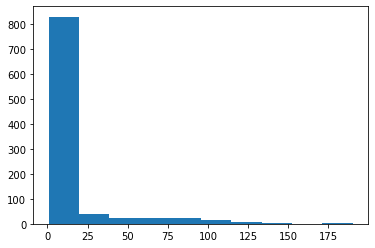

In [11]:
plt.hist(target_error_pairs)

In [12]:
err_thresh = np.quantile(target_error_pairs, 0.9)

In [13]:
# Throw away trajectories with highly erratic velocity profiles
# (large number of zero crossings in the acceleration)

In [14]:
n_zeros = np.zeros(len(target_pairs))
for i in range(len(target_pairs)):
    acc = np.diff(vel[valid_transition_times[target_pairs[i][0]]:\
                      valid_transition_times[target_pairs[i][1]]], axis=0)    
    n_zeros[i] = (np.diff(np.sign(acc)) != 0).sum()

In [15]:
# Throw away reaches with highest 10 % of target error and > 200 acceleration zero crossings
# Pair of target corrdinates
valid_target_pairs = []
# How long did the reach take
reach_duration = []
# Tuple of indices that describes start and end of reach
transition_times = []
transition_vectors = []

for i in range(len(target_error_pairs)):
    
    # Keep this transition
    if target_error_pairs[i] < err_thresh and n_zeros[i] < 200:
        valid_target_pairs.append((target_locs[target_pairs[i][0]], target_locs[target_pairs[i][1]]))        
        reach_duration.append(time_on_target[target_pairs[i][1]])
        transition_times.append((valid_transition_times[target_pairs[i][0]] + 1,
                                 valid_transition_times[target_pairs[i][1]]))
        transition_vectors.append(target_locs[target_pairs[i][1]] - target_locs[target_pairs[i][0]])
    else:
        continue

In [16]:
target_error_pairs = target_error_pairs[np.bitwise_and(target_error_pairs < err_thresh,
                                                       n_zeros < 200)]

In [17]:
# Trialization strategy - first need to calculate velocity sequences 
# Calculate the orientation of target transition vectors relative to a fixed vector. Group together with 
# various coarsenings of the similarity bins of orientation and velocity proifles

In [18]:
transition_orientation = np.zeros(len(transition_vectors))
refvec = np.array([1, 0])
for i in range(len(transition_vectors)):
    # Normalize
    transvecnorm = transition_vectors[i]/np.linalg.norm(transition_vectors[i])
    dot = transvecnorm @ refvec      # dot product
    det = transvecnorm[0]*refvec[1] - transvecnorm[1]*refvec[0]  # determinant
    transition_orientation[i] = np.arctan2(det, dot)

(array([ 63., 137., 142., 162., 116.,  99.,  66.,  41.,  29.,   6.]),
 array([  0.40544247,  19.37147603,  38.33750959,  57.30354316,
         76.26957672,  95.23561028, 114.20164384, 133.1676774 ,
        152.13371096, 171.09974453, 190.06577809]),
 <BarContainer object of 10 artists>)

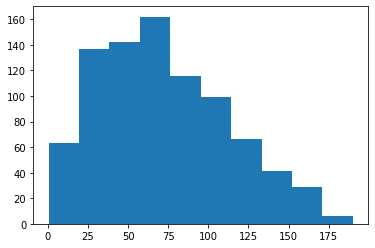

In [19]:
plt.hist(np.linalg.norm(transition_vectors, axis=1))

In [20]:
# Also use the transitionvecnorm

(array([164.,  66.,  43.,  66., 116., 137.,  74.,  49.,  52.,  94.]),
 array([-3.14159265, -2.51545447, -1.88931629, -1.26317811, -0.63703993,
        -0.01090175,  0.61523643,  1.24137461,  1.86751279,  2.49365097,
         3.11978915]),
 <BarContainer object of 10 artists>)

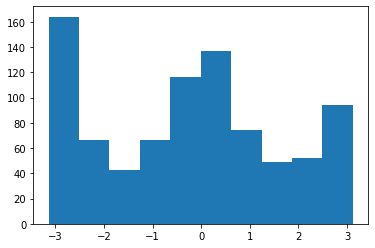

In [21]:
plt.hist(transition_orientation)

In [22]:
# Winding angle

In [23]:
from copy import deepcopy

In [24]:
winding_angle = []
# Operator on a copy of trajectory
cursor_trajectory = deepcopy(dat['behavior'])
dtheta = []
for i in range(len(valid_target_pairs)):
    
    trajectory = cursor_trajectory[transition_times[i][0]:transition_times[i][1], :]
    
    # Translate to the origin
    trajectory -= trajectory[0, :]
    theta = np.arctan2(trajectory[:, 1], trajectory[:, 0]) % (2 * np.pi)
    dtheta.append(np.diff(theta))
    # Integrate
    winding_angle.append(np.sum(np.abs(np.diff(theta))))

In [25]:
# Integrate the area under the trajectory minus the straight line
straight_dev = np.zeros(len(valid_target_pairs))
# Operator on a copy of trajectory
cursor_trajectory = deepcopy(dat['behavior'])
for i in range(len(valid_target_pairs)):
    
    trajectory = cursor_trajectory[transition_times[i][0]:transition_times[i][1], :]

    # Translate to the origin relative to the 1st target location
    trajectory -= valid_target_pairs[i][0]

    # straight line vector
    straight = transition_vectors[i]        
    straight /= np.linalg.norm(straight)

    if straight[0] == 0:
        perp = np.array([1, 0])
    elif straight[1] == 0:
        perp = np.array([0, 1])
    else:
        # Vector orthogonal to the straight line between targets
        x_orth = np.random.uniform(0, 1)
        y_orth = -1 * (straight[0] * x_orth)/straight[1]
        perp = np.array([x_orth, y_orth])
        perp /= np.linalg.norm(perp)
    
    if np.any(np.isnan(perp)):
        pdb.set_trace()
    
#     # This needs to be related to the inner product of the increments with the perp direction
#     trajectory_diff = np.diff(trajectory, axis=0)
#     # Translate to origin
#     straight_dev[i] = np.abs(sum([trajectory_diff[j, :] @ perp 
#                                   for j in range(trajectory_diff.shape[0])]))/\
#                                   sum(np.linalg.norm(trajectory_diff, axis=-1))

    m = straight[1]/straight[0]
    b = 0
        
    for j in range(trajectory.shape[0]):
        
        # transition is horizontal
        if m == 0:
            x_int = trajectory[j, 0]
            y_int = valid_target_pairs[i][0][1]
        # transition is vertical
        elif np.isnan(m) or np.isinf(m):
            x_int = valid_target_pairs[i][0][0]
            y_int = trajectory[j, 1]
        else:
            m1 = -1/m
            b1 = trajectory[j, 1] - m1 * trajectory[j, 0]
            # Find the intersection between the two lines
            x_int = (b - b1)/(m1 - m)
            y_int = m1 * x_int + b1
        
        straight_dev[i] += np.linalg.norm(np.array([x_int - trajectory[j, 0], y_int - trajectory[j, 1]]))
    # Normalize by the length of the straight line trajectory
    straight_dev[i] /= np.linalg.norm(transition_vectors[i])
          
#         # Plot verification
#         if j == 10:
#             if i == 180:
#                 tidx = 180
#                 plt.scatter([0, valid_target_pairs[tidx][1][0] - valid_target_pairs[tidx][0][0]], 
#                 [0, valid_target_pairs[tidx][1][1] - valid_target_pairs[tidx][0][1]])
#                 # trajectory
#                 plt.plot(trajectory[:, 0],
#                          trajectory[:, 1])

#                 # Plot the trajectory difference at each of the 
#                 xmin = min([0, valid_target_pairs[tidx][1][0] - valid_target_pairs[tidx][0][0]])
#                 xmax = max([0, valid_target_pairs[tidx][1][0] - valid_target_pairs[tidx][0][0]])

#                 plt.plot(np.linspace(xmin, xmax), m * np.linspace(xmin, xmax) + b)
            
#                 xmin = min([trajectory[j, 0], x_int])
#                 xmax = max([trajectory[j, 0], x_int])
                
#                 plt.plot(np.linspace(xmin, xmax), m1 * np.linspace(xmin, xmax) + b1)                

#                 # Plot the straight line and the perpendicular line
#                 # plt.plot([0, 10 * straight[0]], [0, 10* straight[1]])
#         #         plt.plot([0, 10 * perp[0]], [0, 10*perp[1]])

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


In [26]:
# Example of successful reaches

In [27]:
err_ordering = np.argsort(target_error_pairs)

In [28]:
xlims = [np.min(dat['target_pos'][:, 0]), np.max(dat['target_pos'][:, 0])]
ylims = [np.min(dat['target_pos'][:, 1]), np.max(dat['target_pos'][:, 1])]

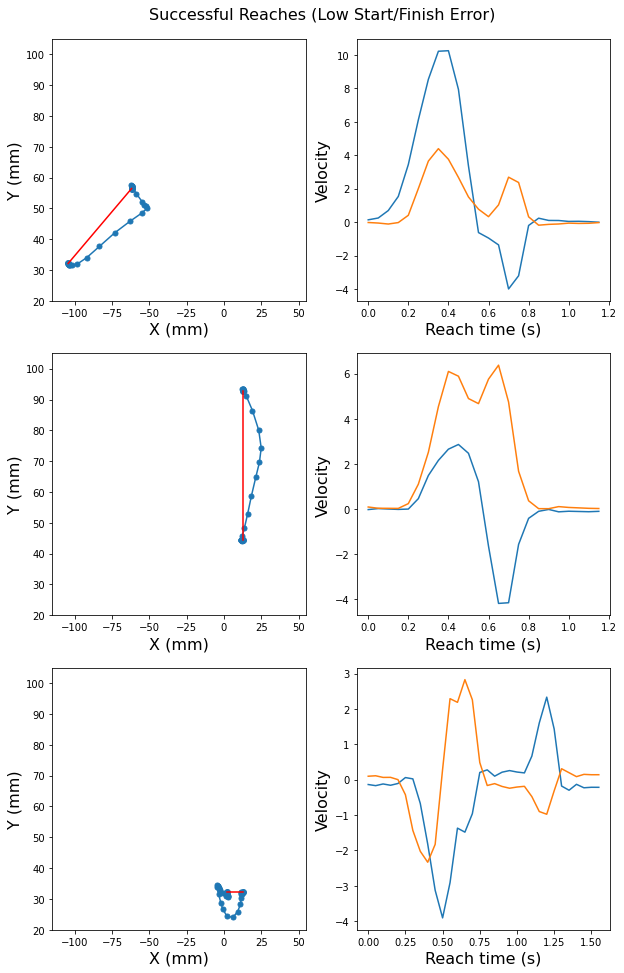

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    tidx = err_ordering[i]
    # targets
    ax[i, 0].scatter([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]])
    # trajectory
    ax[i, 0].plot(dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 0],
                  dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 1], '-o', 
                  markersize=5)
    
    # Annotate with the initial and final error
#     ax[i, 0].text(0.1, 0.9, '%.2f' % target_error_pairs[tidx], transform=ax[i, 0].transAxes)

    # straight line between points
    ax[i, 0].plot([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]], 'r')

    ax[i, 0].set_xlim(xlims)
    ax[i, 0].set_ylim(ylims)

    ax[i, 0].set_ylabel('Y (mm)', fontsize=16)
    ax[i, 0].set_xlabel('X (mm)', fontsize=16)
    
    vel_ = vel[transition_times[tidx][0]:transition_times[tidx][1], :]
    acc = np.diff(vel[transition_times[tidx][0]:transition_times[tidx][1], :], axis=0)
    t_ = dat['time'][transition_times[tidx][0]:transition_times[tidx][1]]
    
    #t_ = t_[1:] - t_[0]
    t_ -= t_[0]
    
    ax[i, 1].plot(t_, vel_)
    ax[i, 1].set_ylabel('Velocity', fontsize=16)
    ax[i, 1].set_xlabel('Reach time (s)', fontsize=16)
    
    # Number of zero crossings
    n_zeros = (np.diff(np.sign(acc)) != 0).sum()
#    ax[i, 1].text(0.5, 0.25, '%d' % n_zeros, transform=ax[i, 1].transAxes)
fig.subplots_adjust(top=0.95)
fig.suptitle('Successful Reaches (Low Start/Finish Error)', fontsize=16)
fig.savefig('sabes_segmentation/low_error_example.pdf', bbox_inches='tight', pad_inches=0)

In [294]:
# Examples of unsuccessful reaches

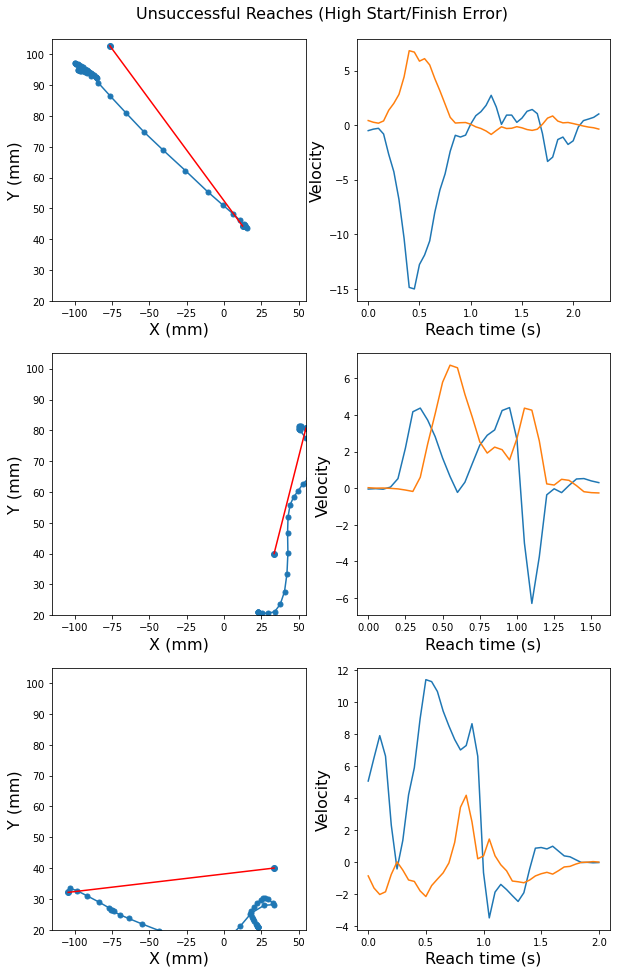

In [67]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    tidx = err_ordering[i + 840]
    # targets
    ax[i, 0].scatter([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]])
    # trajectory
    ax[i, 0].plot(dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 0],
                  dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 1], '-o', 
                  markersize=5)
    
    # Annotate with the initial and final error
#     ax[i, 0].text(0.1, 0.9, '%.2f' % target_error_pairs[tidx], transform=ax[i, 0].transAxes)

    # straight line between points
    ax[i, 0].plot([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]], 'r')

    ax[i, 0].set_xlim(xlims)
    ax[i, 0].set_ylim(ylims)

    ax[i, 0].set_ylabel('Y (mm)', fontsize=16)
    ax[i, 0].set_xlabel('X (mm)', fontsize=16)
    
    vel_ = vel[transition_times[tidx][0]:transition_times[tidx][1], :]
    acc = np.diff(vel[transition_times[tidx][0]:transition_times[tidx][1], :], axis=0)
    t_ = dat['time'][transition_times[tidx][0]:transition_times[tidx][1]]
    
    #t_ = t_[1:] - t_[0]
    t_ -= t_[0]
    
    ax[i, 1].plot(t_, vel_)
    ax[i, 1].set_ylabel('Velocity', fontsize=16)
    ax[i, 1].set_xlabel('Reach time (s)', fontsize=16)
    
    # Number of zero crossings
    n_zeros = (np.diff(np.sign(acc)) != 0).sum()
#    ax[i, 1].text(0.5, 0.25, '%d' % n_zeros, transform=ax[i, 1].transAxes)
fig.subplots_adjust(top=0.95)
fig.suptitle('Unsuccessful Reaches (High Start/Finish Error)', fontsize=16)
fig.savefig('sabes_segmentation/high_error_example.pdf', bbox_inches='tight', pad_inches=0)

In [58]:
devorder = np.argsort(straight_dev)

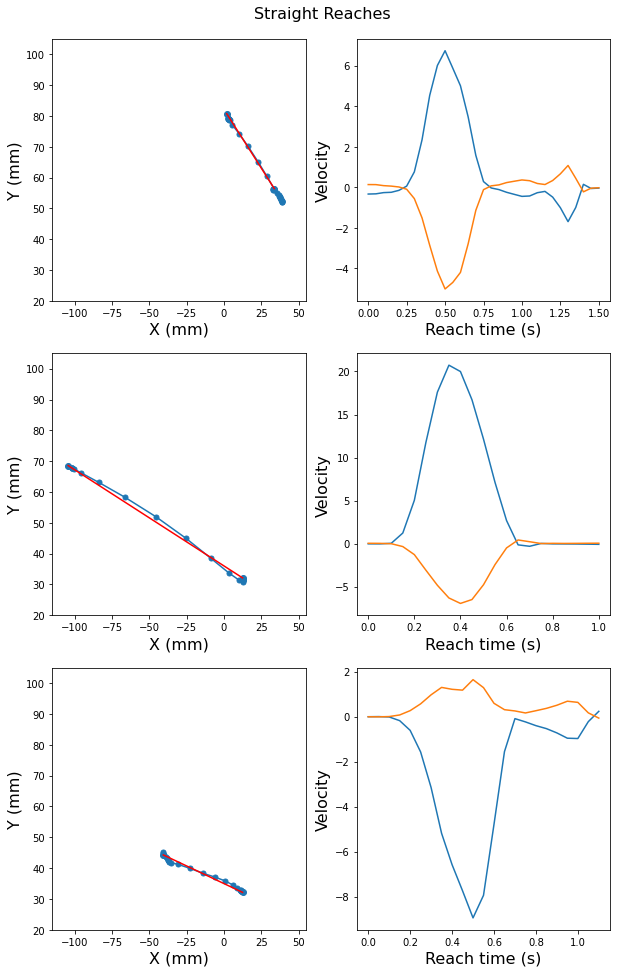

In [70]:
# Example of reaches with large rotational component
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    tidx = devorder[i]
    # targets
    ax[i, 0].scatter([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]])
    # trajectory
    ax[i, 0].plot(dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 0],
                  dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 1], '-o', 
                  markersize=5)
    
    # Annotate with the initial and final error
#     ax[i, 0].text(0.1, 0.9, '%.2f' % target_error_pairs[tidx], transform=ax[i, 0].transAxes)

    # straight line between points
    ax[i, 0].plot([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]], 'r')

    ax[i, 0].set_xlim(xlims)
    ax[i, 0].set_ylim(ylims)

    ax[i, 0].set_ylabel('Y (mm)', fontsize=16)
    ax[i, 0].set_xlabel('X (mm)', fontsize=16)
    
    vel_ = vel[transition_times[tidx][0]:transition_times[tidx][1], :]
    acc = np.diff(vel[transition_times[tidx][0]:transition_times[tidx][1], :], axis=0)
    t_ = dat['time'][transition_times[tidx][0]:transition_times[tidx][1]]
    
    #t_ = t_[1:] - t_[0]
    t_ -= t_[0]
    
    ax[i, 1].plot(t_, vel_)
    ax[i, 1].set_ylabel('Velocity', fontsize=16)
    ax[i, 1].set_xlabel('Reach time (s)', fontsize=16)
    
fig.subplots_adjust(top=0.95)
fig.suptitle('Straight Reaches', fontsize=16)
fig.savefig('sabes_segmentation/straight_example.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Joint ordering of reach curvature and target error

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
straight_dev.shape

(861,)

In [34]:
# We make large deviations small so that we can minimize the sum
straight_dev_normalized = np.squeeze(MinMaxScaler().fit_transform(np.power(straight_dev[:, np.newaxis], -1)))
target_error_normalized = np.squeeze(MinMaxScaler().fit_transform(target_error_pairs[:, np.newaxis]))

In [35]:
combined_obj = straight_dev_normalized + target_error_normalized
combined_order = np.argsort(combined_obj)

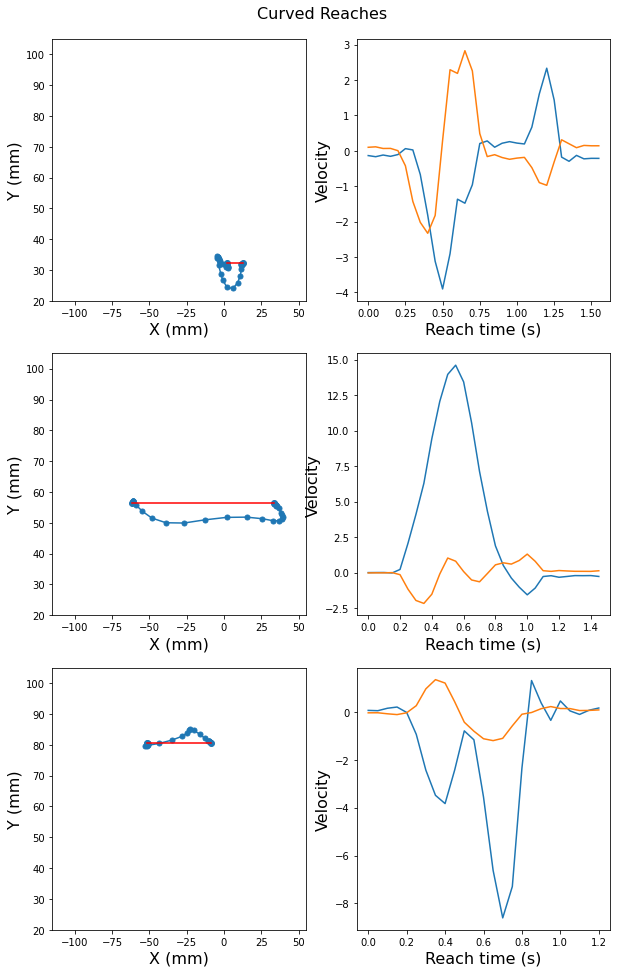

In [82]:
# Example of reaches with large rotational component
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    tidx = combined_order[i]
    # targets
    ax[i, 0].scatter([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]])
    # trajectory
    ax[i, 0].plot(dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 0],
                  dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 1], '-o', 
                  markersize=5)
    
    # Annotate with the initial and final error
#     ax[i, 0].text(0.1, 0.9, '%.2f' % target_error_pairs[tidx], transform=ax[i, 0].transAxes)

    # straight line between points
    ax[i, 0].plot([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]], 'r')

    ax[i, 0].set_xlim(xlims)
    ax[i, 0].set_ylim(ylims)

    ax[i, 0].set_ylabel('Y (mm)', fontsize=16)
    ax[i, 0].set_xlabel('X (mm)', fontsize=16)
    
    vel_ = vel[transition_times[tidx][0]:transition_times[tidx][1], :]
    acc = np.diff(vel[transition_times[tidx][0]:transition_times[tidx][1], :], axis=0)
    t_ = dat['time'][transition_times[tidx][0]:transition_times[tidx][1]]
    
    #t_ = t_[1:] - t_[0]
    t_ -= t_[0]
    
    ax[i, 1].plot(t_, vel_)
    ax[i, 1].set_ylabel('Velocity', fontsize=16)
    ax[i, 1].set_xlabel('Reach time (s)', fontsize=16)
    
fig.subplots_adjust(top=0.95)
fig.suptitle('Curved Reaches', fontsize=16)
fig.savefig('sabes_segmentation/curved_example.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Features constructed for trialization 
# (1) Reach orientation (transition_orientation)
# (2) Target Reach length np.linalg.norm(transition_vectors, axis=1)
# (3) Perpendicularity of trajectory (straight_dev)
# (4) Nominal reach velocity np.linalg.norm(transition_vectors, axis=1)/reach_duration

In [43]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram

In [103]:
X = np.vstack([np.array(transition_orientation)[np.newaxis, :],
               np.array(np.linalg.norm(transition_vectors, axis=1))[np.newaxis, :],
               np.array(straight_dev)[np.newaxis, :]]).T
#               np.array(np.divide(np.linalg.norm(transition_vectors, axis=1), reach_duration))[np.newaxis, :]]).T

In [104]:
X = MinMaxScaler().fit_transform(X)

In [37]:
import sklearn

In [56]:
clusterer = AgglomerativeClustering(n_clusters=None, distance_threshold=5e-3, 
                                    compute_distances=True)
clusterer.fit(X)

AgglomerativeClustering(compute_distances=True, distance_threshold=0.005,
                        n_clusters=None)

In [57]:
X.shape

(861, 3)

In [58]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

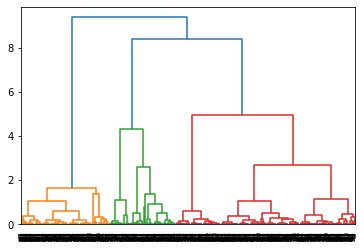

In [59]:
plot_dendrogram(clusterer)

In [30]:
import umap

In [31]:
reducer = umap.UMAP()

In [39]:
embedding = reducer.fit_transform(X)

In [40]:
embedding.shape

(861, 2)

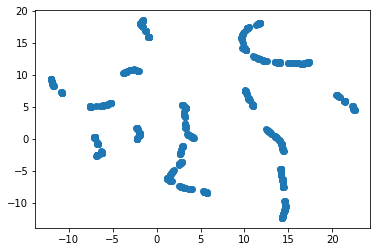

In [42]:
plt.scatter(embedding[:, 0], embedding[:, 1])

In [133]:
# DBSCAN
db_clusterer = DBSCAN(eps=2e-2)

In [134]:
labels = db_clusterer.fit_predict(X)

In [135]:
np.unique(labels).size

16

In [162]:
X.shape

(861, 3)

In [165]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
ax.set_xlabel('Orientation')
ax.set_ylabel('Distance')
ax.set_zlabel('Curvature')

Text(0.5, 0, 'Curvature')

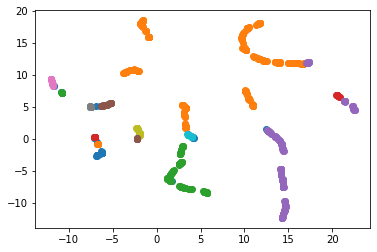

In [156]:
# Color the UMAP 
for grp in np.unique(labels):
    plt.scatter(embedding[labels == grp, 0], embedding[labels == grp, 1])
plt.savefig('sabes_segmentation/dbscan_ambient.pdf', bbox_inches='tight', pad_inches=0)

In [68]:
clusterer = AgglomerativeClustering(n_clusters=None, distance_threshold=5e-1, 
                                    compute_distances=True)
labels = clusterer.fit_predict(X) 

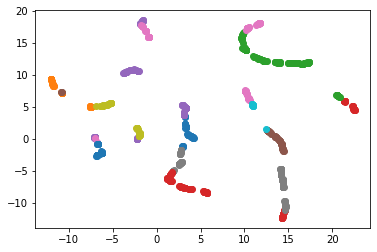

In [69]:
# Color the UMAP 
for grp in np.unique(labels):
    plt.scatter(embedding[labels == grp, 0], embedding[labels == grp, 1])

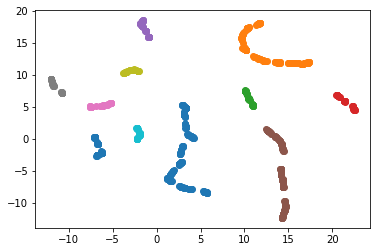

In [157]:
# DBSCAN on the UMAP features
db_clusterer = DBSCAN(eps=3)
labels_embedded = db_clusterer.fit_predict(embedding)
# Color the UMAP 
for grp in np.unique(labels_embedded):
    plt.scatter(embedding[labels_embedded == grp, 0], embedding[labels_embedded == grp, 1])
plt.savefig('sabes_segmentation/dbscan_embedded.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# So how do we distinguish between these features?

# Given the DBSCAN on X and embedding, fit OLS VAR to each "trial type"

In [140]:
from pyuoi.linear_model import var
from tqdm import tqdm

In [79]:
dat['spike_rates'].shape

(1, 48992, 204)

In [90]:
X[0].shape

(139, 204)

In [141]:
varmodels1 = []
for i, label_ in tqdm(enumerate(np.unique(labels))):
    
    idxs = np.arange(len(labels))[labels == label_]
    
    # Assemble the neural time series
    y = []
    for idx in idxs:
        y.append(dat['spike_rates'][0, transition_times[idx][0]:transition_times[idx][1], :])

    varmodel = var.VAR(estimator='uoi', penalty='scad', 
                       fit_type='union_only', estimation_score='gMDL')
    varmodel.fit(y)
    varmodels1.append(varmodel)

0it [00:00, ?it/s]
0it [00:00, ?it/s]

Training is over.



1it [00:04,  4.82s/it]

Training is over.



2it [00:09,  4.94s/it]

Training is over.



3it [00:15,  5.17s/it]

Training is over.



4it [00:20,  5.16s/it]

Training is over.



5it [00:25,  5.28s/it]

Training is over.



6it [00:30,  5.05s/it]

Training is over.



7it [00:34,  4.80s/it]

Training is over.



8it [00:39,  4.71s/it]

Training is over.



9it [00:43,  4.69s/it]

Training is over.



10it [00:48,  4.73s/it]

Training is over.



11it [00:53,  4.75s/it]

Training is over.



12it [00:58,  4.71s/it]

Training is over.



13it [01:02,  4.59s/it]

Training is over.



15it [01:07,  3.56s/it]

Training is over.



16it [01:12,  3.96s/it]

Training is over.



17it [01:17,  4.14s/it]

Training is over.



18it [01:21,  4.16s/it]

Training is over.



19it [01:26,  4.51s/it]

Training is over.



20it [01:31,  4.64s/it]

Training is over.



21it [01:36,  4.63s/it]

Training is over.



23it [01:40,  3.47s/it]

Training is over.



24it [01:45,  3.80s/it]

Training is over.



25it [01:50,  4.16s/it]

Training is over.



26it [01:56,  4.55s/it]

Training is over.



27it [02:00,  4.58s/it]

Training is over.



28it [02:05,  4.64s/it]

Training is over.



29it [02:09,  4.56s/it]

Training is over.



30it [02:14,  4.68s/it]

Training is over.



31it [02:18,  4.53s/it]

Training is over.



33it [02:24,  3.61s/it]

Training is over.



34it [02:29,  4.07s/it]

Training is over.



35it [02:34,  4.33s/it]

Training is over.



36it [02:39,  4.39s/it]

Training is over.



37it [02:43,  4.49s/it]

Training is over.



38it [02:48,  4.47s/it]

Training is over.



39it [02:53,  4.62s/it]

Training is over.



40it [02:58,  4.74s/it]

Training is over.



41it [03:03,  4.73s/it]

Training is over.



42it [03:07,  4.67s/it]

Training is over.



43it [03:12,  4.74s/it]

Training is over.



44it [03:17,  4.76s/it]

Training is over.



45it [03:22,  4.89s/it]

Training is over.



46it [03:26,  4.71s/it]

Training is over.



47it [03:31,  4.79s/it]

Training is over.



48it [03:37,  5.10s/it]

Training is over.



49it [03:42,  5.11s/it]

Training is over.



50it [03:48,  5.25s/it]

Training is over.



51it [03:52,  4.96s/it]

Training is over.



52it [03:56,  4.77s/it]

Training is over.



53it [04:01,  4.83s/it]

Training is over.



54it [04:06,  4.87s/it]

Training is over.



55it [04:11,  4.86s/it]

Training is over.



56it [04:16,  4.78s/it]

Training is over.



57it [04:20,  4.71s/it]

Training is over.



58it [04:25,  4.73s/it]

Training is over.



59it [04:30,  4.76s/it]

Training is over.



60it [04:35,  4.80s/it]

Training is over.



61it [04:39,  4.74s/it]

Training is over.



62it [04:45,  4.86s/it]

Training is over.



63it [04:50,  4.92s/it]

Training is over.



65it [04:54,  3.77s/it]

Training is over.



66it [05:00,  4.09s/it]

Training is over.



67it [05:05,  4.35s/it]

Training is over.



68it [05:10,  4.53s/it]

Training is over.



69it [05:14,  4.57s/it]

Training is over.



70it [05:19,  4.59s/it]

Training is over.



71it [05:24,  4.66s/it]

Training is over.



72it [05:29,  4.81s/it]

Training is over.



73it [05:34,  4.92s/it]

Training is over.



74it [05:39,  4.84s/it]

Training is over.



75it [05:43,  4.72s/it]

Training is over.



76it [05:48,  4.67s/it]

Training is over.



77it [05:53,  4.75s/it]

Training is over.



78it [05:57,  4.75s/it]

Training is over.



79it [06:02,  4.66s/it]

Training is over.



80it [06:07,  4.66s/it]

Training is over.



81it [06:12,  4.97s/it]

Training is over.



83it [06:17,  3.80s/it]

Training is over.



84it [06:22,  4.16s/it]

Training is over.



85it [06:27,  4.39s/it]

Training is over.



86it [06:32,  4.55s/it]

Training is over.



87it [06:38,  4.79s/it]

Training is over.



88it [06:42,  4.77s/it]

Training is over.



89it [06:47,  4.79s/it]

Training is over.



90it [06:53,  4.93s/it]

Training is over.



91it [06:57,  4.64s/it]

Training is over.



92it [07:01,  4.67s/it]

Training is over.



93it [07:06,  4.72s/it]

Training is over.



94it [07:11,  4.74s/it]

Training is over.



95it [07:16,  4.90s/it]

Training is over.



96it [07:22,  5.06s/it]

Training is over.



97it [07:26,  5.01s/it]

Training is over.



99it [07:31,  3.81s/it]

Training is over.



100it [07:37,  4.26s/it]

Training is over.



101it [07:42,  4.52s/it]

Training is over.



102it [07:47,  4.62s/it]

Training is over.



103it [07:53,  4.86s/it]

Training is over.



104it [07:58,  4.98s/it]

Training is over.



105it [08:03,  5.12s/it]

Training is over.



106it [08:09,  5.34s/it]

Training is over.



107it [08:14,  5.16s/it]

Training is over.



108it [08:19,  5.07s/it]

Training is over.



109it [08:24,  5.05s/it]

Training is over.



110it [08:28,  4.90s/it]

Training is over.



111it [08:34,  5.01s/it]

Training is over.



112it [08:39,  5.03s/it]

Training is over.



113it [08:44,  5.06s/it]

Training is over.



114it [08:49,  4.99s/it]

Training is over.



115it [08:54,  5.02s/it]

Training is over.



116it [08:58,  4.89s/it]

Training is over.



117it [09:04,  5.06s/it]

Training is over.



118it [09:09,  5.10s/it]

Training is over.



119it [09:14,  4.99s/it]

Training is over.



120it [09:19,  5.09s/it]

Training is over.



121it [09:24,  4.93s/it]

Training is over.



122it [09:29,  5.03s/it]

Training is over.



123it [09:34,  5.14s/it]

Training is over.



124it [09:39,  4.94s/it]

Training is over.



125it [09:44,  4.94s/it]

Training is over.



126it [09:49,  4.97s/it]

Training is over.



127it [09:53,  4.87s/it]

Training is over.



128it [09:58,  4.72s/it]

Training is over.



129it [10:02,  4.62s/it]

Training is over.



130it [10:07,  4.63s/it]

Training is over.



131it [10:11,  4.61s/it]

Training is over.



132it [10:16,  4.64s/it]

Training is over.



133it [10:20,  4.57s/it]

Training is over.



134it [10:25,  4.60s/it]

Training is over.



135it [10:30,  4.64s/it]

Training is over.



136it [10:35,  4.77s/it]

Training is over.



137it [10:40,  4.83s/it]

Training is over.



138it [10:45,  4.91s/it]

Training is over.



139it [10:50,  5.00s/it]

Training is over.



140it [10:55,  4.99s/it]

Training is over.



141it [11:00,  4.97s/it]

Training is over.



142it [11:04,  4.81s/it]

Training is over.



143it [11:09,  4.82s/it]

Training is over.



144it [11:14,  4.76s/it]

Training is over.



145it [11:19,  4.71s/it]

Training is over.



146it [11:23,  4.66s/it]

Training is over.



147it [11:28,  4.61s/it]

Training is over.



148it [11:33,  4.79s/it]

Training is over.



149it [11:37,  4.71s/it]

Training is over.



150it [11:42,  4.68s/it]

Training is over.



151it [11:46,  4.62s/it]

Training is over.



152it [11:51,  4.71s/it]

Training is over.



153it [11:57,  4.90s/it]

Training is over.



154it [12:01,  4.80s/it]

Training is over.



155it [12:06,  4.79s/it]

Training is over.



156it [12:11,  4.83s/it]

Training is over.



157it [12:16,  4.75s/it]

Training is over.



158it [12:20,  4.75s/it]

Training is over.



159it [12:25,  4.76s/it]

Training is over.



160it [12:30,  4.96s/it]

Training is over.



161it [12:35,  4.95s/it]

Training is over.



162it [12:40,  4.97s/it]

Training is over.



163it [12:45,  4.89s/it]

Training is over.



164it [12:50,  4.78s/it]

Training is over.



165it [12:55,  4.83s/it]

Training is over.



166it [12:59,  4.66s/it]

Training is over.



167it [13:04,  4.74s/it]

Training is over.



168it [13:09,  4.96s/it]

Training is over.



169it [13:14,  4.90s/it]

Training is over.



170it [13:19,  5.00s/it]

Training is over.



171it [13:24,  4.87s/it]

Training is over.



172it [13:29,  5.01s/it]

Training is over.



173it [13:34,  4.98s/it]

Training is over.



174it [13:38,  4.72s/it]

Training is over.



175it [13:43,  4.83s/it]

Training is over.



176it [13:49,  5.01s/it]

Training is over.



177it [13:54,  5.02s/it]

Training is over.



178it [13:58,  4.91s/it]

Training is over.



179it [14:03,  4.81s/it]

Training is over.



180it [14:08,  4.80s/it]

Training is over.



181it [14:12,  4.74s/it]

Training is over.



182it [14:17,  4.85s/it]

Training is over.



183it [14:22,  4.89s/it]

Training is over.



184it [14:27,  4.75s/it]

Training is over.



185it [14:32,  4.79s/it]

Training is over.



186it [14:37,  4.93s/it]

Training is over.



187it [14:43,  5.17s/it]

Training is over.



188it [14:48,  5.32s/it]

Training is over.



189it [14:53,  5.15s/it]

Training is over.



190it [14:58,  5.14s/it]

Training is over.



191it [15:03,  4.90s/it]

Training is over.



192it [15:08,  4.93s/it]

Training is over.



193it [15:12,  4.91s/it]

Training is over.



194it [15:18,  5.03s/it]

Training is over.



195it [15:22,  4.93s/it]

Training is over.



196it [15:27,  4.88s/it]

Training is over.



197it [15:32,  4.83s/it]

Training is over.



198it [15:37,  4.85s/it]

Training is over.



199it [15:42,  4.95s/it]

Training is over.



200it [15:47,  4.95s/it]

Training is over.



201it [15:52,  5.09s/it]

Training is over.



202it [15:58,  5.11s/it]

Training is over.



203it [16:02,  4.90s/it]

Training is over.



204it [16:07,  4.74s/it]
1it [16:07, 967.19s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:22, 22.08s/it]

Training is over.



2it [00:45, 22.60s/it]

Training is over.



3it [01:07, 22.44s/it]

Training is over.



4it [01:32, 23.52s/it]

Training is over.



5it [01:55, 23.43s/it]

Training is over.



6it [02:16, 22.48s/it]

Training is over.



7it [02:40, 22.90s/it]

Training is over.



8it [03:03, 23.06s/it]

Training is over.



9it [03:25, 22.82s/it]

Training is over.



10it [03:44, 21.67s/it]

Training is over.



11it [04:09, 22.46s/it]

Training is over.



12it [04:32, 22.82s/it]

Training is over.



13it [04:55, 22.74s/it]

Training is over.



14it [05:18, 22.98s/it]

Training is over.



15it [05:43, 23.53s/it]

Training is over.



16it [06:05, 23.03s/it]

Training is over.



17it [06:27, 22.80s/it]

Training is over.



18it [06:49, 22.33s/it]

Training is over.



19it [07:11, 22.28s/it]

Training is over.



20it [07:33, 22.16s/it]

Training is over.



21it [07:54, 22.06s/it]

Training is over.



23it [08:17, 17.03s/it]

Training is over.



24it [08:39, 18.30s/it]

Training is over.



25it [09:02, 19.59s/it]

Training is over.



26it [09:26, 20.73s/it]

Training is over.



27it [09:49, 21.32s/it]

Training is over.



28it [10:11, 21.47s/it]

Training is over.



29it [10:30, 20.84s/it]

Training is over.



30it [10:52, 21.16s/it]

Training is over.



31it [11:13, 21.16s/it]

Training is over.



33it [11:39, 17.37s/it]

Training is over.



34it [12:03, 19.13s/it]

Training is over.



35it [12:25, 19.91s/it]

Training is over.



36it [12:49, 20.92s/it]

Training is over.



37it [13:14, 21.96s/it]

Training is over.



38it [13:34, 21.62s/it]

Training is over.



39it [13:55, 21.44s/it]

Training is over.



40it [14:16, 21.25s/it]

Training is over.



41it [14:38, 21.39s/it]

Training is over.



42it [14:54, 19.74s/it]

Training is over.



43it [15:13, 19.68s/it]

Training is over.



44it [15:35, 20.36s/it]

Training is over.



45it [15:58, 21.02s/it]

Training is over.



46it [16:22, 21.92s/it]

Training is over.



47it [16:47, 22.88s/it]

Training is over.



48it [17:13, 23.77s/it]

Training is over.



49it [17:34, 23.10s/it]

Training is over.



50it [17:55, 22.38s/it]

Training is over.



51it [18:15, 21.52s/it]

Training is over.



52it [18:38, 22.12s/it]

Training is over.



53it [18:59, 21.87s/it]

Training is over.



54it [19:22, 22.18s/it]

Training is over.



55it [19:42, 21.55s/it]

Training is over.



56it [20:06, 22.18s/it]

Training is over.



57it [20:26, 21.44s/it]

Training is over.



58it [20:50, 22.24s/it]

Training is over.



59it [21:12, 22.29s/it]

Training is over.



60it [21:36, 22.62s/it]

Training is over.



61it [22:00, 23.23s/it]

Training is over.



62it [22:22, 22.78s/it]

Training is over.



63it [22:45, 22.68s/it]

Training is over.



64it [23:06, 22.46s/it]

Training is over.



65it [23:26, 21.65s/it]

Training is over.



66it [23:48, 21.82s/it]

Training is over.



67it [24:09, 21.41s/it]

Training is over.



68it [24:31, 21.57s/it]

Training is over.



69it [24:52, 21.37s/it]

Training is over.



70it [25:13, 21.45s/it]

Training is over.



71it [25:37, 22.11s/it]

Training is over.



72it [25:57, 21.49s/it]

Training is over.



73it [26:19, 21.71s/it]

Training is over.



74it [26:41, 21.70s/it]

Training is over.



75it [27:00, 21.03s/it]

Training is over.



76it [27:23, 21.38s/it]

Training is over.



77it [27:44, 21.45s/it]

Training is over.



78it [28:05, 21.22s/it]

Training is over.



79it [28:28, 21.72s/it]

Training is over.



80it [28:49, 21.58s/it]

Training is over.



81it [29:12, 21.89s/it]

Training is over.



82it [29:36, 22.49s/it]

Training is over.



83it [29:54, 21.37s/it]

Training is over.



84it [30:15, 21.29s/it]

Training is over.



85it [30:36, 21.05s/it]

Training is over.



86it [30:58, 21.33s/it]

Training is over.



87it [31:20, 21.52s/it]

Training is over.



88it [31:42, 21.84s/it]

Training is over.



89it [32:02, 21.29s/it]

Training is over.



90it [32:22, 20.75s/it]

Training is over.



91it [32:43, 20.76s/it]

Training is over.



92it [33:04, 20.90s/it]

Training is over.



93it [33:26, 21.38s/it]

Training is over.



94it [33:50, 21.89s/it]

Training is over.



95it [34:13, 22.27s/it]

Training is over.



96it [34:37, 22.94s/it]

Training is over.



97it [35:03, 23.90s/it]

Training is over.



98it [35:25, 23.28s/it]

Training is over.



99it [35:47, 22.73s/it]

Training is over.



100it [36:07, 21.89s/it]

Training is over.



101it [36:29, 21.96s/it]

Training is over.



102it [36:53, 22.72s/it]

Training is over.



103it [37:13, 21.72s/it]

Training is over.



104it [37:33, 21.29s/it]

Training is over.



105it [37:54, 21.29s/it]

Training is over.



106it [38:17, 21.67s/it]

Training is over.



107it [38:39, 21.90s/it]

Training is over.



108it [39:01, 21.99s/it]

Training is over.



109it [39:24, 22.22s/it]

Training is over.



110it [39:45, 21.74s/it]

Training is over.



111it [40:03, 20.77s/it]

Training is over.



112it [40:25, 21.19s/it]

Training is over.



113it [40:46, 21.12s/it]

Training is over.



114it [41:08, 21.25s/it]

Training is over.



115it [41:28, 21.02s/it]

Training is over.



116it [41:51, 21.61s/it]

Training is over.



117it [42:09, 20.57s/it]

Training is over.



118it [42:32, 21.17s/it]

Training is over.



119it [42:54, 21.49s/it]

Training is over.



120it [43:16, 21.62s/it]

Training is over.



121it [43:37, 21.38s/it]

Training is over.



122it [43:59, 21.53s/it]

Training is over.



123it [44:19, 21.07s/it]

Training is over.



124it [44:42, 21.81s/it]

Training is over.



125it [45:06, 22.30s/it]

Training is over.



126it [45:25, 21.47s/it]

Training is over.



127it [45:47, 21.38s/it]

Training is over.



128it [46:09, 21.75s/it]

Training is over.



129it [46:30, 21.38s/it]

Training is over.



130it [46:51, 21.41s/it]

Training is over.



131it [47:11, 20.99s/it]

Training is over.



132it [47:34, 21.56s/it]

Training is over.



133it [47:58, 22.20s/it]

Training is over.



134it [48:21, 22.40s/it]

Training is over.



135it [48:39, 21.05s/it]

Training is over.



136it [48:58, 20.59s/it]

Training is over.



137it [49:17, 19.96s/it]

Training is over.



138it [49:37, 19.95s/it]

Training is over.



139it [49:56, 19.92s/it]

Training is over.



140it [50:17, 20.23s/it]

Training is over.



141it [50:36, 19.85s/it]

Training is over.



142it [50:57, 20.17s/it]

Training is over.



143it [51:16, 19.87s/it]

Training is over.



144it [51:38, 20.32s/it]

Training is over.



145it [52:01, 21.24s/it]

Training is over.



146it [52:23, 21.42s/it]

Training is over.



147it [52:44, 21.21s/it]

Training is over.



148it [53:06, 21.46s/it]

Training is over.



149it [53:26, 21.12s/it]

Training is over.



150it [53:49, 21.63s/it]

Training is over.



151it [54:09, 21.10s/it]

Training is over.



152it [54:32, 21.85s/it]

Training is over.



153it [54:51, 20.87s/it]

Training is over.



154it [55:13, 21.15s/it]

Training is over.



155it [55:35, 21.39s/it]

Training is over.



156it [55:59, 22.29s/it]

Training is over.



157it [56:21, 22.31s/it]

Training is over.



158it [56:43, 22.05s/it]

Training is over.



159it [57:04, 21.92s/it]

Training is over.



160it [57:24, 21.33s/it]

Training is over.



161it [57:44, 20.86s/it]

Training is over.



162it [58:06, 21.18s/it]

Training is over.



163it [58:26, 20.84s/it]

Training is over.



164it [58:47, 20.72s/it]

Training is over.



165it [59:07, 20.61s/it]

Training is over.



166it [59:30, 21.28s/it]

Training is over.



167it [59:52, 21.47s/it]

Training is over.



168it [1:00:15, 22.10s/it]

Training is over.



169it [1:00:38, 22.43s/it]

Training is over.



170it [1:00:59, 21.93s/it]

Training is over.



171it [1:01:19, 21.41s/it]

Training is over.



172it [1:01:41, 21.44s/it]

Training is over.



173it [1:02:01, 21.18s/it]

Training is over.



174it [1:02:22, 20.99s/it]

Training is over.



175it [1:02:42, 20.71s/it]

Training is over.



176it [1:03:02, 20.36s/it]

Training is over.



177it [1:03:22, 20.36s/it]

Training is over.



178it [1:03:43, 20.42s/it]

Training is over.



179it [1:04:03, 20.51s/it]

Training is over.



180it [1:04:26, 21.24s/it]

Training is over.



181it [1:04:47, 21.11s/it]

Training is over.



182it [1:05:08, 20.99s/it]

Training is over.



183it [1:05:29, 20.96s/it]

Training is over.



184it [1:05:52, 21.78s/it]

Training is over.



185it [1:06:13, 21.54s/it]

Training is over.



186it [1:06:35, 21.45s/it]

Training is over.



187it [1:06:54, 20.98s/it]

Training is over.



188it [1:07:17, 21.38s/it]

Training is over.



189it [1:07:36, 20.86s/it]

Training is over.



190it [1:07:58, 21.17s/it]

Training is over.



191it [1:08:21, 21.65s/it]

Training is over.



192it [1:08:42, 21.29s/it]

Training is over.



193it [1:09:05, 21.84s/it]

Training is over.



194it [1:09:26, 21.59s/it]

Training is over.



195it [1:09:49, 22.14s/it]

Training is over.



196it [1:10:11, 21.94s/it]

Training is over.



197it [1:10:30, 21.05s/it]

Training is over.



198it [1:10:50, 21.00s/it]

Training is over.



199it [1:11:10, 20.72s/it]

Training is over.



200it [1:11:33, 21.14s/it]

Training is over.



201it [1:11:52, 20.69s/it]

Training is over.



202it [1:12:14, 20.92s/it]

Training is over.



203it [1:12:36, 21.40s/it]

Training is over.



204it [1:13:01, 21.48s/it]
2it [1:29:08, 2975.59s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:08,  8.75s/it]

Training is over.



2it [00:17,  8.64s/it]

Training is over.



3it [00:25,  8.54s/it]

Training is over.



4it [00:34,  8.61s/it]

Training is over.



5it [00:42,  8.58s/it]

Training is over.



6it [00:51,  8.54s/it]

Training is over.



7it [01:00,  8.80s/it]

Training is over.



8it [01:08,  8.46s/it]

Training is over.



9it [01:18,  8.80s/it]

Training is over.



10it [01:26,  8.63s/it]

Training is over.



11it [01:34,  8.56s/it]

Training is over.



12it [01:42,  8.18s/it]

Training is over.



13it [01:50,  8.26s/it]

Training is over.



14it [01:59,  8.64s/it]

Training is over.



15it [02:09,  8.86s/it]

Training is over.



16it [02:18,  8.82s/it]

Training is over.



17it [02:26,  8.65s/it]

Training is over.



18it [02:34,  8.51s/it]

Training is over.



19it [02:43,  8.79s/it]

Training is over.



20it [02:52,  8.78s/it]

Training is over.



21it [03:00,  8.50s/it]

Training is over.



23it [03:09,  6.64s/it]

Training is over.



24it [03:17,  6.93s/it]

Training is over.



25it [03:25,  7.21s/it]

Training is over.



26it [03:34,  7.65s/it]

Training is over.



27it [03:42,  7.96s/it]

Training is over.



28it [03:51,  8.20s/it]

Training is over.



29it [03:59,  8.11s/it]

Training is over.



30it [04:07,  8.15s/it]

Training is over.



31it [04:15,  7.98s/it]

Training is over.



33it [04:23,  6.13s/it]

Training is over.



34it [04:32,  6.86s/it]

Training is over.



35it [04:40,  7.22s/it]

Training is over.



36it [04:49,  7.54s/it]

Training is over.



37it [04:57,  7.74s/it]

Training is over.



38it [05:04,  7.67s/it]

Training is over.



39it [05:11,  7.50s/it]

Training is over.



40it [05:20,  7.82s/it]

Training is over.



41it [05:28,  7.95s/it]

Training is over.



42it [05:37,  8.11s/it]

Training is over.



43it [05:44,  8.01s/it]

Training is over.



44it [05:53,  8.20s/it]

Training is over.



45it [06:01,  7.98s/it]

Training is over.



46it [06:09,  8.18s/it]

Training is over.



47it [06:18,  8.33s/it]

Training is over.



48it [06:27,  8.44s/it]

Training is over.



49it [06:35,  8.37s/it]

Training is over.



50it [06:43,  8.35s/it]

Training is over.



51it [06:51,  8.32s/it]

Training is over.



52it [07:01,  8.56s/it]

Training is over.



53it [07:09,  8.48s/it]

Training is over.



54it [07:17,  8.31s/it]

Training is over.



55it [07:24,  8.15s/it]

Training is over.



56it [07:33,  8.29s/it]

Training is over.



57it [07:41,  8.28s/it]

Training is over.



58it [07:49,  8.14s/it]

Training is over.



59it [07:57,  8.06s/it]

Training is over.



60it [08:05,  8.02s/it]

Training is over.



61it [08:14,  8.25s/it]

Training is over.



62it [08:23,  8.44s/it]

Training is over.



63it [08:31,  8.36s/it]

Training is over.



64it [08:39,  8.22s/it]

Training is over.



65it [08:46,  8.04s/it]

Training is over.



66it [08:55,  8.12s/it]

Training is over.



67it [09:04,  8.37s/it]

Training is over.



68it [09:12,  8.53s/it]

Training is over.



69it [09:20,  8.33s/it]

Training is over.



70it [09:30,  8.69s/it]

Training is over.



71it [09:38,  8.43s/it]

Training is over.



72it [09:46,  8.35s/it]

Training is over.



73it [09:55,  8.46s/it]

Training is over.



74it [10:02,  8.15s/it]

Training is over.



75it [10:10,  8.18s/it]

Training is over.



76it [10:19,  8.32s/it]

Training is over.



77it [10:27,  8.26s/it]

Training is over.



78it [10:36,  8.39s/it]

Training is over.



79it [10:45,  8.56s/it]

Training is over.



80it [10:53,  8.55s/it]

Training is over.



81it [11:01,  8.25s/it]

Training is over.



82it [11:10,  8.54s/it]

Training is over.



83it [11:18,  8.33s/it]

Training is over.



84it [11:26,  8.35s/it]

Training is over.



85it [11:35,  8.54s/it]

Training is over.



86it [11:45,  8.91s/it]

Training is over.



87it [11:53,  8.71s/it]

Training is over.



88it [12:01,  8.46s/it]

Training is over.



89it [12:09,  8.26s/it]

Training is over.



90it [12:16,  8.02s/it]

Training is over.



91it [12:25,  8.19s/it]

Training is over.



92it [12:34,  8.32s/it]

Training is over.



93it [12:41,  8.13s/it]

Training is over.



94it [12:50,  8.35s/it]

Training is over.



95it [12:58,  8.32s/it]

Training is over.



96it [13:07,  8.50s/it]

Training is over.



97it [13:16,  8.44s/it]

Training is over.



98it [13:24,  8.48s/it]

Training is over.



99it [13:33,  8.48s/it]

Training is over.



100it [13:41,  8.59s/it]

Training is over.



101it [13:50,  8.50s/it]

Training is over.



102it [13:58,  8.51s/it]

Training is over.



103it [14:06,  8.39s/it]

Training is over.



104it [14:14,  8.15s/it]

Training is over.



105it [14:23,  8.46s/it]

Training is over.



106it [14:31,  8.20s/it]

Training is over.



107it [14:39,  8.28s/it]

Training is over.



108it [14:48,  8.56s/it]

Training is over.



109it [14:57,  8.53s/it]

Training is over.



110it [15:05,  8.51s/it]

Training is over.



111it [15:13,  8.22s/it]

Training is over.



112it [15:21,  8.17s/it]

Training is over.



113it [15:30,  8.35s/it]

Training is over.



114it [15:38,  8.20s/it]

Training is over.



115it [15:46,  8.23s/it]

Training is over.



116it [15:53,  8.02s/it]

Training is over.



117it [16:01,  7.88s/it]

Training is over.



118it [16:09,  7.97s/it]

Training is over.



119it [16:17,  7.87s/it]

Training is over.



120it [16:25,  7.97s/it]

Training is over.



121it [16:34,  8.25s/it]

Training is over.



122it [16:42,  8.26s/it]

Training is over.



123it [16:50,  7.99s/it]

Training is over.



124it [16:58,  8.03s/it]

Training is over.



125it [17:06,  8.14s/it]

Training is over.



126it [17:14,  8.16s/it]

Training is over.



127it [17:23,  8.28s/it]

Training is over.



128it [17:31,  8.34s/it]

Training is over.



129it [17:39,  8.04s/it]

Training is over.



130it [17:47,  8.22s/it]

Training is over.



131it [17:55,  7.97s/it]

Training is over.



132it [18:03,  8.20s/it]

Training is over.



133it [18:12,  8.19s/it]

Training is over.



134it [18:20,  8.35s/it]

Training is over.



135it [18:29,  8.37s/it]

Training is over.



136it [18:36,  8.11s/it]

Training is over.



137it [18:45,  8.41s/it]

Training is over.



138it [18:54,  8.41s/it]

Training is over.



139it [19:01,  8.03s/it]

Training is over.



140it [19:09,  8.10s/it]

Training is over.



141it [19:17,  8.03s/it]

Training is over.



142it [19:26,  8.20s/it]

Training is over.



143it [19:34,  8.27s/it]

Training is over.



144it [19:42,  8.17s/it]

Training is over.



145it [19:51,  8.41s/it]

Training is over.



146it [19:59,  8.16s/it]

Training is over.



147it [20:07,  8.14s/it]

Training is over.



148it [20:14,  8.05s/it]

Training is over.



149it [20:22,  8.01s/it]

Training is over.



150it [20:31,  8.24s/it]

Training is over.



151it [20:39,  8.20s/it]

Training is over.



152it [20:47,  8.20s/it]

Training is over.



153it [20:55,  8.16s/it]

Training is over.



154it [21:04,  8.34s/it]

Training is over.



155it [21:12,  8.15s/it]

Training is over.



156it [21:20,  8.02s/it]

Training is over.



157it [21:27,  7.87s/it]

Training is over.



158it [21:36,  8.00s/it]

Training is over.



159it [21:43,  7.75s/it]

Training is over.



160it [21:51,  7.97s/it]

Training is over.



161it [21:59,  8.05s/it]

Training is over.



162it [22:08,  8.32s/it]

Training is over.



163it [22:17,  8.29s/it]

Training is over.



164it [22:25,  8.23s/it]

Training is over.



165it [22:32,  8.08s/it]

Training is over.



166it [22:41,  8.11s/it]

Training is over.



167it [22:49,  8.33s/it]

Training is over.



168it [22:57,  8.21s/it]

Training is over.



169it [23:05,  8.14s/it]

Training is over.



170it [23:14,  8.36s/it]

Training is over.



171it [23:23,  8.36s/it]

Training is over.



172it [23:30,  8.20s/it]

Training is over.



173it [23:38,  8.08s/it]

Training is over.



174it [23:45,  7.85s/it]

Training is over.



175it [23:53,  7.78s/it]

Training is over.



176it [24:02,  8.10s/it]

Training is over.



177it [24:10,  8.07s/it]

Training is over.



178it [24:17,  7.83s/it]

Training is over.



179it [24:26,  8.18s/it]

Training is over.



180it [24:34,  8.02s/it]

Training is over.



181it [24:42,  7.97s/it]

Training is over.



182it [24:51,  8.22s/it]

Training is over.



183it [24:58,  8.05s/it]

Training is over.



184it [25:07,  8.24s/it]

Training is over.



185it [25:15,  8.21s/it]

Training is over.



186it [25:22,  7.98s/it]

Training is over.



187it [25:32,  8.30s/it]

Training is over.



188it [25:40,  8.44s/it]

Training is over.



189it [25:49,  8.61s/it]

Training is over.



190it [25:58,  8.55s/it]

Training is over.



191it [26:06,  8.52s/it]

Training is over.



192it [26:15,  8.57s/it]

Training is over.



193it [26:22,  8.11s/it]

Training is over.



194it [26:31,  8.31s/it]

Training is over.



195it [26:39,  8.38s/it]

Training is over.



196it [26:47,  8.31s/it]

Training is over.



197it [26:56,  8.39s/it]

Training is over.



198it [27:04,  8.22s/it]

Training is over.



199it [27:13,  8.44s/it]

Training is over.



200it [27:22,  8.60s/it]

Training is over.



201it [27:30,  8.44s/it]

Training is over.



202it [27:38,  8.27s/it]

Training is over.



203it [27:45,  8.06s/it]

Training is over.



204it [27:53,  8.21s/it]
3it [1:57:02, 2381.23s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:02,  2.76s/it]

Training is over.



2it [00:05,  2.89s/it]

Training is over.



3it [00:08,  2.84s/it]

Training is over.



4it [00:11,  2.85s/it]

Training is over.



5it [00:14,  2.99s/it]

Training is over.



6it [00:18,  3.12s/it]

Training is over.



7it [00:20,  3.07s/it]

Training is over.
Training is over.



9it [00:24,  2.38s/it]

Training is over.



10it [00:27,  2.58s/it]

Training is over.



12it [00:30,  2.13s/it]

Training is over.



13it [00:33,  2.28s/it]

Training is over.



15it [00:35,  1.91s/it]

Training is over.



16it [00:38,  2.04s/it]

Training is over.



17it [00:41,  2.24s/it]

Training is over.



19it [00:44,  1.90s/it]

Training is over.



21it [00:46,  1.72s/it]

Training is over.



23it [00:49,  1.60s/it]

Training is over.



24it [00:52,  1.89s/it]

Training is over.



25it [00:56,  2.22s/it]

Training is over.



26it [00:58,  2.37s/it]

Training is over.



27it [01:01,  2.52s/it]

Training is over.



28it [01:04,  2.66s/it]

Training is over.



29it [01:08,  2.76s/it]

Training is over.



30it [01:11,  2.87s/it]

Training is over.



31it [01:14,  2.90s/it]

Training is over.



33it [01:17,  2.31s/it]

Training is over.



34it [01:20,  2.47s/it]

Training is over.



35it [01:23,  2.60s/it]

Training is over.



36it [01:26,  2.80s/it]

Training is over.



37it [01:29,  2.95s/it]

Training is over.



38it [01:32,  2.92s/it]

Training is over.



39it [01:35,  2.95s/it]

Training is over.



40it [01:38,  2.96s/it]

Training is over.



41it [01:41,  3.02s/it]

Training is over.



43it [01:45,  2.46s/it]

Training is over.



44it [01:48,  2.64s/it]

Training is over.



45it [01:51,  2.73s/it]

Training is over.



46it [01:54,  2.84s/it]

Training is over.



47it [01:57,  2.90s/it]

Training is over.



48it [02:00,  2.86s/it]

Training is over.



49it [02:03,  2.95s/it]

Training is over.



50it [02:06,  2.94s/it]

Training is over.



51it [02:09,  2.98s/it]

Training is over.



52it [02:13,  3.07s/it]

Training is over.



53it [02:16,  3.11s/it]

Training is over.



54it [02:19,  3.12s/it]

Training is over.



55it [02:22,  3.13s/it]

Training is over.



56it [02:25,  3.17s/it]

Training is over.



57it [02:28,  3.00s/it]

Training is over.



58it [02:31,  2.96s/it]

Training is over.



59it [02:34,  2.98s/it]

Training is over.



60it [02:37,  2.91s/it]

Training is over.



61it [02:39,  2.70s/it]

Training is over.



62it [02:42,  2.92s/it]

Training is over.



63it [02:45,  2.93s/it]

Training is over.



64it [02:49,  3.04s/it]

Training is over.



65it [02:52,  3.12s/it]

Training is over.



66it [02:55,  3.13s/it]

Training is over.



67it [02:58,  3.06s/it]

Training is over.



68it [03:01,  3.00s/it]

Training is over.



69it [03:04,  3.11s/it]

Training is over.



70it [03:07,  3.16s/it]

Training is over.



71it [03:10,  3.03s/it]

Training is over.



72it [03:13,  3.04s/it]

Training is over.



73it [03:16,  3.08s/it]

Training is over.



74it [03:19,  3.09s/it]

Training is over.



75it [03:23,  3.13s/it]

Training is over.



76it [03:26,  3.19s/it]

Training is over.



77it [03:29,  3.10s/it]

Training is over.



78it [03:32,  3.07s/it]

Training is over.



79it [03:35,  3.05s/it]

Training is over.



80it [03:38,  3.07s/it]

Training is over.



81it [03:41,  2.99s/it]

Training is over.



83it [03:44,  2.27s/it]

Training is over.



84it [03:47,  2.49s/it]

Training is over.



85it [03:50,  2.70s/it]

Training is over.



86it [03:53,  2.84s/it]

Training is over.



87it [03:57,  2.95s/it]

Training is over.



88it [04:00,  3.02s/it]

Training is over.



89it [04:03,  3.09s/it]

Training is over.



90it [04:06,  3.12s/it]

Training is over.



91it [04:10,  3.17s/it]

Training is over.



92it [04:13,  3.19s/it]

Training is over.



93it [04:16,  3.21s/it]

Training is over.



94it [04:19,  3.08s/it]

Training is over.



95it [04:22,  3.05s/it]

Training is over.



96it [04:25,  3.05s/it]

Training is over.



97it [04:28,  3.09s/it]

Training is over.



99it [04:31,  2.29s/it]

Training is over.



100it [04:34,  2.41s/it]

Training is over.



101it [04:37,  2.59s/it]

Training is over.



102it [04:40,  2.68s/it]

Training is over.



103it [04:43,  2.77s/it]

Training is over.



104it [04:46,  2.90s/it]

Training is over.



105it [04:49,  3.02s/it]

Training is over.



106it [04:52,  3.02s/it]

Training is over.



107it [04:55,  3.10s/it]

Training is over.



108it [04:58,  3.03s/it]

Training is over.



109it [05:01,  2.84s/it]

Training is over.



110it [05:04,  3.02s/it]

Training is over.



111it [05:07,  3.13s/it]

Training is over.



112it [05:10,  3.04s/it]

Training is over.



113it [05:13,  3.07s/it]

Training is over.



114it [05:17,  3.11s/it]

Training is over.



115it [05:20,  3.14s/it]

Training is over.



116it [05:22,  2.87s/it]

Training is over.



117it [05:25,  2.85s/it]

Training is over.



118it [05:28,  2.80s/it]

Training is over.



119it [05:31,  2.85s/it]

Training is over.



120it [05:34,  2.92s/it]

Training is over.



121it [05:37,  2.95s/it]

Training is over.



122it [05:40,  2.97s/it]

Training is over.



123it [05:43,  2.96s/it]

Training is over.



124it [05:45,  2.89s/it]

Training is over.



125it [05:49,  3.01s/it]

Training is over.



126it [05:52,  3.17s/it]

Training is over.



127it [05:55,  3.18s/it]

Training is over.



128it [05:59,  3.19s/it]

Training is over.



129it [06:02,  3.19s/it]

Training is over.



130it [06:05,  3.16s/it]

Training is over.



131it [06:08,  3.17s/it]

Training is over.



132it [06:11,  3.16s/it]

Training is over.



133it [06:14,  3.09s/it]

Training is over.



134it [06:17,  3.15s/it]

Training is over.



135it [06:20,  3.02s/it]

Training is over.



136it [06:23,  3.11s/it]

Training is over.



137it [06:27,  3.14s/it]

Training is over.



138it [06:30,  3.07s/it]

Training is over.



139it [06:32,  2.98s/it]

Training is over.



140it [06:36,  3.17s/it]

Training is over.



141it [06:39,  3.05s/it]

Training is over.



142it [06:42,  3.12s/it]

Training is over.



143it [06:45,  3.14s/it]

Training is over.



144it [06:48,  3.13s/it]

Training is over.



145it [06:51,  3.09s/it]

Training is over.



146it [06:54,  3.09s/it]

Training is over.



147it [06:57,  3.08s/it]

Training is over.



148it [07:00,  3.01s/it]

Training is over.



149it [07:03,  3.03s/it]

Training is over.



150it [07:07,  3.08s/it]

Training is over.



151it [07:10,  3.21s/it]

Training is over.



152it [07:13,  3.10s/it]

Training is over.



153it [07:16,  3.01s/it]

Training is over.



154it [07:19,  3.04s/it]

Training is over.



155it [07:22,  3.08s/it]

Training is over.



156it [07:25,  3.04s/it]

Training is over.



157it [07:28,  3.05s/it]

Training is over.



158it [07:31,  3.15s/it]

Training is over.



160it [07:35,  2.46s/it]

Training is over.



161it [07:38,  2.74s/it]

Training is over.



162it [07:42,  2.89s/it]

Training is over.



163it [07:45,  2.96s/it]

Training is over.



164it [07:48,  2.98s/it]

Training is over.



165it [07:50,  2.84s/it]

Training is over.



166it [07:53,  2.94s/it]

Training is over.



167it [07:57,  3.07s/it]

Training is over.



168it [08:00,  3.09s/it]

Training is over.



169it [08:04,  3.27s/it]

Training is over.



170it [08:07,  3.21s/it]

Training is over.



171it [08:10,  3.19s/it]

Training is over.



172it [08:13,  3.27s/it]

Training is over.



173it [08:17,  3.32s/it]

Training is over.



174it [08:20,  3.20s/it]

Training is over.



175it [08:23,  3.10s/it]

Training is over.



176it [08:26,  3.05s/it]

Training is over.



177it [08:28,  2.93s/it]

Training is over.



178it [08:31,  2.88s/it]

Training is over.



179it [08:34,  2.94s/it]

Training is over.



180it [08:37,  3.06s/it]

Training is over.



181it [08:41,  3.13s/it]

Training is over.



182it [08:43,  3.05s/it]

Training is over.



183it [08:47,  3.20s/it]

Training is over.



184it [08:48,  2.54s/it]

Training is over.



185it [08:51,  2.68s/it]

Training is over.



186it [08:54,  2.69s/it]

Training is over.



187it [08:57,  2.94s/it]

Training is over.



188it [09:00,  3.00s/it]

Training is over.



189it [09:03,  2.97s/it]

Training is over.



190it [09:06,  2.96s/it]

Training is over.



191it [09:09,  2.99s/it]

Training is over.



192it [09:13,  3.06s/it]

Training is over.



193it [09:16,  3.15s/it]

Training is over.



194it [09:19,  3.18s/it]

Training is over.



195it [09:22,  3.12s/it]

Training is over.



196it [09:26,  3.20s/it]

Training is over.



197it [09:28,  3.13s/it]

Training is over.



198it [09:32,  3.11s/it]

Training is over.



199it [09:35,  3.10s/it]

Training is over.



200it [09:37,  2.89s/it]

Training is over.



201it [09:40,  3.07s/it]

Training is over.



202it [09:44,  3.09s/it]

Training is over.



203it [09:47,  3.10s/it]

Training is over.



204it [09:50,  2.89s/it]
4it [2:06:52, 1674.21s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:11, 11.19s/it]

Training is over.



2it [00:21, 10.38s/it]

Training is over.



3it [00:30, 10.17s/it]

Training is over.



4it [00:41, 10.32s/it]

Training is over.



5it [00:52, 10.65s/it]

Training is over.



6it [01:03, 10.73s/it]

Training is over.



7it [01:14, 10.82s/it]

Training is over.



8it [01:24, 10.58s/it]

Training is over.



9it [01:36, 10.90s/it]

Training is over.



10it [01:48, 11.31s/it]

Training is over.



11it [01:58, 10.95s/it]

Training is over.



12it [02:10, 11.10s/it]

Training is over.



13it [02:21, 11.25s/it]

Training is over.



14it [02:32, 11.08s/it]

Training is over.



15it [02:43, 11.23s/it]

Training is over.



16it [02:54, 11.06s/it]

Training is over.



17it [03:05, 10.92s/it]

Training is over.



18it [03:16, 11.00s/it]

Training is over.



19it [03:26, 10.71s/it]

Training is over.



20it [03:38, 11.23s/it]

Training is over.



21it [03:49, 11.18s/it]

Training is over.



23it [04:00,  8.37s/it]

Training is over.



24it [04:11,  9.04s/it]

Training is over.



25it [04:21,  9.44s/it]

Training is over.



26it [04:33,  9.95s/it]

Training is over.



27it [04:42,  9.94s/it]

Training is over.



28it [04:54, 10.51s/it]

Training is over.



29it [05:06, 10.70s/it]

Training is over.



30it [05:16, 10.66s/it]

Training is over.



31it [05:27, 10.76s/it]

Training is over.



33it [05:37,  8.19s/it]

Training is over.



34it [05:49,  8.93s/it]

Training is over.



35it [05:59,  9.40s/it]

Training is over.



36it [06:10,  9.71s/it]

Training is over.



37it [06:22, 10.41s/it]

Training is over.



38it [06:32, 10.34s/it]

Training is over.



39it [06:43, 10.56s/it]

Training is over.



40it [06:54, 10.70s/it]

Training is over.



41it [07:04, 10.51s/it]

Training is over.



42it [07:15, 10.48s/it]

Training is over.



43it [07:26, 10.58s/it]

Training is over.



44it [07:36, 10.49s/it]

Training is over.



45it [07:48, 10.92s/it]

Training is over.



46it [07:59, 11.08s/it]

Training is over.



47it [08:10, 11.00s/it]

Training is over.



48it [08:22, 11.35s/it]

Training is over.



49it [08:32, 10.87s/it]

Training is over.



50it [08:44, 11.04s/it]

Training is over.



51it [08:53, 10.68s/it]

Training is over.



52it [09:05, 10.98s/it]

Training is over.



53it [09:15, 10.81s/it]

Training is over.



54it [09:26, 10.82s/it]

Training is over.



55it [09:37, 10.81s/it]

Training is over.



56it [09:49, 11.12s/it]

Training is over.



57it [10:00, 11.15s/it]

Training is over.



58it [10:11, 10.99s/it]

Training is over.



59it [10:22, 10.99s/it]

Training is over.



60it [10:31, 10.56s/it]

Training is over.



61it [10:42, 10.58s/it]

Training is over.



62it [10:53, 10.63s/it]

Training is over.



63it [11:03, 10.54s/it]

Training is over.



64it [11:14, 10.69s/it]

Training is over.



65it [11:24, 10.59s/it]

Training is over.



66it [11:36, 11.00s/it]

Training is over.



67it [11:47, 10.94s/it]

Training is over.



68it [11:58, 10.95s/it]

Training is over.



69it [12:08, 10.63s/it]

Training is over.



70it [12:20, 11.03s/it]

Training is over.



71it [12:31, 11.12s/it]

Training is over.



72it [12:41, 10.80s/it]

Training is over.



73it [12:52, 10.71s/it]

Training is over.



74it [13:02, 10.45s/it]

Training is over.



75it [13:13, 10.61s/it]

Training is over.



76it [13:23, 10.56s/it]

Training is over.



77it [13:35, 10.82s/it]

Training is over.



78it [13:47, 11.42s/it]

Training is over.



79it [13:57, 11.00s/it]

Training is over.



80it [14:09, 11.15s/it]

Training is over.



81it [14:19, 10.73s/it]

Training is over.



82it [14:29, 10.57s/it]

Training is over.



83it [14:40, 10.59s/it]

Training is over.



84it [14:50, 10.65s/it]

Training is over.



85it [15:02, 11.10s/it]

Training is over.



86it [15:13, 11.03s/it]

Training is over.



87it [15:23, 10.54s/it]

Training is over.



88it [15:34, 10.68s/it]

Training is over.



89it [15:46, 11.17s/it]

Training is over.



90it [15:58, 11.42s/it]

Training is over.



91it [16:08, 11.10s/it]

Training is over.



92it [16:18, 10.78s/it]

Training is over.



93it [16:30, 10.89s/it]

Training is over.



94it [16:42, 11.45s/it]

Training is over.



95it [16:53, 11.07s/it]

Training is over.



96it [17:03, 10.77s/it]

Training is over.



97it [17:13, 10.78s/it]

Training is over.



98it [17:24, 10.69s/it]

Training is over.



99it [17:35, 10.75s/it]

Training is over.



100it [17:46, 11.02s/it]

Training is over.



101it [17:58, 11.08s/it]

Training is over.



102it [18:08, 10.87s/it]

Training is over.



103it [18:19, 10.94s/it]

Training is over.



104it [18:29, 10.51s/it]

Training is over.



105it [18:40, 10.78s/it]

Training is over.



106it [18:51, 10.92s/it]

Training is over.



107it [19:02, 10.95s/it]

Training is over.



108it [19:13, 10.94s/it]

Training is over.



109it [19:24, 10.82s/it]

Training is over.



110it [19:36, 11.20s/it]

Training is over.



111it [19:46, 11.02s/it]

Training is over.



112it [19:58, 11.24s/it]

Training is over.



113it [20:10, 11.40s/it]

Training is over.



114it [20:21, 11.15s/it]

Training is over.



115it [20:30, 10.56s/it]

Training is over.



116it [20:41, 10.70s/it]

Training is over.



117it [20:52, 10.80s/it]

Training is over.



118it [21:03, 10.97s/it]

Training is over.



119it [21:14, 10.91s/it]

Training is over.



120it [21:25, 10.86s/it]

Training is over.



121it [21:34, 10.40s/it]

Training is over.



122it [21:44, 10.33s/it]

Training is over.



123it [21:56, 10.76s/it]

Training is over.



124it [22:07, 10.81s/it]

Training is over.



125it [22:17, 10.73s/it]

Training is over.



126it [22:28, 10.82s/it]

Training is over.



127it [22:38, 10.35s/it]

Training is over.



128it [22:48, 10.31s/it]

Training is over.



129it [22:57, 10.01s/it]

Training is over.



130it [23:09, 10.41s/it]

Training is over.



131it [23:19, 10.34s/it]

Training is over.



132it [23:28, 10.14s/it]

Training is over.



133it [23:39, 10.21s/it]

Training is over.



134it [23:50, 10.63s/it]

Training is over.



135it [24:01, 10.53s/it]

Training is over.



136it [24:12, 10.73s/it]

Training is over.



137it [24:22, 10.52s/it]

Training is over.



138it [24:33, 10.74s/it]

Training is over.



139it [24:44, 10.78s/it]

Training is over.



140it [24:56, 11.22s/it]

Training is over.



141it [25:07, 10.97s/it]

Training is over.



142it [25:17, 10.65s/it]

Training is over.



143it [25:27, 10.55s/it]

Training is over.



144it [25:37, 10.52s/it]

Training is over.



145it [25:48, 10.46s/it]

Training is over.



146it [25:59, 10.62s/it]

Training is over.



147it [26:10, 10.86s/it]

Training is over.



148it [26:21, 11.04s/it]

Training is over.



149it [26:33, 11.31s/it]

Training is over.



150it [26:45, 11.29s/it]

Training is over.



151it [26:55, 11.10s/it]

Training is over.



152it [27:06, 10.99s/it]

Training is over.



153it [27:15, 10.50s/it]

Training is over.



154it [27:26, 10.57s/it]

Training is over.



155it [27:37, 10.67s/it]

Training is over.



156it [27:48, 10.61s/it]

Training is over.



157it [27:58, 10.61s/it]

Training is over.



158it [28:09, 10.81s/it]

Training is over.



159it [28:20, 10.88s/it]

Training is over.



160it [28:32, 10.98s/it]

Training is over.



161it [28:42, 10.78s/it]

Training is over.



162it [28:52, 10.59s/it]

Training is over.



163it [29:02, 10.33s/it]

Training is over.



164it [29:12, 10.27s/it]

Training is over.



165it [29:23, 10.46s/it]

Training is over.



166it [29:33, 10.39s/it]

Training is over.



167it [29:45, 10.71s/it]

Training is over.



168it [29:55, 10.71s/it]

Training is over.



169it [30:06, 10.64s/it]

Training is over.



170it [30:16, 10.55s/it]

Training is over.



171it [30:27, 10.60s/it]

Training is over.



172it [30:37, 10.63s/it]

Training is over.



173it [30:48, 10.66s/it]

Training is over.



174it [30:59, 10.68s/it]

Training is over.



175it [31:11, 11.01s/it]

Training is over.



176it [31:22, 11.06s/it]

Training is over.



177it [31:32, 10.68s/it]

Training is over.



178it [31:43, 10.79s/it]

Training is over.



179it [31:54, 11.02s/it]

Training is over.



180it [32:05, 10.92s/it]

Training is over.



181it [32:16, 10.84s/it]

Training is over.



182it [32:26, 10.67s/it]

Training is over.



183it [32:37, 10.68s/it]

Training is over.



184it [32:47, 10.51s/it]

Training is over.



185it [32:58, 10.71s/it]

Training is over.



186it [33:09, 10.71s/it]

Training is over.



187it [33:19, 10.69s/it]

Training is over.



188it [33:30, 10.73s/it]

Training is over.



189it [33:41, 10.89s/it]

Training is over.



190it [33:52, 10.80s/it]

Training is over.



191it [34:03, 10.76s/it]

Training is over.



192it [34:13, 10.53s/it]

Training is over.



193it [34:23, 10.51s/it]

Training is over.



194it [34:35, 10.96s/it]

Training is over.



195it [34:47, 11.18s/it]

Training is over.



196it [34:58, 11.32s/it]

Training is over.



197it [35:09, 11.08s/it]

Training is over.



198it [35:20, 11.14s/it]

Training is over.



199it [35:30, 10.79s/it]

Training is over.



200it [35:41, 10.91s/it]

Training is over.



201it [35:53, 11.09s/it]

Training is over.



202it [36:05, 11.27s/it]

Training is over.



203it [36:15, 11.06s/it]

Training is over.



204it [36:27, 10.72s/it]
5it [2:43:20, 1859.23s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.13s/it]

Training is over.



2it [00:06,  3.30s/it]

Training is over.



3it [00:10,  3.43s/it]

Training is over.



4it [00:13,  3.33s/it]

Training is over.



5it [00:16,  3.44s/it]

Training is over.



6it [00:20,  3.48s/it]

Training is over.



7it [00:23,  3.47s/it]

Training is over.
Training is over.



9it [00:27,  2.64s/it]

Training is over.



10it [00:31,  2.92s/it]

Training is over.



12it [00:35,  2.56s/it]

Training is over.



13it [00:38,  2.80s/it]

Training is over.



15it [00:42,  2.41s/it]

Training is over.



16it [00:45,  2.62s/it]

Training is over.



17it [00:49,  2.92s/it]

Training is over.



19it [00:53,  2.39s/it]

Training is over.



20it [00:56,  2.65s/it]

Training is over.



21it [00:59,  2.83s/it]

Training is over.



23it [01:03,  2.43s/it]

Training is over.



24it [01:07,  2.65s/it]

Training is over.



25it [01:10,  2.92s/it]

Training is over.



26it [01:14,  3.21s/it]

Training is over.



27it [01:18,  3.19s/it]

Training is over.



28it [01:21,  3.19s/it]

Training is over.



29it [01:24,  3.30s/it]

Training is over.



30it [01:28,  3.33s/it]

Training is over.



31it [01:31,  3.44s/it]

Training is over.



33it [01:35,  2.70s/it]

Training is over.



34it [01:39,  3.01s/it]

Training is over.



35it [01:42,  3.05s/it]

Training is over.



36it [01:46,  3.20s/it]

Training is over.



37it [01:49,  3.29s/it]

Training is over.



38it [01:53,  3.39s/it]

Training is over.



39it [01:56,  3.44s/it]

Training is over.



40it [02:00,  3.41s/it]

Training is over.



41it [02:03,  3.33s/it]

Training is over.



42it [02:06,  3.35s/it]

Training is over.



43it [02:10,  3.44s/it]

Training is over.



44it [02:14,  3.49s/it]

Training is over.



45it [02:17,  3.49s/it]

Training is over.



46it [02:21,  3.55s/it]

Training is over.



47it [02:24,  3.49s/it]

Training is over.



48it [02:28,  3.57s/it]

Training is over.



49it [02:31,  3.49s/it]

Training is over.



50it [02:35,  3.60s/it]

Training is over.



51it [02:39,  3.60s/it]

Training is over.



52it [02:42,  3.47s/it]

Training is over.



53it [02:45,  3.44s/it]

Training is over.



54it [02:49,  3.53s/it]

Training is over.



55it [02:53,  3.73s/it]

Training is over.



56it [02:57,  3.74s/it]

Training is over.



57it [03:00,  3.60s/it]

Training is over.



58it [03:04,  3.61s/it]

Training is over.



59it [03:07,  3.63s/it]

Training is over.



60it [03:11,  3.56s/it]

Training is over.
Training is over.



62it [03:15,  2.77s/it]

Training is over.



63it [03:18,  3.01s/it]

Training is over.



64it [03:22,  3.07s/it]

Training is over.



65it [03:25,  3.19s/it]

Training is over.



66it [03:28,  3.25s/it]

Training is over.



67it [03:32,  3.38s/it]

Training is over.



68it [03:36,  3.38s/it]

Training is over.



69it [03:39,  3.43s/it]

Training is over.



70it [03:43,  3.53s/it]

Training is over.



71it [03:45,  3.25s/it]

Training is over.



72it [03:49,  3.38s/it]

Training is over.



73it [03:53,  3.42s/it]

Training is over.



74it [03:56,  3.40s/it]

Training is over.



75it [03:59,  3.39s/it]

Training is over.



76it [04:03,  3.42s/it]

Training is over.



77it [04:07,  3.52s/it]

Training is over.



78it [04:10,  3.46s/it]

Training is over.



79it [04:13,  3.43s/it]

Training is over.



80it [04:17,  3.53s/it]

Training is over.



81it [04:20,  3.43s/it]

Training is over.
Training is over.



83it [04:24,  2.67s/it]

Training is over.



84it [04:27,  2.86s/it]

Training is over.



85it [04:31,  2.99s/it]

Training is over.



86it [04:34,  3.20s/it]

Training is over.



87it [04:38,  3.22s/it]

Training is over.



88it [04:41,  3.26s/it]

Training is over.



89it [04:45,  3.44s/it]

Training is over.



90it [04:49,  3.67s/it]

Training is over.



91it [04:53,  3.61s/it]

Training is over.



92it [04:56,  3.66s/it]

Training is over.



93it [05:00,  3.57s/it]

Training is over.



94it [05:03,  3.56s/it]

Training is over.



95it [05:06,  3.40s/it]

Training is over.



96it [05:10,  3.37s/it]

Training is over.



97it [05:13,  3.40s/it]

Training is over.



99it [05:17,  2.65s/it]

Training is over.



100it [05:20,  2.92s/it]

Training is over.



101it [05:24,  3.08s/it]

Training is over.



102it [05:28,  3.25s/it]

Training is over.



103it [05:31,  3.37s/it]

Training is over.



104it [05:35,  3.40s/it]

Training is over.



105it [05:39,  3.57s/it]

Training is over.



106it [05:42,  3.62s/it]

Training is over.



107it [05:46,  3.54s/it]

Training is over.



108it [05:49,  3.57s/it]

Training is over.



109it [05:53,  3.47s/it]

Training is over.



110it [05:56,  3.55s/it]

Training is over.



111it [06:00,  3.59s/it]

Training is over.



112it [06:03,  3.41s/it]

Training is over.



113it [06:07,  3.46s/it]

Training is over.



114it [06:11,  3.59s/it]

Training is over.



115it [06:14,  3.43s/it]

Training is over.



116it [06:17,  3.52s/it]

Training is over.



117it [06:22,  3.73s/it]

Training is over.



118it [06:25,  3.63s/it]

Training is over.



119it [06:29,  3.78s/it]

Training is over.



120it [06:32,  3.56s/it]

Training is over.



121it [06:36,  3.59s/it]

Training is over.



122it [06:40,  3.63s/it]

Training is over.



123it [06:43,  3.72s/it]

Training is over.



124it [06:47,  3.62s/it]

Training is over.



125it [06:51,  3.63s/it]

Training is over.



126it [06:54,  3.54s/it]

Training is over.



127it [06:57,  3.51s/it]

Training is over.



128it [07:01,  3.54s/it]

Training is over.



129it [07:04,  3.45s/it]

Training is over.



130it [07:08,  3.46s/it]

Training is over.



131it [07:11,  3.53s/it]

Training is over.



132it [07:15,  3.55s/it]

Training is over.



133it [07:19,  3.63s/it]

Training is over.



134it [07:22,  3.64s/it]

Training is over.



135it [07:26,  3.59s/it]

Training is over.



136it [07:29,  3.54s/it]

Training is over.



137it [07:33,  3.63s/it]

Training is over.



138it [07:37,  3.70s/it]

Training is over.



139it [07:41,  3.76s/it]

Training is over.



140it [07:44,  3.70s/it]

Training is over.



141it [07:48,  3.69s/it]

Training is over.



142it [07:52,  3.75s/it]

Training is over.



143it [07:56,  3.69s/it]

Training is over.



144it [07:59,  3.60s/it]

Training is over.



145it [08:03,  3.63s/it]

Training is over.



146it [08:06,  3.49s/it]

Training is over.



147it [08:09,  3.53s/it]

Training is over.



148it [08:13,  3.62s/it]

Training is over.



149it [08:17,  3.57s/it]

Training is over.



150it [08:20,  3.58s/it]

Training is over.



151it [08:24,  3.47s/it]

Training is over.



152it [08:27,  3.48s/it]

Training is over.



153it [08:31,  3.59s/it]

Training is over.



154it [08:34,  3.43s/it]

Training is over.



155it [08:37,  3.42s/it]

Training is over.



156it [08:41,  3.53s/it]

Training is over.



157it [08:44,  3.36s/it]

Training is over.



158it [08:48,  3.39s/it]

Training is over.
Training is over.



160it [08:51,  2.68s/it]

Training is over.



161it [08:55,  2.88s/it]

Training is over.



162it [08:59,  3.13s/it]

Training is over.



163it [09:02,  3.29s/it]

Training is over.



164it [09:06,  3.36s/it]

Training is over.



165it [09:10,  3.54s/it]

Training is over.



166it [09:13,  3.52s/it]

Training is over.



167it [09:17,  3.55s/it]

Training is over.



168it [09:20,  3.54s/it]

Training is over.



169it [09:24,  3.55s/it]

Training is over.



170it [09:27,  3.52s/it]

Training is over.



171it [09:31,  3.51s/it]

Training is over.



172it [09:34,  3.50s/it]

Training is over.



173it [09:38,  3.48s/it]

Training is over.



174it [09:41,  3.44s/it]

Training is over.



175it [09:45,  3.42s/it]

Training is over.



176it [09:48,  3.37s/it]

Training is over.



177it [09:51,  3.34s/it]

Training is over.



178it [09:55,  3.37s/it]

Training is over.



179it [09:58,  3.46s/it]

Training is over.



180it [10:02,  3.55s/it]

Training is over.



181it [10:05,  3.51s/it]

Training is over.



182it [10:09,  3.58s/it]

Training is over.



183it [10:13,  3.56s/it]

Training is over.



184it [10:16,  3.51s/it]

Training is over.



185it [10:20,  3.53s/it]

Training is over.



186it [10:24,  3.64s/it]

Training is over.



187it [10:27,  3.61s/it]

Training is over.



188it [10:31,  3.64s/it]

Training is over.



189it [10:34,  3.57s/it]

Training is over.



190it [10:38,  3.54s/it]

Training is over.



191it [10:41,  3.58s/it]

Training is over.



192it [10:45,  3.57s/it]

Training is over.



193it [10:48,  3.58s/it]

Training is over.



194it [10:52,  3.49s/it]

Training is over.



195it [10:55,  3.45s/it]

Training is over.



196it [10:59,  3.65s/it]

Training is over.



197it [11:03,  3.63s/it]

Training is over.



198it [11:06,  3.58s/it]

Training is over.



199it [11:10,  3.52s/it]

Training is over.



200it [11:14,  3.63s/it]

Training is over.



201it [11:17,  3.65s/it]

Training is over.



202it [11:21,  3.61s/it]

Training is over.



203it [11:24,  3.63s/it]

Training is over.



204it [11:28,  3.37s/it]
6it [2:54:48, 1461.16s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.52s/it]

Training is over.



2it [00:07,  3.76s/it]

Training is over.



3it [00:10,  3.62s/it]

Training is over.



4it [00:14,  3.74s/it]

Training is over.



5it [00:18,  3.66s/it]

Training is over.



6it [00:22,  3.85s/it]

Training is over.



7it [00:26,  3.79s/it]

Training is over.



8it [00:29,  3.49s/it]

Training is over.



9it [00:32,  3.44s/it]

Training is over.



10it [00:36,  3.63s/it]

Training is over.



12it [00:40,  2.79s/it]

Training is over.



13it [00:43,  2.96s/it]

Training is over.



15it [00:47,  2.53s/it]

Training is over.



16it [00:51,  2.83s/it]

Training is over.



17it [00:54,  3.04s/it]

Training is over.



19it [00:58,  2.54s/it]

Training is over.



20it [01:02,  2.75s/it]

Training is over.



21it [01:06,  3.04s/it]

Training is over.



23it [01:09,  2.48s/it]

Training is over.



24it [01:12,  2.72s/it]

Training is over.



25it [01:16,  2.99s/it]

Training is over.



26it [01:20,  3.18s/it]

Training is over.



27it [01:24,  3.37s/it]

Training is over.



28it [01:28,  3.51s/it]

Training is over.



29it [01:32,  3.59s/it]

Training is over.



30it [01:35,  3.60s/it]

Training is over.



31it [01:39,  3.53s/it]

Training is over.



33it [01:43,  2.84s/it]

Training is over.



34it [01:46,  3.03s/it]

Training is over.



35it [01:50,  3.23s/it]

Training is over.



36it [01:53,  3.28s/it]

Training is over.



37it [01:57,  3.39s/it]

Training is over.



38it [02:01,  3.55s/it]

Training is over.



39it [02:05,  3.66s/it]

Training is over.



40it [02:08,  3.51s/it]

Training is over.



41it [02:12,  3.68s/it]

Training is over.



43it [02:16,  2.77s/it]

Training is over.



44it [02:19,  3.04s/it]

Training is over.



45it [02:23,  3.24s/it]

Training is over.



46it [02:27,  3.41s/it]

Training is over.



47it [02:30,  3.32s/it]

Training is over.



48it [02:34,  3.33s/it]

Training is over.



49it [02:37,  3.43s/it]

Training is over.



50it [02:41,  3.59s/it]

Training is over.



51it [02:45,  3.72s/it]

Training is over.



52it [02:49,  3.77s/it]

Training is over.



53it [02:53,  3.73s/it]

Training is over.



54it [02:57,  3.82s/it]

Training is over.



55it [03:00,  3.74s/it]

Training is over.



56it [03:04,  3.80s/it]

Training is over.



57it [03:08,  3.80s/it]

Training is over.



58it [03:12,  3.95s/it]

Training is over.



59it [03:16,  4.00s/it]

Training is over.



60it [03:20,  3.78s/it]

Training is over.



61it [03:23,  3.60s/it]

Training is over.



62it [03:27,  3.68s/it]

Training is over.



63it [03:31,  3.72s/it]

Training is over.



64it [03:35,  3.78s/it]

Training is over.



65it [03:38,  3.83s/it]

Training is over.



66it [03:42,  3.87s/it]

Training is over.



67it [03:46,  3.78s/it]

Training is over.



68it [03:50,  3.70s/it]

Training is over.



69it [03:53,  3.74s/it]

Training is over.



70it [03:57,  3.73s/it]

Training is over.



71it [04:01,  3.70s/it]

Training is over.



72it [04:05,  3.76s/it]

Training is over.



73it [04:08,  3.71s/it]

Training is over.



74it [04:12,  3.76s/it]

Training is over.



75it [04:16,  3.81s/it]

Training is over.



76it [04:20,  3.81s/it]

Training is over.



77it [04:23,  3.66s/it]

Training is over.



78it [04:27,  3.70s/it]

Training is over.



79it [04:31,  3.72s/it]

Training is over.



80it [04:35,  3.85s/it]

Training is over.



81it [04:39,  3.87s/it]

Training is over.



82it [04:42,  3.65s/it]

Training is over.



83it [04:45,  3.59s/it]

Training is over.



84it [04:49,  3.73s/it]

Training is over.



85it [04:53,  3.72s/it]

Training is over.



86it [04:57,  3.68s/it]

Training is over.



87it [05:01,  3.72s/it]

Training is over.



88it [05:04,  3.68s/it]

Training is over.



89it [05:08,  3.74s/it]

Training is over.



90it [05:12,  3.83s/it]

Training is over.



91it [05:16,  3.79s/it]

Training is over.



92it [05:20,  3.79s/it]

Training is over.



93it [05:23,  3.72s/it]

Training is over.



94it [05:27,  3.72s/it]

Training is over.



95it [05:31,  3.78s/it]

Training is over.



96it [05:35,  3.86s/it]

Training is over.



97it [05:39,  3.84s/it]

Training is over.



98it [05:43,  3.88s/it]

Training is over.



99it [05:46,  3.84s/it]

Training is over.



100it [05:50,  3.83s/it]

Training is over.



101it [05:54,  3.85s/it]

Training is over.



102it [05:58,  3.82s/it]

Training is over.



103it [06:01,  3.74s/it]

Training is over.



104it [06:05,  3.69s/it]

Training is over.



105it [06:09,  3.72s/it]

Training is over.



106it [06:12,  3.66s/it]

Training is over.



107it [06:16,  3.66s/it]

Training is over.



108it [06:20,  3.70s/it]

Training is over.



109it [06:23,  3.61s/it]

Training is over.



110it [06:27,  3.65s/it]

Training is over.



111it [06:30,  3.64s/it]

Training is over.



112it [06:34,  3.72s/it]

Training is over.



113it [06:38,  3.83s/it]

Training is over.



114it [06:43,  3.99s/it]

Training is over.



115it [06:47,  4.02s/it]

Training is over.



116it [06:51,  3.95s/it]

Training is over.



117it [06:54,  3.91s/it]

Training is over.



118it [06:58,  3.69s/it]

Training is over.



119it [07:01,  3.75s/it]

Training is over.



120it [07:05,  3.71s/it]

Training is over.



121it [07:09,  3.68s/it]

Training is over.



122it [07:13,  3.79s/it]

Training is over.



123it [07:17,  3.83s/it]

Training is over.



124it [07:20,  3.77s/it]

Training is over.



125it [07:24,  3.77s/it]

Training is over.



126it [07:28,  3.67s/it]

Training is over.



127it [07:31,  3.56s/it]

Training is over.



128it [07:34,  3.58s/it]

Training is over.



129it [07:38,  3.59s/it]

Training is over.



130it [07:42,  3.58s/it]

Training is over.



131it [07:45,  3.59s/it]

Training is over.



132it [07:49,  3.69s/it]

Training is over.



133it [07:53,  3.69s/it]

Training is over.



134it [07:57,  3.75s/it]

Training is over.



135it [08:01,  3.78s/it]

Training is over.



136it [08:05,  3.87s/it]

Training is over.



137it [08:08,  3.82s/it]

Training is over.



138it [08:12,  3.70s/it]

Training is over.



139it [08:15,  3.66s/it]

Training is over.



140it [08:19,  3.71s/it]

Training is over.



141it [08:23,  3.85s/it]

Training is over.



142it [08:27,  3.74s/it]

Training is over.



143it [08:31,  3.73s/it]

Training is over.



144it [08:34,  3.68s/it]

Training is over.



145it [08:38,  3.73s/it]

Training is over.



146it [08:42,  3.74s/it]

Training is over.



147it [08:46,  3.84s/it]

Training is over.



148it [08:50,  3.81s/it]

Training is over.



149it [08:53,  3.74s/it]

Training is over.



150it [08:57,  3.71s/it]

Training is over.



151it [09:01,  3.77s/it]

Training is over.



152it [09:04,  3.75s/it]

Training is over.



153it [09:08,  3.76s/it]

Training is over.



154it [09:12,  3.73s/it]

Training is over.



155it [09:15,  3.70s/it]

Training is over.



156it [09:19,  3.75s/it]

Training is over.



157it [09:23,  3.81s/it]

Training is over.



158it [09:27,  3.85s/it]

Training is over.



160it [09:31,  2.91s/it]

Training is over.



161it [09:35,  3.10s/it]

Training is over.



162it [09:38,  3.22s/it]

Training is over.



163it [09:41,  3.23s/it]

Training is over.



164it [09:45,  3.37s/it]

Training is over.



165it [09:49,  3.52s/it]

Training is over.



166it [09:53,  3.57s/it]

Training is over.



167it [09:57,  3.70s/it]

Training is over.



168it [10:01,  3.76s/it]

Training is over.



169it [10:04,  3.77s/it]

Training is over.



170it [10:08,  3.82s/it]

Training is over.



171it [10:12,  3.79s/it]

Training is over.



172it [10:16,  3.90s/it]

Training is over.



173it [10:20,  3.89s/it]

Training is over.



174it [10:24,  3.86s/it]

Training is over.



175it [10:28,  3.81s/it]

Training is over.



176it [10:31,  3.82s/it]

Training is over.



177it [10:36,  3.93s/it]

Training is over.



178it [10:39,  3.90s/it]

Training is over.



179it [10:43,  3.92s/it]

Training is over.



180it [10:47,  3.96s/it]

Training is over.



181it [10:51,  3.85s/it]

Training is over.



182it [10:55,  3.87s/it]

Training is over.



183it [10:58,  3.74s/it]

Training is over.



184it [11:02,  3.76s/it]

Training is over.



185it [11:06,  3.74s/it]

Training is over.



186it [11:10,  3.75s/it]

Training is over.



187it [11:13,  3.71s/it]

Training is over.



188it [11:17,  3.72s/it]

Training is over.



189it [11:21,  3.75s/it]

Training is over.



190it [11:24,  3.73s/it]

Training is over.



191it [11:28,  3.77s/it]

Training is over.



192it [11:32,  3.70s/it]

Training is over.



193it [11:36,  3.80s/it]

Training is over.



194it [11:39,  3.61s/it]

Training is over.



195it [11:43,  3.85s/it]

Training is over.



196it [11:48,  3.90s/it]

Training is over.



197it [11:52,  3.93s/it]

Training is over.



198it [11:55,  3.88s/it]

Training is over.



199it [11:59,  3.92s/it]

Training is over.



200it [12:03,  3.75s/it]

Training is over.



201it [12:07,  3.94s/it]

Training is over.



202it [12:11,  3.88s/it]

Training is over.



203it [12:14,  3.78s/it]

Training is over.



204it [12:19,  3.62s/it]
7it [3:07:07, 1225.09s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:02,  2.97s/it]

Training is over.



2it [00:05,  2.91s/it]

Training is over.



3it [00:08,  2.92s/it]

Training is over.



4it [00:11,  2.65s/it]

Training is over.



5it [00:14,  2.78s/it]

Training is over.



6it [00:16,  2.75s/it]

Training is over.



7it [00:19,  2.89s/it]

Training is over.



9it [00:22,  2.24s/it]

Training is over.



10it [00:25,  2.38s/it]

Training is over.



12it [00:28,  1.99s/it]

Training is over.



13it [00:32,  2.34s/it]

Training is over.



15it [00:35,  2.02s/it]

Training is over.



16it [00:37,  2.01s/it]

Training is over.



17it [00:40,  2.26s/it]

Training is over.



19it [00:41,  1.63s/it]

Training is over.



21it [00:44,  1.54s/it]

Training is over.



23it [00:45,  1.22s/it]

Training is over.



24it [00:48,  1.58s/it]

Training is over.



25it [00:52,  1.95s/it]

Training is over.



26it [00:54,  2.19s/it]

Training is over.



27it [00:58,  2.44s/it]

Training is over.



28it [01:01,  2.63s/it]

Training is over.



29it [01:04,  2.73s/it]

Training is over.



30it [01:07,  2.80s/it]

Training is over.



31it [01:10,  2.81s/it]

Training is over.



33it [01:12,  2.20s/it]

Training is over.



34it [01:16,  2.56s/it]

Training is over.



35it [01:19,  2.66s/it]

Training is over.



36it [01:22,  2.84s/it]

Training is over.



37it [01:25,  2.88s/it]

Training is over.



38it [01:29,  2.95s/it]

Training is over.



39it [01:31,  2.92s/it]

Training is over.



40it [01:33,  2.49s/it]

Training is over.



41it [01:34,  2.22s/it]

Training is over.



43it [01:38,  1.91s/it]

Training is over.



44it [01:41,  2.23s/it]

Training is over.



45it [01:43,  2.22s/it]

Training is over.



46it [01:46,  2.40s/it]

Training is over.



47it [01:48,  2.33s/it]

Training is over.



48it [01:51,  2.44s/it]

Training is over.



49it [01:54,  2.59s/it]

Training is over.



50it [01:57,  2.68s/it]

Training is over.



51it [01:59,  2.63s/it]

Training is over.



52it [02:02,  2.84s/it]

Training is over.



54it [02:06,  2.27s/it]

Training is over.



55it [02:08,  2.39s/it]

Training is over.



56it [02:11,  2.45s/it]

Training is over.



57it [02:14,  2.64s/it]

Training is over.



58it [02:17,  2.76s/it]

Training is over.



59it [02:20,  2.85s/it]

Training is over.



62it [02:23,  1.86s/it]

Training is over.



63it [02:26,  2.08s/it]

Training is over.



64it [02:29,  2.30s/it]

Training is over.



65it [02:32,  2.43s/it]

Training is over.



66it [02:36,  2.75s/it]

Training is over.



67it [02:38,  2.72s/it]

Training is over.



68it [02:42,  2.84s/it]

Training is over.



69it [02:45,  3.01s/it]

Training is over.



70it [02:48,  3.05s/it]

Training is over.



71it [02:51,  2.90s/it]

Training is over.



72it [02:54,  2.98s/it]

Training is over.



73it [02:58,  3.17s/it]

Training is over.



74it [03:01,  3.12s/it]

Training is over.



75it [03:03,  3.06s/it]

Training is over.



76it [03:05,  2.66s/it]

Training is over.



77it [03:08,  2.75s/it]

Training is over.



78it [03:11,  2.86s/it]

Training is over.



79it [03:15,  3.05s/it]

Training is over.



80it [03:18,  3.15s/it]

Training is over.



81it [03:21,  3.13s/it]

Training is over.



83it [03:24,  2.36s/it]

Training is over.



84it [03:28,  2.64s/it]

Training is over.



85it [03:31,  2.75s/it]

Training is over.



86it [03:34,  2.83s/it]

Training is over.



87it [03:37,  2.91s/it]

Training is over.



88it [03:40,  3.05s/it]

Training is over.



89it [03:43,  3.10s/it]

Training is over.



90it [03:47,  3.25s/it]

Training is over.



91it [03:50,  3.21s/it]

Training is over.



92it [03:53,  3.23s/it]

Training is over.



93it [03:56,  3.15s/it]

Training is over.



94it [04:00,  3.24s/it]

Training is over.



95it [04:03,  3.28s/it]

Training is over.



96it [04:06,  3.25s/it]

Training is over.



97it [04:09,  3.17s/it]

Training is over.



99it [04:12,  2.40s/it]

Training is over.



100it [04:16,  2.65s/it]

Training is over.



101it [04:19,  2.78s/it]

Training is over.



102it [04:22,  2.90s/it]

Training is over.



103it [04:25,  2.95s/it]

Training is over.



104it [04:28,  2.96s/it]

Training is over.



105it [04:31,  3.03s/it]

Training is over.



106it [04:34,  2.95s/it]

Training is over.



107it [04:37,  2.88s/it]

Training is over.



108it [04:41,  3.12s/it]

Training is over.



109it [04:43,  2.88s/it]

Training is over.



110it [04:46,  2.92s/it]

Training is over.



111it [04:49,  3.02s/it]

Training is over.



112it [04:53,  3.11s/it]

Training is over.



113it [04:55,  2.99s/it]

Training is over.



114it [04:58,  3.02s/it]

Training is over.



115it [05:01,  2.95s/it]

Training is over.



116it [05:02,  2.45s/it]

Training is over.



117it [05:05,  2.63s/it]

Training is over.



118it [05:07,  2.40s/it]

Training is over.



119it [05:10,  2.47s/it]

Training is over.



120it [05:13,  2.50s/it]

Training is over.



121it [05:16,  2.69s/it]

Training is over.



122it [05:18,  2.73s/it]

Training is over.



123it [05:21,  2.78s/it]

Training is over.



124it [05:25,  3.00s/it]

Training is over.



125it [05:28,  2.91s/it]

Training is over.



126it [05:30,  2.85s/it]

Training is over.



127it [05:33,  2.83s/it]

Training is over.



128it [05:36,  2.85s/it]

Training is over.



129it [05:39,  2.99s/it]

Training is over.



130it [05:42,  3.05s/it]

Training is over.



131it [05:46,  3.06s/it]

Training is over.



132it [05:49,  3.08s/it]

Training is over.



133it [05:52,  3.13s/it]

Training is over.



134it [05:55,  3.11s/it]

Training is over.



135it [05:58,  3.06s/it]

Training is over.



136it [06:01,  3.04s/it]

Training is over.



137it [06:04,  3.13s/it]

Training is over.



138it [06:06,  2.69s/it]

Training is over.



139it [06:09,  2.90s/it]

Training is over.



140it [06:12,  2.81s/it]

Training is over.



141it [06:15,  2.92s/it]

Training is over.



142it [06:18,  2.93s/it]

Training is over.



143it [06:21,  2.93s/it]

Training is over.



144it [06:24,  3.00s/it]

Training is over.



145it [06:28,  3.13s/it]

Training is over.



146it [06:30,  3.04s/it]

Training is over.



147it [06:34,  3.07s/it]

Training is over.



148it [06:37,  3.07s/it]

Training is over.



149it [06:40,  3.10s/it]

Training is over.



150it [06:43,  3.09s/it]

Training is over.



151it [06:46,  3.11s/it]

Training is over.



152it [06:49,  3.10s/it]

Training is over.



153it [06:52,  3.02s/it]

Training is over.



154it [06:54,  2.76s/it]

Training is over.



155it [06:57,  2.92s/it]

Training is over.



156it [07:00,  2.90s/it]

Training is over.



157it [07:04,  3.04s/it]

Training is over.



158it [07:07,  3.01s/it]

Training is over.



160it [07:09,  2.29s/it]

Training is over.



161it [07:12,  2.41s/it]

Training is over.



162it [07:15,  2.62s/it]

Training is over.



163it [07:18,  2.63s/it]

Training is over.



164it [07:21,  2.77s/it]

Training is over.



165it [07:24,  2.88s/it]

Training is over.



166it [07:27,  2.73s/it]

Training is over.



167it [07:30,  2.80s/it]

Training is over.



168it [07:33,  2.82s/it]

Training is over.



169it [07:36,  2.93s/it]

Training is over.



170it [07:39,  2.95s/it]

Training is over.



171it [07:42,  3.05s/it]

Training is over.



172it [07:45,  3.07s/it]

Training is over.



173it [07:48,  3.04s/it]

Training is over.



174it [07:51,  3.02s/it]

Training is over.



175it [07:54,  3.12s/it]

Training is over.



176it [07:58,  3.10s/it]

Training is over.



177it [08:01,  3.09s/it]

Training is over.



178it [08:04,  3.10s/it]

Training is over.



179it [08:07,  3.07s/it]

Training is over.



180it [08:10,  3.08s/it]

Training is over.



181it [08:13,  3.18s/it]

Training is over.



182it [08:16,  3.13s/it]

Training is over.



183it [08:19,  3.12s/it]

Training is over.



184it [08:23,  3.14s/it]

Training is over.



185it [08:25,  3.09s/it]

Training is over.



186it [08:29,  3.10s/it]

Training is over.



187it [08:32,  3.06s/it]

Training is over.



188it [08:35,  3.11s/it]

Training is over.



189it [08:38,  3.05s/it]

Training is over.



190it [08:41,  3.07s/it]

Training is over.



191it [08:44,  2.99s/it]

Training is over.



192it [08:47,  3.02s/it]

Training is over.



193it [08:50,  3.02s/it]

Training is over.



194it [08:53,  3.02s/it]

Training is over.



195it [08:56,  3.01s/it]

Training is over.



196it [08:59,  3.05s/it]

Training is over.



197it [09:02,  3.05s/it]

Training is over.



198it [09:05,  3.07s/it]

Training is over.



199it [09:08,  3.08s/it]

Training is over.



200it [09:11,  3.02s/it]

Training is over.



201it [09:14,  2.99s/it]

Training is over.



202it [09:17,  3.04s/it]

Training is over.



203it [09:20,  3.11s/it]

Training is over.



204it [09:23,  2.76s/it]
8it [3:16:31, 1014.60s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:02,  2.97s/it]

Training is over.



2it [00:06,  3.04s/it]

Training is over.



3it [00:09,  3.03s/it]

Training is over.



4it [00:12,  3.13s/it]

Training is over.



5it [00:15,  3.02s/it]

Training is over.



6it [00:18,  3.03s/it]

Training is over.



7it [00:21,  3.12s/it]

Training is over.
Training is over.



9it [00:25,  2.46s/it]

Training is over.



10it [00:28,  2.68s/it]

Training is over.



11it [00:31,  2.82s/it]

Training is over.



12it [00:34,  2.91s/it]

Training is over.



13it [00:38,  3.03s/it]

Training is over.



14it [00:41,  3.15s/it]

Training is over.



15it [00:44,  3.21s/it]

Training is over.



16it [00:48,  3.28s/it]

Training is over.



17it [00:51,  3.25s/it]

Training is over.



19it [00:54,  2.55s/it]

Training is over.



21it [00:58,  2.24s/it]

Training is over.



23it [01:01,  1.93s/it]

Training is over.



24it [01:04,  2.25s/it]

Training is over.



25it [01:07,  2.46s/it]

Training is over.



26it [01:10,  2.57s/it]

Training is over.



27it [01:14,  2.79s/it]

Training is over.



28it [01:17,  2.90s/it]

Training is over.



29it [01:20,  2.97s/it]

Training is over.



30it [01:23,  3.10s/it]

Training is over.



31it [01:27,  3.19s/it]

Training is over.



33it [01:30,  2.44s/it]

Training is over.



34it [01:33,  2.69s/it]

Training is over.



35it [01:37,  2.95s/it]

Training is over.



36it [01:40,  2.98s/it]

Training is over.



37it [01:44,  3.08s/it]

Training is over.



38it [01:47,  3.05s/it]

Training is over.



39it [01:50,  3.05s/it]

Training is over.



40it [01:52,  3.01s/it]

Training is over.



41it [01:56,  3.17s/it]

Training is over.



43it [02:00,  2.55s/it]

Training is over.



44it [02:03,  2.76s/it]

Training is over.



45it [02:06,  2.80s/it]

Training is over.



46it [02:09,  2.89s/it]

Training is over.



47it [02:12,  3.03s/it]

Training is over.



48it [02:16,  3.07s/it]

Training is over.



49it [02:19,  3.27s/it]

Training is over.



50it [02:22,  3.21s/it]

Training is over.



51it [02:26,  3.18s/it]

Training is over.



52it [02:29,  3.16s/it]

Training is over.



53it [02:32,  3.13s/it]

Training is over.



54it [02:35,  3.28s/it]

Training is over.



55it [02:38,  3.22s/it]

Training is over.



56it [02:42,  3.31s/it]

Training is over.



57it [02:45,  3.24s/it]

Training is over.



58it [02:48,  3.20s/it]

Training is over.



59it [02:52,  3.39s/it]

Training is over.



60it [02:55,  3.32s/it]

Training is over.



61it [02:59,  3.35s/it]

Training is over.



62it [03:02,  3.37s/it]

Training is over.



63it [03:06,  3.43s/it]

Training is over.



65it [03:09,  2.71s/it]

Training is over.



66it [03:13,  2.84s/it]

Training is over.



67it [03:16,  3.01s/it]

Training is over.



68it [03:20,  3.16s/it]

Training is over.



69it [03:23,  3.27s/it]

Training is over.



70it [03:27,  3.32s/it]

Training is over.



72it [03:30,  2.50s/it]

Training is over.



73it [03:33,  2.64s/it]

Training is over.



74it [03:36,  2.90s/it]

Training is over.



75it [03:40,  3.10s/it]

Training is over.



76it [03:43,  3.14s/it]

Training is over.



77it [03:46,  3.16s/it]

Training is over.



78it [03:50,  3.20s/it]

Training is over.



79it [03:53,  3.33s/it]

Training is over.



80it [03:57,  3.34s/it]

Training is over.



81it [04:00,  3.34s/it]

Training is over.
Training is over.



83it [04:03,  2.54s/it]

Training is over.



84it [04:07,  2.72s/it]

Training is over.



85it [04:10,  3.02s/it]

Training is over.



86it [04:14,  3.09s/it]

Training is over.



87it [04:17,  3.17s/it]

Training is over.



88it [04:20,  3.15s/it]

Training is over.



89it [04:24,  3.24s/it]

Training is over.



90it [04:27,  3.31s/it]

Training is over.



91it [04:31,  3.41s/it]

Training is over.



92it [04:34,  3.37s/it]

Training is over.



93it [04:37,  3.30s/it]

Training is over.



94it [04:40,  3.23s/it]

Training is over.



95it [04:43,  3.16s/it]

Training is over.



96it [04:46,  3.09s/it]

Training is over.



97it [04:49,  3.17s/it]

Training is over.



98it [04:53,  3.17s/it]

Training is over.



99it [04:56,  3.20s/it]

Training is over.



100it [04:59,  3.12s/it]

Training is over.



101it [05:02,  3.17s/it]

Training is over.



102it [05:06,  3.27s/it]

Training is over.



103it [05:09,  3.31s/it]

Training is over.



104it [05:12,  3.27s/it]

Training is over.



105it [05:16,  3.34s/it]

Training is over.



106it [05:20,  3.48s/it]

Training is over.



107it [05:23,  3.42s/it]

Training is over.



108it [05:26,  3.42s/it]

Training is over.



109it [05:29,  3.34s/it]

Training is over.



110it [05:33,  3.36s/it]

Training is over.



111it [05:36,  3.31s/it]

Training is over.



112it [05:39,  3.32s/it]

Training is over.



113it [05:43,  3.35s/it]

Training is over.



114it [05:46,  3.31s/it]

Training is over.



115it [05:49,  3.27s/it]

Training is over.



116it [05:52,  3.29s/it]

Training is over.



117it [05:56,  3.28s/it]

Training is over.



118it [05:59,  3.16s/it]

Training is over.



119it [06:02,  3.17s/it]

Training is over.



120it [06:05,  3.13s/it]

Training is over.



121it [06:08,  3.23s/it]

Training is over.



122it [06:11,  3.19s/it]

Training is over.



123it [06:15,  3.24s/it]

Training is over.



124it [06:18,  3.34s/it]

Training is over.



125it [06:22,  3.34s/it]

Training is over.



126it [06:25,  3.26s/it]

Training is over.



127it [06:28,  3.22s/it]

Training is over.



128it [06:31,  3.29s/it]

Training is over.



129it [06:35,  3.40s/it]

Training is over.



130it [06:38,  3.39s/it]

Training is over.



131it [06:42,  3.40s/it]

Training is over.



132it [06:45,  3.37s/it]

Training is over.



133it [06:49,  3.40s/it]

Training is over.



134it [06:52,  3.36s/it]

Training is over.



135it [06:55,  3.34s/it]

Training is over.



136it [06:58,  3.34s/it]

Training is over.



137it [07:02,  3.50s/it]

Training is over.



138it [07:05,  3.36s/it]

Training is over.



139it [07:09,  3.37s/it]

Training is over.



140it [07:12,  3.39s/it]

Training is over.



141it [07:16,  3.39s/it]

Training is over.



142it [07:19,  3.37s/it]

Training is over.



143it [07:22,  3.40s/it]

Training is over.



144it [07:25,  3.25s/it]

Training is over.



145it [07:29,  3.32s/it]

Training is over.



146it [07:32,  3.41s/it]

Training is over.



147it [07:35,  3.30s/it]

Training is over.



148it [07:39,  3.36s/it]

Training is over.



149it [07:42,  3.38s/it]

Training is over.



150it [07:46,  3.40s/it]

Training is over.



151it [07:49,  3.46s/it]

Training is over.



152it [07:53,  3.45s/it]

Training is over.



153it [07:56,  3.45s/it]

Training is over.



154it [08:00,  3.50s/it]

Training is over.



155it [08:04,  3.57s/it]

Training is over.



156it [08:07,  3.56s/it]

Training is over.



157it [08:10,  3.46s/it]

Training is over.



158it [08:13,  3.35s/it]

Training is over.



160it [08:17,  2.57s/it]

Training is over.



161it [08:21,  2.86s/it]

Training is over.



162it [08:24,  2.99s/it]

Training is over.



163it [08:27,  3.06s/it]

Training is over.



164it [08:30,  3.08s/it]

Training is over.



165it [08:33,  3.05s/it]

Training is over.



166it [08:36,  3.08s/it]

Training is over.



167it [08:40,  3.27s/it]

Training is over.



168it [08:44,  3.32s/it]

Training is over.



169it [08:47,  3.28s/it]

Training is over.



170it [08:50,  3.25s/it]

Training is over.



171it [08:53,  3.28s/it]

Training is over.



172it [08:56,  3.24s/it]

Training is over.



173it [09:00,  3.34s/it]

Training is over.



174it [09:04,  3.39s/it]

Training is over.



175it [09:07,  3.42s/it]

Training is over.



176it [09:10,  3.36s/it]

Training is over.



177it [09:14,  3.39s/it]

Training is over.



178it [09:17,  3.28s/it]

Training is over.



179it [09:20,  3.41s/it]

Training is over.



180it [09:24,  3.49s/it]

Training is over.



181it [09:27,  3.34s/it]

Training is over.



182it [09:30,  3.26s/it]

Training is over.



183it [09:34,  3.33s/it]

Training is over.



184it [09:37,  3.20s/it]

Training is over.



185it [09:40,  3.22s/it]

Training is over.



186it [09:43,  3.21s/it]

Training is over.



187it [09:46,  3.25s/it]

Training is over.



188it [09:50,  3.24s/it]

Training is over.



189it [09:53,  3.38s/it]

Training is over.



190it [09:57,  3.42s/it]

Training is over.



191it [10:00,  3.39s/it]

Training is over.



192it [10:03,  3.26s/it]

Training is over.



193it [10:06,  3.28s/it]

Training is over.



194it [10:10,  3.23s/it]

Training is over.



195it [10:13,  3.38s/it]

Training is over.



196it [10:17,  3.37s/it]

Training is over.



197it [10:20,  3.38s/it]

Training is over.



198it [10:24,  3.43s/it]

Training is over.



199it [10:27,  3.48s/it]

Training is over.



200it [10:30,  3.43s/it]

Training is over.



201it [10:34,  3.45s/it]

Training is over.



202it [10:37,  3.36s/it]

Training is over.



203it [10:40,  3.36s/it]

Training is over.



204it [10:44,  3.16s/it]
9it [3:27:15, 898.83s/it] 
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.13s/it]

Training is over.



2it [00:06,  2.99s/it]

Training is over.



3it [00:09,  3.05s/it]

Training is over.



4it [00:12,  3.04s/it]

Training is over.



5it [00:15,  3.09s/it]

Training is over.



6it [00:18,  3.04s/it]

Training is over.



7it [00:21,  3.06s/it]

Training is over.



9it [00:24,  2.34s/it]

Training is over.



10it [00:27,  2.44s/it]

Training is over.



11it [00:30,  2.67s/it]

Training is over.



12it [00:33,  2.72s/it]

Training is over.



13it [00:36,  2.93s/it]

Training is over.



15it [00:40,  2.35s/it]

Training is over.



16it [00:43,  2.59s/it]

Training is over.



17it [00:46,  2.69s/it]

Training is over.



19it [00:49,  2.21s/it]

Training is over.



21it [00:52,  1.89s/it]

Training is over.



23it [00:54,  1.69s/it]

Training is over.



24it [00:57,  1.97s/it]

Training is over.



25it [01:01,  2.26s/it]

Training is over.



26it [01:04,  2.47s/it]

Training is over.



27it [01:07,  2.55s/it]

Training is over.



28it [01:09,  2.58s/it]

Training is over.



29it [01:12,  2.69s/it]

Training is over.



30it [01:15,  2.74s/it]

Training is over.



31it [01:18,  2.87s/it]

Training is over.



33it [01:21,  2.27s/it]

Training is over.



34it [01:24,  2.41s/it]

Training is over.



35it [01:27,  2.58s/it]

Training is over.



36it [01:30,  2.67s/it]

Training is over.



37it [01:34,  2.86s/it]

Training is over.



38it [01:37,  2.98s/it]

Training is over.



39it [01:40,  3.08s/it]

Training is over.



40it [01:43,  3.06s/it]

Training is over.



41it [01:47,  3.11s/it]

Training is over.



43it [01:50,  2.52s/it]

Training is over.



44it [01:53,  2.70s/it]

Training is over.



45it [01:56,  2.65s/it]

Training is over.



46it [01:59,  2.68s/it]

Training is over.



47it [02:02,  2.79s/it]

Training is over.



48it [02:05,  2.94s/it]

Training is over.



49it [02:08,  2.91s/it]

Training is over.



50it [02:11,  2.85s/it]

Training is over.



51it [02:13,  2.78s/it]

Training is over.



52it [02:16,  2.93s/it]

Training is over.



53it [02:19,  2.92s/it]

Training is over.



54it [02:23,  3.02s/it]

Training is over.



55it [02:26,  3.07s/it]

Training is over.



56it [02:29,  2.99s/it]

Training is over.



57it [02:32,  2.97s/it]

Training is over.



58it [02:35,  3.03s/it]

Training is over.



59it [02:38,  3.11s/it]

Training is over.



60it [02:41,  2.98s/it]

Training is over.
Training is over.



62it [02:44,  2.26s/it]

Training is over.



63it [02:47,  2.52s/it]

Training is over.



65it [02:50,  2.19s/it]

Training is over.



66it [02:53,  2.33s/it]

Training is over.



67it [02:56,  2.53s/it]

Training is over.



68it [03:00,  2.75s/it]

Training is over.



69it [03:03,  2.83s/it]

Training is over.



70it [03:06,  2.95s/it]

Training is over.



71it [03:09,  2.90s/it]

Training is over.



72it [03:12,  2.91s/it]

Training is over.



73it [03:15,  3.02s/it]

Training is over.



74it [03:18,  2.95s/it]

Training is over.



75it [03:21,  3.02s/it]

Training is over.



76it [03:24,  3.04s/it]

Training is over.



77it [03:27,  3.03s/it]

Training is over.



78it [03:30,  3.02s/it]

Training is over.



79it [03:33,  3.13s/it]

Training is over.



80it [03:37,  3.18s/it]

Training is over.



81it [03:40,  3.12s/it]

Training is over.
Training is over.



83it [03:43,  2.43s/it]

Training is over.



84it [03:46,  2.68s/it]

Training is over.



85it [03:49,  2.78s/it]

Training is over.



86it [03:52,  2.82s/it]

Training is over.



87it [03:55,  2.87s/it]

Training is over.



88it [03:58,  2.95s/it]

Training is over.



89it [04:01,  2.95s/it]

Training is over.



90it [04:04,  2.98s/it]

Training is over.



91it [04:08,  3.05s/it]

Training is over.



92it [04:11,  3.08s/it]

Training is over.



93it [04:14,  3.15s/it]

Training is over.



94it [04:17,  3.12s/it]

Training is over.



95it [04:20,  3.14s/it]

Training is over.



96it [04:23,  3.04s/it]

Training is over.



97it [04:26,  3.09s/it]

Training is over.



99it [04:30,  2.41s/it]

Training is over.



100it [04:32,  2.48s/it]

Training is over.



101it [04:36,  2.78s/it]

Training is over.



102it [04:39,  2.89s/it]

Training is over.



103it [04:42,  2.98s/it]

Training is over.



104it [04:46,  3.04s/it]

Training is over.



105it [04:49,  3.13s/it]

Training is over.



106it [04:52,  3.14s/it]

Training is over.



107it [04:55,  3.13s/it]

Training is over.



108it [04:58,  3.03s/it]

Training is over.



109it [05:01,  2.98s/it]

Training is over.



110it [05:04,  2.93s/it]

Training is over.



111it [05:07,  3.04s/it]

Training is over.



112it [05:10,  3.04s/it]

Training is over.



113it [05:13,  3.14s/it]

Training is over.



114it [05:16,  3.05s/it]

Training is over.



115it [05:19,  2.97s/it]

Training is over.



116it [05:22,  2.88s/it]

Training is over.



117it [05:25,  2.96s/it]

Training is over.



118it [05:28,  2.95s/it]

Training is over.



119it [05:31,  3.03s/it]

Training is over.



120it [05:34,  3.08s/it]

Training is over.



121it [05:37,  3.12s/it]

Training is over.



122it [05:41,  3.14s/it]

Training is over.



123it [05:44,  3.17s/it]

Training is over.



124it [05:47,  3.12s/it]

Training is over.



125it [05:50,  3.12s/it]

Training is over.



126it [05:52,  2.96s/it]

Training is over.



127it [05:56,  3.01s/it]

Training is over.



128it [05:59,  3.00s/it]

Training is over.



129it [06:01,  2.94s/it]

Training is over.



130it [06:04,  2.98s/it]

Training is over.



131it [06:08,  3.05s/it]

Training is over.



132it [06:11,  3.08s/it]

Training is over.



133it [06:14,  3.18s/it]

Training is over.



134it [06:17,  3.11s/it]

Training is over.



135it [06:21,  3.19s/it]

Training is over.



136it [06:23,  3.09s/it]

Training is over.



137it [06:26,  3.05s/it]

Training is over.



138it [06:29,  3.06s/it]

Training is over.



139it [06:33,  3.15s/it]

Training is over.



140it [06:36,  3.10s/it]

Training is over.



141it [06:39,  3.06s/it]

Training is over.



142it [06:42,  3.09s/it]

Training is over.



143it [06:45,  3.19s/it]

Training is over.



144it [06:48,  3.15s/it]

Training is over.



145it [06:52,  3.20s/it]

Training is over.



146it [06:55,  3.10s/it]

Training is over.



147it [06:58,  3.20s/it]

Training is over.



148it [07:01,  3.15s/it]

Training is over.



149it [07:04,  3.12s/it]

Training is over.



150it [07:07,  3.14s/it]

Training is over.



151it [07:11,  3.23s/it]

Training is over.



152it [07:14,  3.28s/it]

Training is over.



153it [07:17,  3.29s/it]

Training is over.



154it [07:21,  3.29s/it]

Training is over.



155it [07:24,  3.32s/it]

Training is over.



156it [07:27,  3.08s/it]

Training is over.



157it [07:30,  3.19s/it]

Training is over.



158it [07:33,  3.05s/it]

Training is over.



160it [07:36,  2.39s/it]

Training is over.



161it [07:40,  2.66s/it]

Training is over.



162it [07:43,  2.77s/it]

Training is over.



163it [07:46,  2.88s/it]

Training is over.



164it [07:49,  2.88s/it]

Training is over.



165it [07:52,  2.98s/it]

Training is over.



166it [07:55,  2.92s/it]

Training is over.



167it [07:58,  3.06s/it]

Training is over.



168it [08:02,  3.17s/it]

Training is over.



169it [08:05,  3.19s/it]

Training is over.



170it [08:08,  3.26s/it]

Training is over.



171it [08:11,  3.23s/it]

Training is over.



172it [08:14,  3.20s/it]

Training is over.



173it [08:18,  3.27s/it]

Training is over.



174it [08:21,  3.21s/it]

Training is over.



175it [08:24,  3.14s/it]

Training is over.



176it [08:27,  3.17s/it]

Training is over.



177it [08:30,  3.07s/it]

Training is over.



178it [08:33,  2.98s/it]

Training is over.



179it [08:36,  2.98s/it]

Training is over.



180it [08:39,  3.08s/it]

Training is over.



181it [08:42,  3.08s/it]

Training is over.



182it [08:45,  3.10s/it]

Training is over.



183it [08:48,  3.09s/it]

Training is over.



184it [08:51,  3.03s/it]

Training is over.



185it [08:54,  2.99s/it]

Training is over.



186it [08:57,  2.99s/it]

Training is over.



187it [09:01,  3.16s/it]

Training is over.



188it [09:03,  3.03s/it]

Training is over.



189it [09:06,  3.03s/it]

Training is over.



190it [09:10,  3.07s/it]

Training is over.



191it [09:13,  3.05s/it]

Training is over.



192it [09:16,  3.12s/it]

Training is over.



193it [09:19,  3.18s/it]

Training is over.



194it [09:22,  3.15s/it]

Training is over.



195it [09:25,  3.07s/it]

Training is over.



196it [09:28,  3.09s/it]

Training is over.



197it [09:32,  3.17s/it]

Training is over.



198it [09:35,  3.21s/it]

Training is over.



199it [09:38,  3.21s/it]

Training is over.



200it [09:42,  3.24s/it]

Training is over.



201it [09:45,  3.31s/it]

Training is over.



202it [09:48,  3.19s/it]

Training is over.



203it [09:51,  3.19s/it]

Training is over.



204it [09:54,  2.92s/it]
10it [3:37:10, 804.98s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.21s/it]

Training is over.



2it [00:06,  3.40s/it]

Training is over.



3it [00:09,  3.20s/it]

Training is over.



4it [00:12,  3.12s/it]

Training is over.



5it [00:15,  2.93s/it]

Training is over.



6it [00:18,  3.04s/it]

Training is over.



7it [00:21,  3.11s/it]

Training is over.



9it [00:24,  2.38s/it]

Training is over.



10it [00:28,  2.65s/it]

Training is over.



12it [00:31,  2.16s/it]

Training is over.



13it [00:34,  2.34s/it]

Training is over.



15it [00:37,  1.98s/it]

Training is over.



16it [00:40,  2.20s/it]

Training is over.



17it [00:43,  2.44s/it]

Training is over.



19it [00:46,  2.08s/it]

Training is over.



20it [00:48,  2.12s/it]

Training is over.



21it [00:52,  2.42s/it]

Training is over.



23it [00:55,  2.05s/it]

Training is over.



24it [00:58,  2.38s/it]

Training is over.



25it [01:01,  2.53s/it]

Training is over.



26it [01:04,  2.57s/it]

Training is over.



27it [01:07,  2.69s/it]

Training is over.



28it [01:10,  2.84s/it]

Training is over.



29it [01:13,  2.93s/it]

Training is over.



30it [01:16,  2.95s/it]

Training is over.



31it [01:20,  3.04s/it]

Training is over.



33it [01:23,  2.43s/it]

Training is over.



34it [01:26,  2.62s/it]

Training is over.



35it [01:29,  2.69s/it]

Training is over.



36it [01:32,  2.87s/it]

Training is over.



37it [01:36,  3.08s/it]

Training is over.



38it [01:39,  3.13s/it]

Training is over.



39it [01:43,  3.21s/it]

Training is over.



40it [01:46,  3.28s/it]

Training is over.



41it [01:49,  3.15s/it]

Training is over.
Training is over.



43it [01:52,  2.51s/it]

Training is over.



44it [01:56,  2.83s/it]

Training is over.



45it [01:59,  2.82s/it]

Training is over.



46it [02:02,  2.93s/it]

Training is over.



47it [02:05,  2.87s/it]

Training is over.



48it [02:08,  2.89s/it]

Training is over.



49it [02:11,  3.01s/it]

Training is over.



50it [02:15,  3.11s/it]

Training is over.



51it [02:18,  3.09s/it]

Training is over.



52it [02:21,  3.13s/it]

Training is over.



53it [02:24,  3.11s/it]

Training is over.



54it [02:27,  3.17s/it]

Training is over.



55it [02:30,  3.14s/it]

Training is over.



56it [02:33,  3.04s/it]

Training is over.



57it [02:37,  3.17s/it]

Training is over.



58it [02:39,  3.10s/it]

Training is over.



59it [02:43,  3.26s/it]

Training is over.



60it [02:45,  2.93s/it]

Training is over.



62it [02:49,  2.33s/it]

Training is over.



63it [02:52,  2.53s/it]

Training is over.



65it [02:55,  2.17s/it]

Training is over.



66it [02:59,  2.48s/it]

Training is over.



67it [03:01,  2.49s/it]

Training is over.



68it [03:04,  2.61s/it]

Training is over.



69it [03:07,  2.72s/it]

Training is over.



70it [03:10,  2.89s/it]

Training is over.



71it [03:13,  2.92s/it]

Training is over.



72it [03:16,  2.94s/it]

Training is over.



73it [03:20,  3.07s/it]

Training is over.



74it [03:23,  3.10s/it]

Training is over.



75it [03:26,  3.14s/it]

Training is over.



76it [03:28,  2.83s/it]

Training is over.



77it [03:32,  3.04s/it]

Training is over.



78it [03:35,  3.08s/it]

Training is over.



79it [03:38,  3.10s/it]

Training is over.



80it [03:41,  3.20s/it]

Training is over.



81it [03:45,  3.28s/it]

Training is over.
Training is over.



83it [03:48,  2.49s/it]

Training is over.



84it [03:52,  2.73s/it]

Training is over.



85it [03:55,  2.87s/it]

Training is over.



86it [03:58,  2.93s/it]

Training is over.



87it [04:01,  3.05s/it]

Training is over.



88it [04:05,  3.22s/it]

Training is over.



89it [04:08,  3.20s/it]

Training is over.



90it [04:11,  3.22s/it]

Training is over.



91it [04:15,  3.25s/it]

Training is over.



92it [04:18,  3.23s/it]

Training is over.



93it [04:21,  3.19s/it]

Training is over.



94it [04:24,  3.19s/it]

Training is over.



95it [04:27,  3.14s/it]

Training is over.



96it [04:30,  3.12s/it]

Training is over.



97it [04:33,  3.15s/it]

Training is over.



98it [04:36,  3.12s/it]

Training is over.



99it [04:40,  3.23s/it]

Training is over.



100it [04:43,  3.14s/it]

Training is over.



101it [04:46,  3.15s/it]

Training is over.



102it [04:49,  3.15s/it]

Training is over.



103it [04:52,  3.16s/it]

Training is over.



104it [04:55,  3.12s/it]

Training is over.



105it [04:59,  3.20s/it]

Training is over.



106it [05:02,  3.12s/it]

Training is over.



107it [05:05,  3.15s/it]

Training is over.



108it [05:08,  3.18s/it]

Training is over.



109it [05:11,  2.91s/it]

Training is over.



110it [05:14,  3.07s/it]

Training is over.



111it [05:17,  3.11s/it]

Training is over.



112it [05:21,  3.24s/it]

Training is over.



113it [05:24,  3.20s/it]

Training is over.



114it [05:28,  3.42s/it]

Training is over.



115it [05:31,  3.32s/it]

Training is over.



116it [05:34,  3.21s/it]

Training is over.



117it [05:37,  3.31s/it]

Training is over.



118it [05:40,  3.23s/it]

Training is over.



119it [05:43,  3.11s/it]

Training is over.



120it [05:47,  3.27s/it]

Training is over.



121it [05:50,  3.21s/it]

Training is over.



122it [05:53,  3.12s/it]

Training is over.



123it [05:56,  3.07s/it]

Training is over.



124it [05:58,  2.94s/it]

Training is over.



125it [06:02,  2.99s/it]

Training is over.



126it [06:05,  3.18s/it]

Training is over.



127it [06:08,  3.12s/it]

Training is over.



128it [06:11,  3.13s/it]

Training is over.



129it [06:14,  3.16s/it]

Training is over.



130it [06:18,  3.23s/it]

Training is over.



131it [06:21,  3.20s/it]

Training is over.



132it [06:24,  3.14s/it]

Training is over.



133it [06:27,  3.13s/it]

Training is over.



134it [06:31,  3.25s/it]

Training is over.



135it [06:34,  3.23s/it]

Training is over.



136it [06:37,  3.32s/it]

Training is over.



137it [06:40,  3.20s/it]

Training is over.



138it [06:44,  3.22s/it]

Training is over.



139it [06:47,  3.25s/it]

Training is over.



140it [06:50,  3.35s/it]

Training is over.



141it [06:54,  3.31s/it]

Training is over.



142it [06:57,  3.22s/it]

Training is over.



143it [07:00,  3.35s/it]

Training is over.



144it [07:04,  3.33s/it]

Training is over.



145it [07:07,  3.20s/it]

Training is over.



146it [07:10,  3.14s/it]

Training is over.



147it [07:13,  3.30s/it]

Training is over.



148it [07:17,  3.33s/it]

Training is over.



149it [07:20,  3.24s/it]

Training is over.



150it [07:23,  3.24s/it]

Training is over.



151it [07:26,  3.23s/it]

Training is over.



152it [07:29,  3.02s/it]

Training is over.



153it [07:32,  3.20s/it]

Training is over.



154it [07:35,  3.17s/it]

Training is over.



155it [07:38,  3.09s/it]

Training is over.



156it [07:41,  3.09s/it]

Training is over.



157it [07:45,  3.20s/it]

Training is over.



158it [07:48,  3.12s/it]

Training is over.



160it [07:51,  2.49s/it]

Training is over.



161it [07:55,  2.80s/it]

Training is over.



162it [07:58,  2.86s/it]

Training is over.



163it [08:01,  2.91s/it]

Training is over.



164it [08:04,  2.98s/it]

Training is over.



165it [08:08,  3.12s/it]

Training is over.



166it [08:11,  3.13s/it]

Training is over.



167it [08:14,  3.12s/it]

Training is over.



168it [08:17,  3.07s/it]

Training is over.



169it [08:20,  3.10s/it]

Training is over.



170it [08:23,  3.01s/it]

Training is over.



171it [08:26,  3.14s/it]

Training is over.



172it [08:30,  3.27s/it]

Training is over.



173it [08:33,  3.33s/it]

Training is over.



174it [08:36,  3.21s/it]

Training is over.



175it [08:40,  3.25s/it]

Training is over.



176it [08:43,  3.23s/it]

Training is over.



177it [08:46,  3.13s/it]

Training is over.



178it [08:49,  3.12s/it]

Training is over.



179it [08:52,  3.12s/it]

Training is over.



180it [08:55,  3.12s/it]

Training is over.



181it [08:58,  3.03s/it]

Training is over.



182it [09:01,  3.06s/it]

Training is over.



183it [09:04,  3.08s/it]

Training is over.



184it [09:07,  3.10s/it]

Training is over.



185it [09:10,  3.09s/it]

Training is over.



186it [09:13,  3.02s/it]

Training is over.



187it [09:16,  3.11s/it]

Training is over.



188it [09:19,  3.06s/it]

Training is over.



189it [09:23,  3.10s/it]

Training is over.



190it [09:25,  2.93s/it]

Training is over.



191it [09:28,  2.94s/it]

Training is over.



192it [09:31,  3.00s/it]

Training is over.



193it [09:35,  3.09s/it]

Training is over.



194it [09:38,  3.22s/it]

Training is over.



195it [09:41,  3.12s/it]

Training is over.



196it [09:44,  3.24s/it]

Training is over.



197it [09:47,  3.17s/it]

Training is over.



198it [09:51,  3.20s/it]

Training is over.



199it [09:54,  3.20s/it]

Training is over.



200it [09:57,  3.12s/it]

Training is over.



201it [10:00,  3.14s/it]

Training is over.



202it [10:03,  3.22s/it]

Training is over.



203it [10:06,  3.16s/it]

Training is over.



204it [10:09,  2.99s/it]
11it [3:47:20, 745.30s/it]
0it [00:00, ?it/s]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



3it [00:08,  2.83s/it]

Training is over.



4it [00:11,  2.86s/it]

Training is over.



5it [00:11,  1.91s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



7it [00:17,  2.39s/it]

Training is over.



9it [00:20,  1.98s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



12it [00:25,  1.86s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



15it [00:31,  1.77s/it]

Training is over.



16it [00:32,  1.59s/it]

Training is over.



17it [00:35,  1.98s/it]

Training is over.
Training is over.



21it [00:38,  1.31s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



26it [00:46,  1.45s/it]

Training is over.



27it [00:48,  1.48s/it]

Training is over.



28it [00:51,  1.90s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



30it [00:57,  2.32s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



33it [01:03,  2.07s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



36it [01:09,  2.08s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



38it [01:15,  2.44s/it]

Training is over.



39it [01:18,  2.58s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.
Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p


43it [01:23,  1.75s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



45it [01:29,  2.25s/it]

Training is over.



46it [01:32,  2.51s/it]

Training is over.



47it [01:34,  2.32s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



49it [01:40,  2.52s/it]

Training is over.
Training is over.



51it [01:40,  1.55s/it]

Training is over.



52it [01:43,  1.82s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



56it [01:52,  2.13s/it]

Training is over.



57it [01:55,  2.36s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



59it [02:00,  2.59s/it]

Training is over.



60it [02:01,  1.91s/it]

Training is over.



62it [02:04,  1.78s/it]

Training is over.



63it [02:07,  2.10s/it]

Training is over.



65it [02:10,  1.82s/it]

Training is over.



66it [02:10,  1.49s/it]

Training is over.



67it [02:11,  1.35s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



69it [02:17,  2.02s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



72it [02:21,  1.58s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

75it [02:30,  2.36s/it]

Training is over.



77it [02:30,  1.41s/it]

Training is over.



78it [02:33,  1.78s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



80it [02:39,  2.25s/it]

Training is over.



81it [02:41,  2.36s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



84it [02:47,  2.12s/it]

Training is over.



85it [02:50,  2.30s/it]

Training is over.



86it [02:53,  2.46s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



89it [03:02,  2.85s/it]

Training is over.



90it [03:05,  2.90s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



92it [03:10,  2.86s/it]

Training is over.



93it [03:13,  2.88s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



95it [03:19,  2.88s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



97it [03:25,  2.94s/it]

Training is over.



98it [03:26,  2.38s/it]

Training is over.



99it [03:28,  2.10s/it]

Training is over.



100it [03:30,  2.26s/it]

Training is over.



101it [03:33,  2.35s/it]

Training is over.



102it [03:35,  2.43s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



104it [03:41,  2.68s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



110it [03:56,  2.24s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



114it [04:09,  2.83s/it]

Training is over.



115it [04:12,  2.86s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



117it [04:17,  2.92s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:168: RuntimeWarning: divide by zero encountered in double_scalars
  F = (np.sum(y_true**2) - RSS)/(k * S)
/home/akumar/nse/PyUoI/pyuoi/utils.py:172: RuntimeWarning: divide by zero encountered in log
  gMDL = n/2 * np.log(S) + k/2 * np.log(F) + np.log(n)
/home/akumar/nse/PyUoI/pyuoi/utils.py:172: RuntimeWarning: invalid value encountered in double_scalars
  gMDL = n/2 * np.log(S) + k/2 * np.log(F) + np.log(n)
/home/akumar/nse/PyUoI/pyuoi/utils.py:168: RuntimeWarning: divide by zero encountered in double_scalars
  F = (np.sum(y_true**2) - RSS)/(k * S)
/home/akumar/nse/PyUoI/pyuoi/utils.py:172: RuntimeWarning: divide by zero encountered in log
  gMDL = n/2 * np.log(S) + k/2 * np.log(F) + np.log(n)
/home/akumar/nse/PyUoI/pyuoi/utils.py:172: RuntimeWarning: invalid value encountered in double_scalars
  gMDL = n/2 * np.log(S) + k/2 * np.log(F) + np.log(n)
/home/akumar/nse/PyUoI/pyuoi/utils.py:168: RuntimeWarning: divide by zero e

Training is over.
Training is over.



119it [04:20,  2.26s/it]

Training is over.



120it [04:24,  2.50s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



124it [04:35,  2.80s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



126it [04:41,  2.93s/it]

Training is over.



127it [04:44,  2.90s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



130it [04:52,  2.81s/it]

Training is over.



131it [04:56,  2.91s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



134it [05:02,  2.10s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



137it [05:11,  2.82s/it]

Training is over.



138it [05:12,  2.20s/it]

Training is over.



139it [05:15,  2.36s/it]

Training is over.



140it [05:17,  2.52s/it]

Training is over.



141it [05:20,  2.62s/it]

Training is over.



142it [05:23,  2.73s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



146it [05:35,  2.98s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



150it [05:47,  2.97s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



152it [05:52,  2.59s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



154it [05:56,  2.18s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



157it [06:05,  2.72s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



161it [06:14,  2.39s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



164it [06:22,  2.64s/it]

Training is over.



165it [06:25,  2.69s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



167it [06:30,  2.60s/it]

Training is over.



168it [06:33,  2.69s/it]

Training is over.



169it [06:36,  2.79s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



171it [06:41,  2.84s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



173it [06:47,  2.81s/it]

Training is over.



174it [06:50,  2.74s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



179it [07:01,  2.36s/it]

Training is over.



180it [07:04,  2.56s/it]

Training is over.



181it [07:07,  2.65s/it]

Training is over.



182it [07:10,  2.65s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



185it [07:14,  1.85s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



191it [07:32,  2.78s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



194it [07:41,  2.85s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



197it [07:50,  2.95s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



200it [07:56,  2.20s/it]/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)


Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.


/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/pyuoi/utils.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  S = RSS/(n - k)
/home/akumar/nse/PyUoI/p

Training is over.



1it [00:03,  3.36s/it]

Training is over.



2it [00:05,  2.63s/it]

Training is over.



3it [00:09,  3.09s/it]

Training is over.



4it [00:12,  3.16s/it]

Training is over.



5it [00:15,  3.10s/it]

Training is over.



6it [00:18,  3.09s/it]

Training is over.



7it [00:21,  3.18s/it]

Training is over.



9it [00:24,  2.40s/it]

Training is over.



10it [00:28,  2.66s/it]

Training is over.



12it [00:31,  2.26s/it]

Training is over.



13it [00:34,  2.46s/it]

Training is over.



15it [00:38,  2.13s/it]

Training is over.



16it [00:39,  2.04s/it]

Training is over.



17it [00:43,  2.35s/it]

Training is over.
Training is over.



21it [00:46,  1.42s/it]

Training is over.



23it [00:48,  1.37s/it]

Training is over.



24it [00:52,  1.72s/it]

Training is over.



25it [00:55,  2.05s/it]

Training is over.



26it [00:56,  1.89s/it]

Training is over.



27it [01:00,  2.24s/it]

Training is over.



28it [01:03,  2.42s/it]

Training is over.



29it [01:06,  2.70s/it]

Training is over.



30it [01:09,  2.82s/it]

Training is over.



31it [01:12,  2.93s/it]

Training is over.



33it [01:16,  2.49s/it]

Training is over.



34it [01:19,  2.60s/it]

Training is over.



35it [01:22,  2.76s/it]

Training is over.



36it [01:25,  2.81s/it]

Training is over.



37it [01:29,  2.93s/it]

Training is over.



38it [01:32,  3.01s/it]

Training is over.



39it [01:35,  2.95s/it]

Training is over.



40it [01:37,  2.78s/it]

Training is over.



41it [01:40,  2.81s/it]

Training is over.



43it [01:43,  2.26s/it]

Training is over.



44it [01:46,  2.49s/it]

Training is over.



45it [01:48,  2.18s/it]

Training is over.



46it [01:51,  2.45s/it]

Training is over.



47it [01:53,  2.31s/it]

Training is over.



48it [01:54,  1.96s/it]

Training is over.



49it [01:57,  2.20s/it]

Training is over.



50it [01:58,  2.05s/it]

Training is over.



51it [02:02,  2.51s/it]

Training is over.



52it [02:05,  2.73s/it]

Training is over.



53it [02:08,  2.72s/it]

Training is over.



54it [02:11,  2.85s/it]

Training is over.



55it [02:14,  2.91s/it]

Training is over.



56it [02:17,  2.97s/it]

Training is over.



57it [02:20,  2.99s/it]

Training is over.



58it [02:24,  3.18s/it]

Training is over.



59it [02:27,  3.29s/it]

Training is over.



61it [02:29,  2.03s/it]

Training is over.



62it [02:32,  2.44s/it]

Training is over.



63it [02:36,  2.84s/it]

Training is over.



64it [02:38,  2.46s/it]

Training is over.



65it [02:41,  2.65s/it]

Training is over.



66it [02:44,  2.70s/it]

Training is over.



67it [02:46,  2.75s/it]

Training is over.



68it [02:49,  2.80s/it]

Training is over.



69it [02:53,  2.97s/it]

Training is over.



70it [02:56,  3.10s/it]

Training is over.



72it [02:59,  2.40s/it]

Training is over.



73it [03:03,  2.68s/it]

Training is over.



74it [03:06,  2.81s/it]

Training is over.



75it [03:10,  2.99s/it]

Training is over.



77it [03:13,  2.46s/it]

Training is over.



78it [03:17,  2.78s/it]

Training is over.



79it [03:20,  2.85s/it]

Training is over.



80it [03:23,  2.90s/it]

Training is over.



81it [03:26,  2.87s/it]

Training is over.



83it [03:29,  2.36s/it]

Training is over.



84it [03:33,  2.61s/it]

Training is over.



85it [03:36,  2.86s/it]

Training is over.



86it [03:40,  3.01s/it]

Training is over.



87it [03:43,  3.10s/it]

Training is over.



88it [03:46,  3.15s/it]

Training is over.



89it [03:50,  3.23s/it]

Training is over.



90it [03:53,  3.19s/it]

Training is over.



91it [03:56,  3.14s/it]

Training is over.



92it [03:59,  3.13s/it]

Training is over.



93it [04:02,  3.07s/it]

Training is over.



94it [04:05,  3.06s/it]

Training is over.



95it [04:08,  3.14s/it]

Training is over.



96it [04:12,  3.23s/it]

Training is over.



97it [04:14,  3.12s/it]

Training is over.
Training is over.



99it [04:18,  2.42s/it]

Training is over.



100it [04:21,  2.67s/it]

Training is over.



101it [04:24,  2.76s/it]

Training is over.



102it [04:27,  2.92s/it]

Training is over.



103it [04:31,  3.06s/it]

Training is over.



104it [04:34,  3.08s/it]

Training is over.



105it [04:37,  3.00s/it]

Training is over.



106it [04:40,  3.02s/it]

Training is over.



107it [04:43,  3.04s/it]

Training is over.



108it [04:46,  3.16s/it]

Training is over.



109it [04:49,  2.88s/it]

Training is over.



110it [04:52,  2.93s/it]

Training is over.



111it [04:55,  3.05s/it]

Training is over.



112it [04:58,  3.01s/it]

Training is over.



113it [05:01,  3.10s/it]

Training is over.



114it [05:04,  3.04s/it]

Training is over.



115it [05:07,  3.07s/it]

Training is over.



116it [05:09,  2.80s/it]

Training is over.



117it [05:13,  2.93s/it]

Training is over.



118it [05:14,  2.41s/it]

Training is over.



119it [05:17,  2.56s/it]

Training is over.



120it [05:20,  2.72s/it]

Training is over.



121it [05:23,  2.85s/it]

Training is over.



122it [05:26,  2.99s/it]

Training is over.



123it [05:30,  3.15s/it]

Training is over.



124it [05:33,  3.22s/it]

Training is over.



125it [05:36,  3.20s/it]

Training is over.



126it [05:40,  3.34s/it]

Training is over.



127it [05:43,  3.23s/it]

Training is over.



128it [05:46,  3.23s/it]

Training is over.



129it [05:50,  3.36s/it]

Training is over.



130it [05:53,  3.37s/it]

Training is over.



131it [05:57,  3.33s/it]

Training is over.



132it [06:00,  3.24s/it]

Training is over.



133it [06:03,  3.24s/it]

Training is over.



134it [06:07,  3.36s/it]

Training is over.



135it [06:10,  3.40s/it]

Training is over.



136it [06:13,  3.31s/it]

Training is over.



137it [06:16,  3.20s/it]

Training is over.



138it [06:18,  2.73s/it]

Training is over.



139it [06:21,  2.97s/it]

Training is over.



140it [06:25,  3.12s/it]

Training is over.



141it [06:28,  3.11s/it]

Training is over.



142it [06:31,  3.05s/it]

Training is over.



143it [06:34,  3.25s/it]

Training is over.



144it [06:37,  3.10s/it]

Training is over.



145it [06:40,  3.07s/it]

Training is over.



146it [06:43,  3.00s/it]

Training is over.



147it [06:46,  3.15s/it]

Training is over.



148it [06:49,  3.11s/it]

Training is over.



149it [06:53,  3.22s/it]

Training is over.



150it [06:56,  3.30s/it]

Training is over.



151it [07:00,  3.26s/it]

Training is over.



152it [07:01,  2.57s/it]

Training is over.



153it [07:04,  2.96s/it]

Training is over.



154it [07:07,  2.98s/it]

Training is over.



155it [07:11,  3.06s/it]

Training is over.



156it [07:14,  3.12s/it]

Training is over.



157it [07:17,  3.20s/it]

Training is over.



158it [07:20,  3.06s/it]

Training is over.



160it [07:23,  2.41s/it]

Training is over.



161it [07:26,  2.53s/it]

Training is over.



162it [07:30,  2.81s/it]

Training is over.



163it [07:33,  2.95s/it]

Training is over.



164it [07:36,  3.00s/it]

Training is over.



165it [07:40,  3.20s/it]

Training is over.



166it [07:41,  2.66s/it]

Training is over.



167it [07:44,  2.70s/it]

Training is over.



168it [07:47,  2.76s/it]

Training is over.



169it [07:50,  2.91s/it]

Training is over.



170it [07:53,  2.89s/it]

Training is over.



171it [07:57,  3.08s/it]

Training is over.



172it [08:00,  3.11s/it]

Training is over.



173it [08:03,  3.10s/it]

Training is over.



174it [08:06,  3.09s/it]

Training is over.



175it [08:09,  3.10s/it]

Training is over.



176it [08:12,  3.08s/it]

Training is over.



177it [08:14,  2.63s/it]

Training is over.



178it [08:18,  2.98s/it]

Training is over.



179it [08:21,  3.10s/it]

Training is over.



180it [08:24,  3.15s/it]

Training is over.



181it [08:28,  3.23s/it]

Training is over.



182it [08:31,  3.17s/it]

Training is over.



183it [08:34,  3.29s/it]

Training is over.



184it [08:36,  2.73s/it]

Training is over.



185it [08:39,  2.81s/it]

Training is over.



186it [08:40,  2.49s/it]

Training is over.



187it [08:44,  2.74s/it]

Training is over.



188it [08:47,  2.81s/it]

Training is over.



189it [08:50,  2.97s/it]

Training is over.



190it [08:53,  3.06s/it]

Training is over.



191it [08:57,  3.16s/it]

Training is over.



192it [09:00,  3.22s/it]

Training is over.



193it [09:03,  3.17s/it]

Training is over.



194it [09:06,  3.14s/it]

Training is over.



195it [09:10,  3.26s/it]

Training is over.



196it [09:13,  3.24s/it]

Training is over.



197it [09:16,  3.26s/it]

Training is over.



198it [09:18,  2.70s/it]

Training is over.



199it [09:21,  3.04s/it]

Training is over.



200it [09:23,  2.62s/it]

Training is over.



201it [09:26,  2.76s/it]

Training is over.



202it [09:30,  3.07s/it]

Training is over.



203it [09:33,  3.17s/it]

Training is over.



204it [09:37,  2.83s/it]
13it [4:05:06, 639.87s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.31s/it]

Training is over.



2it [00:06,  3.12s/it]

Training is over.



3it [00:09,  3.02s/it]

Training is over.



4it [00:10,  2.44s/it]

Training is over.



5it [00:11,  1.88s/it]

Training is over.



6it [00:14,  2.38s/it]

Training is over.



7it [00:18,  2.68s/it]

Training is over.



9it [00:21,  2.24s/it]

Training is over.



10it [00:24,  2.43s/it]

Training is over.



12it [00:28,  2.11s/it]

Training is over.



13it [00:31,  2.45s/it]

Training is over.



15it [00:35,  2.14s/it]

Training is over.



16it [00:38,  2.37s/it]

Training is over.



17it [00:41,  2.61s/it]

Training is over.



19it [00:42,  1.74s/it]

Training is over.



21it [00:45,  1.72s/it]

Training is over.



23it [00:46,  1.24s/it]

Training is over.



24it [00:50,  1.71s/it]

Training is over.



25it [00:53,  2.06s/it]

Training is over.



26it [00:56,  2.37s/it]

Training is over.



27it [00:58,  2.25s/it]

Training is over.



28it [01:01,  2.40s/it]

Training is over.



29it [01:04,  2.61s/it]

Training is over.



30it [01:07,  2.76s/it]

Training is over.



31it [01:11,  2.88s/it]

Training is over.



33it [01:14,  2.35s/it]

Training is over.



34it [01:17,  2.55s/it]

Training is over.



35it [01:20,  2.73s/it]

Training is over.



36it [01:21,  2.20s/it]

Training is over.



37it [01:25,  2.57s/it]

Training is over.



38it [01:28,  2.85s/it]

Training is over.



39it [01:31,  2.79s/it]

Training is over.



41it [01:34,  2.19s/it]

Training is over.



43it [01:37,  1.99s/it]

Training is over.



44it [01:40,  2.26s/it]

Training is over.



45it [01:41,  1.97s/it]

Training is over.



46it [01:44,  2.21s/it]

Training is over.



47it [01:46,  2.17s/it]

Training is over.



48it [01:49,  2.36s/it]

Training is over.



49it [01:52,  2.55s/it]

Training is over.



50it [01:54,  2.35s/it]

Training is over.



51it [01:57,  2.62s/it]

Training is over.



52it [02:01,  2.83s/it]

Training is over.



53it [02:04,  2.94s/it]

Training is over.



54it [02:07,  3.06s/it]

Training is over.



55it [02:11,  3.21s/it]

Training is over.



56it [02:11,  2.43s/it]

Training is over.



57it [02:15,  2.66s/it]

Training is over.



58it [02:18,  2.77s/it]

Training is over.



59it [02:21,  2.88s/it]

Training is over.



60it [02:22,  2.43s/it]

Training is over.



61it [02:24,  2.13s/it]

Training is over.



62it [02:27,  2.48s/it]

Training is over.



63it [02:30,  2.71s/it]

Training is over.



64it [02:31,  2.16s/it]

Training is over.



65it [02:34,  2.47s/it]

Training is over.



66it [02:36,  2.36s/it]

Training is over.



67it [02:38,  2.18s/it]

Training is over.



68it [02:41,  2.45s/it]

Training is over.



69it [02:45,  2.75s/it]

Training is over.



70it [02:48,  2.81s/it]

Training is over.



72it [02:49,  1.84s/it]

Training is over.



73it [02:52,  2.20s/it]

Training is over.



74it [02:56,  2.47s/it]

Training is over.



75it [02:59,  2.65s/it]

Training is over.



76it [03:00,  2.15s/it]

Training is over.



77it [03:02,  2.33s/it]

Training is over.



78it [03:05,  2.56s/it]

Training is over.



79it [03:09,  2.82s/it]

Training is over.



80it [03:12,  3.01s/it]

Training is over.



81it [03:15,  2.98s/it]

Training is over.



83it [03:19,  2.43s/it]

Training is over.



84it [03:22,  2.54s/it]

Training is over.



85it [03:25,  2.82s/it]

Training is over.



86it [03:28,  2.91s/it]

Training is over.



87it [03:32,  2.97s/it]

Training is over.



88it [03:35,  2.97s/it]

Training is over.



89it [03:38,  3.16s/it]

Training is over.



90it [03:42,  3.23s/it]

Training is over.



91it [03:45,  3.26s/it]

Training is over.



92it [03:48,  3.29s/it]

Training is over.



93it [03:52,  3.32s/it]

Training is over.



94it [03:55,  3.33s/it]

Training is over.



95it [03:58,  3.32s/it]

Training is over.



96it [04:01,  3.25s/it]

Training is over.



97it [04:05,  3.28s/it]

Training is over.



98it [04:08,  3.30s/it]

Training is over.



99it [04:11,  3.14s/it]

Training is over.



100it [04:14,  3.18s/it]

Training is over.



101it [04:17,  3.11s/it]

Training is over.



102it [04:20,  3.15s/it]

Training is over.



103it [04:24,  3.16s/it]

Training is over.



104it [04:27,  3.33s/it]

Training is over.



105it [04:30,  3.21s/it]

Training is over.



106it [04:33,  3.13s/it]

Training is over.



107it [04:37,  3.25s/it]

Training is over.



108it [04:40,  3.28s/it]

Training is over.



109it [04:41,  2.58s/it]

Training is over.



110it [04:44,  2.69s/it]

Training is over.



111it [04:47,  2.88s/it]

Training is over.



112it [04:50,  2.86s/it]

Training is over.



113it [04:53,  2.87s/it]

Training is over.



114it [04:56,  3.03s/it]

Training is over.



115it [05:00,  3.11s/it]

Training is over.



116it [05:02,  2.77s/it]

Training is over.



117it [05:05,  2.88s/it]

Training is over.
Training is over.



119it [05:08,  2.28s/it]

Training is over.



120it [05:11,  2.58s/it]

Training is over.



121it [05:15,  2.77s/it]

Training is over.



122it [05:18,  2.87s/it]

Training is over.



123it [05:21,  3.00s/it]

Training is over.



124it [05:24,  3.04s/it]

Training is over.



125it [05:28,  3.18s/it]

Training is over.



126it [05:31,  3.15s/it]

Training is over.



127it [05:34,  3.09s/it]

Training is over.



128it [05:37,  3.18s/it]

Training is over.



129it [05:40,  3.20s/it]

Training is over.



130it [05:44,  3.25s/it]

Training is over.



131it [05:47,  3.27s/it]

Training is over.



132it [05:51,  3.32s/it]

Training is over.



133it [05:54,  3.43s/it]

Training is over.



134it [05:58,  3.41s/it]

Training is over.



135it [06:01,  3.27s/it]

Training is over.



136it [06:04,  3.32s/it]

Training is over.



137it [06:07,  3.27s/it]

Training is over.



138it [06:10,  3.08s/it]

Training is over.



139it [06:13,  3.21s/it]

Training is over.



140it [06:17,  3.26s/it]

Training is over.



141it [06:21,  3.41s/it]

Training is over.



142it [06:24,  3.52s/it]

Training is over.



143it [06:27,  3.42s/it]

Training is over.



144it [06:31,  3.31s/it]

Training is over.



145it [06:34,  3.43s/it]

Training is over.



146it [06:38,  3.44s/it]

Training is over.



147it [06:41,  3.54s/it]

Training is over.



148it [06:45,  3.41s/it]

Training is over.



149it [06:48,  3.33s/it]

Training is over.



150it [06:51,  3.38s/it]

Training is over.



151it [06:54,  3.25s/it]

Training is over.



152it [06:57,  3.16s/it]

Training is over.



153it [07:00,  3.12s/it]

Training is over.



154it [07:02,  2.61s/it]

Training is over.



155it [07:05,  2.78s/it]

Training is over.



156it [07:08,  2.87s/it]

Training is over.



157it [07:11,  3.04s/it]

Training is over.



158it [07:14,  3.04s/it]

Training is over.



160it [07:17,  2.37s/it]

Training is over.



161it [07:21,  2.66s/it]

Training is over.



162it [07:25,  3.04s/it]

Training is over.



163it [07:28,  3.09s/it]

Training is over.



164it [07:31,  3.09s/it]

Training is over.



165it [07:35,  3.15s/it]

Training is over.



166it [07:36,  2.59s/it]

Training is over.



167it [07:39,  2.80s/it]

Training is over.



168it [07:43,  2.96s/it]

Training is over.



169it [07:46,  3.10s/it]

Training is over.



170it [07:49,  3.08s/it]

Training is over.



171it [07:52,  3.10s/it]

Training is over.



172it [07:56,  3.22s/it]

Training is over.



173it [07:59,  3.09s/it]

Training is over.



174it [08:02,  3.18s/it]

Training is over.



175it [08:05,  3.20s/it]

Training is over.



176it [08:08,  3.12s/it]

Training is over.



177it [08:09,  2.52s/it]

Training is over.



178it [08:13,  2.91s/it]

Training is over.



179it [08:17,  3.11s/it]

Training is over.



180it [08:20,  3.20s/it]

Training is over.



181it [08:23,  3.21s/it]

Training is over.



182it [08:26,  3.18s/it]

Training is over.



183it [08:30,  3.36s/it]

Training is over.



184it [08:31,  2.67s/it]

Training is over.



185it [08:34,  2.76s/it]

Training is over.



186it [08:36,  2.38s/it]

Training is over.



187it [08:39,  2.60s/it]

Training is over.



188it [08:42,  2.75s/it]

Training is over.



189it [08:45,  2.93s/it]

Training is over.



190it [08:48,  3.04s/it]

Training is over.



191it [08:52,  3.07s/it]

Training is over.



192it [08:55,  3.05s/it]

Training is over.



193it [08:58,  3.15s/it]

Training is over.



194it [09:02,  3.27s/it]

Training is over.



195it [09:05,  3.35s/it]

Training is over.



196it [09:08,  3.35s/it]

Training is over.



197it [09:12,  3.33s/it]

Training is over.



198it [09:15,  3.22s/it]

Training is over.



199it [09:18,  3.21s/it]

Training is over.



200it [09:21,  3.19s/it]

Training is over.



201it [09:24,  3.21s/it]

Training is over.



202it [09:28,  3.27s/it]

Training is over.



203it [09:32,  3.47s/it]

Training is over.



204it [09:35,  2.82s/it]
14it [4:14:41, 620.40s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.52s/it]

Training is over.



2it [00:06,  3.39s/it]

Training is over.



3it [00:09,  3.20s/it]

Training is over.



4it [00:12,  3.17s/it]

Training is over.



5it [00:16,  3.23s/it]

Training is over.



6it [00:19,  3.38s/it]

Training is over.



7it [00:23,  3.40s/it]

Training is over.



9it [00:26,  2.53s/it]

Training is over.



10it [00:29,  2.68s/it]

Training is over.



12it [00:33,  2.38s/it]

Training is over.



13it [00:37,  2.67s/it]

Training is over.



15it [00:40,  2.31s/it]

Training is over.



16it [00:41,  2.02s/it]

Training is over.



17it [00:45,  2.42s/it]

Training is over.



19it [00:47,  1.83s/it]

Training is over.



21it [00:51,  1.91s/it]

Training is over.



23it [00:52,  1.48s/it]

Training is over.



24it [00:56,  1.85s/it]

Training is over.



25it [00:59,  2.25s/it]

Training is over.



26it [01:03,  2.50s/it]

Training is over.



27it [01:06,  2.76s/it]

Training is over.



28it [01:10,  3.05s/it]

Training is over.



29it [01:13,  3.02s/it]

Training is over.



30it [01:17,  3.19s/it]

Training is over.



31it [01:20,  3.30s/it]

Training is over.



33it [01:24,  2.66s/it]

Training is over.



34it [01:27,  2.85s/it]

Training is over.



35it [01:31,  3.00s/it]

Training is over.



36it [01:35,  3.24s/it]

Training is over.



37it [01:38,  3.31s/it]

Training is over.



38it [01:42,  3.34s/it]

Training is over.



39it [01:45,  3.38s/it]

Training is over.
Training is over.



41it [01:46,  2.12s/it]

Training is over.



42it [01:48,  1.99s/it]

Training is over.



43it [01:51,  2.32s/it]

Training is over.



44it [01:54,  2.57s/it]

Training is over.



45it [01:55,  2.11s/it]

Training is over.



46it [01:58,  2.39s/it]

Training is over.



47it [01:59,  1.99s/it]

Training is over.



48it [02:02,  2.33s/it]

Training is over.



49it [02:06,  2.68s/it]

Training is over.



50it [02:09,  2.81s/it]

Training is over.



51it [02:11,  2.43s/it]

Training is over.



52it [02:14,  2.76s/it]

Training is over.



53it [02:15,  2.20s/it]

Training is over.



54it [02:18,  2.52s/it]

Training is over.



55it [02:22,  2.86s/it]

Training is over.



56it [02:25,  2.99s/it]

Training is over.



57it [02:29,  3.12s/it]

Training is over.



58it [02:32,  3.17s/it]

Training is over.



59it [02:35,  3.10s/it]

Training is over.
Training is over.



62it [02:39,  2.03s/it]

Training is over.



63it [02:42,  2.26s/it]

Training is over.



65it [02:45,  2.03s/it]

Training is over.



66it [02:48,  2.28s/it]

Training is over.



67it [02:50,  2.08s/it]

Training is over.



68it [02:52,  2.28s/it]

Training is over.



69it [02:56,  2.53s/it]

Training is over.



70it [02:59,  2.64s/it]

Training is over.



72it [03:02,  2.15s/it]

Training is over.



73it [03:05,  2.47s/it]

Training is over.



74it [03:09,  2.79s/it]

Training is over.



75it [03:13,  3.02s/it]

Training is over.



76it [03:14,  2.47s/it]

Training is over.



77it [03:17,  2.69s/it]

Training is over.



78it [03:21,  2.99s/it]

Training is over.



79it [03:24,  3.15s/it]

Training is over.



80it [03:27,  3.17s/it]

Training is over.



81it [03:30,  3.17s/it]

Training is over.



83it [03:34,  2.46s/it]

Training is over.



84it [03:37,  2.62s/it]

Training is over.



85it [03:40,  2.89s/it]

Training is over.



86it [03:44,  3.07s/it]

Training is over.



87it [03:47,  3.08s/it]

Training is over.



88it [03:51,  3.20s/it]

Training is over.



89it [03:54,  3.38s/it]

Training is over.



90it [03:58,  3.41s/it]

Training is over.



91it [04:01,  3.37s/it]

Training is over.



92it [04:05,  3.38s/it]

Training is over.



93it [04:08,  3.42s/it]

Training is over.



94it [04:11,  3.37s/it]

Training is over.



95it [04:15,  3.42s/it]

Training is over.



96it [04:18,  3.46s/it]

Training is over.



97it [04:23,  3.67s/it]

Training is over.



99it [04:26,  2.76s/it]

Training is over.



100it [04:30,  2.98s/it]

Training is over.



101it [04:33,  2.97s/it]

Training is over.



102it [04:36,  3.04s/it]

Training is over.



103it [04:39,  3.10s/it]

Training is over.



104it [04:42,  3.11s/it]

Training is over.



105it [04:46,  3.18s/it]

Training is over.



106it [04:49,  3.35s/it]

Training is over.



107it [04:53,  3.35s/it]

Training is over.



108it [04:56,  3.28s/it]

Training is over.
Training is over.



110it [04:59,  2.59s/it]

Training is over.



111it [05:03,  2.91s/it]

Training is over.



112it [05:06,  2.97s/it]

Training is over.



113it [05:10,  3.10s/it]

Training is over.



114it [05:13,  3.14s/it]

Training is over.



115it [05:16,  3.18s/it]

Training is over.



116it [05:19,  2.88s/it]

Training is over.



117it [05:22,  2.95s/it]

Training is over.



118it [05:23,  2.60s/it]

Training is over.



119it [05:27,  2.85s/it]

Training is over.



120it [05:30,  3.07s/it]

Training is over.



121it [05:32,  2.71s/it]

Training is over.



122it [05:36,  2.93s/it]

Training is over.



123it [05:40,  3.18s/it]

Training is over.



124it [05:43,  3.34s/it]

Training is over.



125it [05:47,  3.40s/it]

Training is over.



126it [05:50,  3.47s/it]

Training is over.



127it [05:53,  3.33s/it]

Training is over.



128it [05:56,  3.25s/it]

Training is over.



129it [06:00,  3.31s/it]

Training is over.



130it [06:04,  3.62s/it]

Training is over.



131it [06:08,  3.54s/it]

Training is over.



132it [06:11,  3.45s/it]

Training is over.



133it [06:14,  3.41s/it]

Training is over.



134it [06:17,  3.27s/it]

Training is over.



135it [06:21,  3.35s/it]

Training is over.



136it [06:24,  3.30s/it]

Training is over.



137it [06:27,  3.34s/it]

Training is over.



138it [06:29,  2.95s/it]

Training is over.



139it [06:32,  2.97s/it]

Training is over.



140it [06:35,  3.00s/it]

Training is over.



141it [06:39,  3.05s/it]

Training is over.



142it [06:42,  3.15s/it]

Training is over.



143it [06:46,  3.27s/it]

Training is over.



144it [06:49,  3.38s/it]

Training is over.



145it [06:53,  3.37s/it]

Training is over.



146it [06:56,  3.37s/it]

Training is over.



147it [06:59,  3.32s/it]

Training is over.



148it [07:03,  3.41s/it]

Training is over.



149it [07:06,  3.42s/it]

Training is over.



150it [07:09,  3.40s/it]

Training is over.



151it [07:13,  3.43s/it]

Training is over.



152it [07:16,  3.42s/it]

Training is over.



153it [07:20,  3.60s/it]

Training is over.



154it [07:23,  3.22s/it]

Training is over.



155it [07:26,  3.15s/it]

Training is over.



156it [07:29,  3.13s/it]

Training is over.



157it [07:32,  3.11s/it]

Training is over.



158it [07:35,  3.15s/it]

Training is over.



160it [07:38,  2.41s/it]

Training is over.



161it [07:41,  2.59s/it]

Training is over.



162it [07:45,  2.94s/it]

Training is over.



163it [07:49,  3.12s/it]

Training is over.



164it [07:52,  3.18s/it]

Training is over.



165it [07:56,  3.27s/it]

Training is over.



166it [07:58,  2.85s/it]

Training is over.



167it [08:01,  2.99s/it]

Training is over.



168it [08:04,  3.14s/it]

Training is over.



169it [08:08,  3.20s/it]

Training is over.



170it [08:11,  3.32s/it]

Training is over.



171it [08:15,  3.31s/it]

Training is over.



172it [08:18,  3.27s/it]

Training is over.



173it [08:21,  3.26s/it]

Training is over.



174it [08:25,  3.44s/it]

Training is over.



175it [08:28,  3.42s/it]

Training is over.



176it [08:32,  3.39s/it]

Training is over.



177it [08:32,  2.59s/it]

Training is over.



178it [08:36,  2.83s/it]

Training is over.



179it [08:39,  3.08s/it]

Training is over.



180it [08:43,  3.29s/it]

Training is over.



181it [08:46,  3.32s/it]

Training is over.



182it [08:50,  3.28s/it]

Training is over.



183it [08:53,  3.33s/it]

Training is over.
Training is over.



185it [08:56,  2.55s/it]

Training is over.



186it [09:00,  2.81s/it]

Training is over.



187it [09:03,  2.98s/it]

Training is over.



188it [09:07,  3.11s/it]

Training is over.



189it [09:10,  3.17s/it]

Training is over.



190it [09:13,  3.17s/it]

Training is over.



191it [09:17,  3.24s/it]

Training is over.



192it [09:20,  3.22s/it]

Training is over.



193it [09:23,  3.30s/it]

Training is over.



194it [09:27,  3.34s/it]

Training is over.



195it [09:31,  3.42s/it]

Training is over.



196it [09:34,  3.40s/it]

Training is over.



197it [09:37,  3.44s/it]

Training is over.



198it [09:41,  3.39s/it]

Training is over.



199it [09:44,  3.42s/it]

Training is over.



200it [09:45,  2.67s/it]

Training is over.



201it [09:48,  2.86s/it]

Training is over.



202it [09:51,  2.90s/it]

Training is over.



203it [09:55,  3.04s/it]

Training is over.



204it [09:58,  2.94s/it]
15it [4:24:40, 613.93s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:02,  2.83s/it]

Training is over.



2it [00:06,  3.07s/it]

Training is over.



3it [00:08,  2.76s/it]

Training is over.



4it [00:11,  2.74s/it]

Training is over.



5it [00:12,  2.10s/it]

Training is over.



6it [00:15,  2.46s/it]

Training is over.



7it [00:18,  2.64s/it]

Training is over.



8it [00:19,  2.13s/it]

Training is over.



9it [00:23,  2.64s/it]

Training is over.



10it [00:26,  2.95s/it]

Training is over.



12it [00:29,  2.27s/it]

Training is over.



13it [00:33,  2.59s/it]

Training is over.



15it [00:36,  2.24s/it]

Training is over.



16it [00:39,  2.42s/it]

Training is over.



17it [00:43,  2.62s/it]

Training is over.



19it [00:46,  2.18s/it]

Training is over.



21it [00:49,  2.00s/it]

Training is over.



23it [00:50,  1.49s/it]

Training is over.



24it [00:54,  1.92s/it]

Training is over.



25it [00:57,  2.22s/it]

Training is over.



26it [01:00,  2.41s/it]

Training is over.



27it [01:02,  2.26s/it]

Training is over.



28it [01:05,  2.46s/it]

Training is over.



29it [01:07,  2.50s/it]

Training is over.



30it [01:11,  2.84s/it]

Training is over.



31it [01:15,  3.01s/it]

Training is over.



33it [01:18,  2.32s/it]

Training is over.



34it [01:21,  2.60s/it]

Training is over.



35it [01:25,  2.84s/it]

Training is over.



36it [01:28,  2.88s/it]

Training is over.



37it [01:31,  2.94s/it]

Training is over.



38it [01:34,  3.05s/it]

Training is over.



39it [01:37,  3.06s/it]

Training is over.



40it [01:38,  2.45s/it]

Training is over.



41it [01:41,  2.63s/it]

Training is over.
Training is over.



43it [01:45,  2.26s/it]

Training is over.



44it [01:48,  2.52s/it]

Training is over.
Training is over.



46it [01:51,  2.16s/it]

Training is over.
Training is over.



48it [01:55,  1.97s/it]

Training is over.



49it [01:58,  2.26s/it]

Training is over.



50it [02:01,  2.45s/it]

Training is over.



51it [02:03,  2.20s/it]

Training is over.



52it [02:06,  2.43s/it]

Training is over.



54it [02:09,  2.10s/it]

Training is over.



55it [02:12,  2.44s/it]

Training is over.



56it [02:15,  2.56s/it]

Training is over.



57it [02:19,  2.73s/it]

Training is over.



58it [02:22,  2.92s/it]

Training is over.



59it [02:25,  2.95s/it]

Training is over.



60it [02:28,  2.85s/it]

Training is over.



62it [02:31,  2.25s/it]

Training is over.



63it [02:34,  2.47s/it]

Training is over.



65it [02:37,  2.04s/it]

Training is over.



66it [02:38,  1.92s/it]

Training is over.



67it [02:41,  2.22s/it]

Training is over.



68it [02:44,  2.38s/it]

Training is over.



69it [02:47,  2.59s/it]

Training is over.



70it [02:50,  2.67s/it]

Training is over.
Training is over.



72it [02:52,  1.82s/it]

Training is over.



73it [02:55,  2.20s/it]

Training is over.



74it [02:58,  2.43s/it]

Training is over.



75it [03:02,  2.66s/it]

Training is over.



77it [03:05,  2.20s/it]

Training is over.



78it [03:08,  2.44s/it]

Training is over.



79it [03:12,  2.76s/it]

Training is over.



80it [03:15,  2.93s/it]

Training is over.



81it [03:18,  3.01s/it]

Training is over.



82it [03:20,  2.67s/it]

Training is over.



83it [03:24,  2.89s/it]

Training is over.



84it [03:27,  3.05s/it]

Training is over.



85it [03:30,  3.20s/it]

Training is over.



86it [03:34,  3.30s/it]

Training is over.



87it [03:37,  3.32s/it]

Training is over.



88it [03:40,  3.18s/it]

Training is over.



89it [03:43,  3.20s/it]

Training is over.



90it [03:46,  3.09s/it]

Training is over.



91it [03:50,  3.25s/it]

Training is over.



92it [03:53,  3.29s/it]

Training is over.



93it [03:57,  3.37s/it]

Training is over.



94it [04:00,  3.35s/it]

Training is over.



95it [04:03,  3.31s/it]

Training is over.



96it [04:06,  3.21s/it]

Training is over.



97it [04:09,  3.18s/it]

Training is over.



99it [04:13,  2.51s/it]

Training is over.



100it [04:16,  2.73s/it]

Training is over.



101it [04:20,  2.94s/it]

Training is over.



102it [04:23,  2.97s/it]

Training is over.



103it [04:26,  3.04s/it]

Training is over.



104it [04:29,  3.08s/it]

Training is over.



105it [04:33,  3.22s/it]

Training is over.



106it [04:36,  3.22s/it]

Training is over.



107it [04:40,  3.32s/it]

Training is over.



108it [04:43,  3.20s/it]

Training is over.



109it [04:44,  2.56s/it]

Training is over.



110it [04:47,  2.70s/it]

Training is over.



111it [04:50,  3.01s/it]

Training is over.



112it [04:53,  2.94s/it]

Training is over.



113it [04:56,  3.04s/it]

Training is over.



114it [05:00,  3.09s/it]

Training is over.



115it [05:03,  3.26s/it]

Training is over.



116it [05:06,  3.20s/it]

Training is over.



117it [05:10,  3.29s/it]

Training is over.
Training is over.



119it [05:13,  2.59s/it]

Training is over.



120it [05:17,  2.72s/it]

Training is over.



121it [05:20,  2.96s/it]

Training is over.



122it [05:24,  3.08s/it]

Training is over.



123it [05:27,  3.17s/it]

Training is over.



124it [05:30,  3.12s/it]

Training is over.



125it [05:33,  3.17s/it]

Training is over.



126it [05:36,  3.17s/it]

Training is over.



127it [05:40,  3.26s/it]

Training is over.



128it [05:43,  3.21s/it]

Training is over.



129it [05:46,  3.18s/it]

Training is over.



130it [05:49,  3.20s/it]

Training is over.



131it [05:53,  3.26s/it]

Training is over.



132it [05:56,  3.33s/it]

Training is over.



133it [06:00,  3.38s/it]

Training is over.



134it [06:03,  3.40s/it]

Training is over.



135it [06:07,  3.43s/it]

Training is over.



136it [06:10,  3.42s/it]

Training is over.



137it [06:13,  3.37s/it]

Training is over.



138it [06:16,  3.19s/it]

Training is over.



139it [06:20,  3.27s/it]

Training is over.



140it [06:23,  3.43s/it]

Training is over.



141it [06:27,  3.43s/it]

Training is over.



142it [06:30,  3.41s/it]

Training is over.



143it [06:33,  3.36s/it]

Training is over.



144it [06:37,  3.35s/it]

Training is over.



145it [06:40,  3.36s/it]

Training is over.



146it [06:43,  3.29s/it]

Training is over.



147it [06:47,  3.36s/it]

Training is over.



148it [06:50,  3.17s/it]

Training is over.



149it [06:53,  3.14s/it]

Training is over.



150it [06:57,  3.39s/it]

Training is over.



151it [07:00,  3.48s/it]

Training is over.



152it [07:01,  2.57s/it]

Training is over.



153it [07:04,  2.84s/it]

Training is over.



154it [07:07,  2.73s/it]

Training is over.



155it [07:10,  2.90s/it]

Training is over.



156it [07:13,  3.00s/it]

Training is over.



157it [07:16,  3.02s/it]

Training is over.



158it [07:19,  3.06s/it]

Training is over.



160it [07:23,  2.43s/it]

Training is over.



161it [07:26,  2.54s/it]

Training is over.



162it [07:29,  2.82s/it]

Training is over.



163it [07:32,  2.91s/it]

Training is over.



164it [07:36,  3.06s/it]

Training is over.



165it [07:39,  3.16s/it]

Training is over.



166it [07:41,  2.76s/it]

Training is over.



167it [07:44,  2.90s/it]

Training is over.



168it [07:48,  3.05s/it]

Training is over.



169it [07:51,  3.16s/it]

Training is over.



170it [07:54,  3.11s/it]

Training is over.



171it [07:57,  3.12s/it]

Training is over.



172it [08:01,  3.28s/it]

Training is over.



173it [08:04,  3.38s/it]

Training is over.



174it [08:07,  3.26s/it]

Training is over.



175it [08:11,  3.25s/it]

Training is over.



176it [08:14,  3.30s/it]

Training is over.



177it [08:17,  3.25s/it]

Training is over.



178it [08:20,  3.12s/it]

Training is over.



179it [08:23,  3.11s/it]

Training is over.



180it [08:26,  3.04s/it]

Training is over.



181it [08:29,  3.12s/it]

Training is over.



182it [08:33,  3.21s/it]

Training is over.



183it [08:36,  3.17s/it]

Training is over.



184it [08:37,  2.64s/it]

Training is over.



185it [08:38,  2.22s/it]

Training is over.



186it [08:41,  2.34s/it]

Training is over.



187it [08:45,  2.69s/it]

Training is over.



188it [08:48,  2.88s/it]

Training is over.



189it [08:51,  3.03s/it]

Training is over.



190it [08:55,  3.14s/it]

Training is over.



191it [08:58,  3.15s/it]

Training is over.



192it [09:01,  3.18s/it]

Training is over.



193it [09:04,  3.16s/it]

Training is over.



194it [09:07,  3.17s/it]

Training is over.



195it [09:11,  3.20s/it]

Training is over.



196it [09:14,  3.29s/it]

Training is over.



197it [09:17,  3.25s/it]

Training is over.



198it [09:20,  3.20s/it]

Training is over.



199it [09:24,  3.24s/it]

Training is over.



200it [09:26,  3.00s/it]

Training is over.



201it [09:30,  3.14s/it]

Training is over.



202it [09:33,  3.19s/it]

Training is over.



203it [09:36,  3.15s/it]

Training is over.



204it [09:40,  2.84s/it]
16it [4:34:20, 1028.79s/it]


In [142]:
varmodels2 = []
for i, label_ in tqdm(enumerate(np.unique(labels_embedded))):

    idxs = np.arange(len(labels_embedded))[labels_embedded == label_]
    
    # Assemble the neural time series
    y = []
    for idx in idxs:
        y.append(dat['spike_rates'][0, transition_times[idx][0]:transition_times[idx][1], :])

    varmodel = var.VAR(estimator='uoi', penalty='scad', 
                       fit_type='union_only', estimation_score='gMDL')
    varmodel.fit(y)
    varmodels2.append(varmodel)

0it [00:00, ?it/s]
0it [00:00, ?it/s]

Training is over.



1it [00:15, 15.72s/it]

Training is over.



2it [00:31, 15.87s/it]

Training is over.



3it [00:47, 15.93s/it]

Training is over.



4it [01:02, 15.58s/it]

Training is over.



5it [01:15, 14.65s/it]

Training is over.



6it [01:28, 14.10s/it]

Training is over.



7it [01:43, 14.35s/it]

Training is over.



8it [01:59, 14.80s/it]

Training is over.



9it [02:13, 14.59s/it]

Training is over.



10it [02:27, 14.49s/it]

Training is over.



11it [02:42, 14.44s/it]

Training is over.



12it [02:55, 14.14s/it]

Training is over.



13it [03:09, 14.16s/it]

Training is over.



14it [03:23, 14.14s/it]

Training is over.



15it [03:39, 14.66s/it]

Training is over.



16it [03:53, 14.35s/it]

Training is over.



17it [04:06, 14.09s/it]

Training is over.



18it [04:23, 14.83s/it]

Training is over.



19it [04:36, 14.42s/it]

Training is over.



20it [04:52, 14.85s/it]

Training is over.



21it [05:07, 14.77s/it]

Training is over.



23it [05:20, 10.89s/it]

Training is over.



24it [05:33, 11.53s/it]

Training is over.



25it [05:47, 12.22s/it]

Training is over.



26it [06:01, 12.65s/it]

Training is over.



27it [06:16, 13.20s/it]

Training is over.



28it [06:31, 13.93s/it]

Training is over.



29it [06:45, 13.79s/it]

Training is over.



30it [06:58, 13.58s/it]

Training is over.



31it [07:13, 13.97s/it]

Training is over.



33it [07:27, 10.87s/it]

Training is over.



34it [07:42, 11.81s/it]

Training is over.



35it [07:54, 12.01s/it]

Training is over.



36it [08:08, 12.42s/it]

Training is over.



37it [08:22, 12.87s/it]

Training is over.



38it [08:36, 13.07s/it]

Training is over.



39it [08:50, 13.37s/it]

Training is over.



40it [09:04, 13.56s/it]

Training is over.



41it [09:17, 13.39s/it]

Training is over.



42it [09:32, 13.83s/it]

Training is over.



43it [09:46, 14.09s/it]

Training is over.



44it [09:59, 13.82s/it]

Training is over.



45it [10:13, 13.62s/it]

Training is over.



46it [10:27, 13.93s/it]

Training is over.



47it [10:41, 13.76s/it]

Training is over.



48it [10:55, 14.06s/it]

Training is over.



49it [11:09, 14.01s/it]

Training is over.



50it [11:23, 13.99s/it]

Training is over.



51it [11:37, 13.82s/it]

Training is over.



52it [11:51, 13.89s/it]

Training is over.



53it [12:07, 14.68s/it]

Training is over.



54it [12:21, 14.42s/it]

Training is over.



55it [12:34, 13.94s/it]

Training is over.



56it [12:48, 13.93s/it]

Training is over.



57it [13:03, 14.46s/it]

Training is over.



58it [13:16, 14.05s/it]

Training is over.



59it [13:31, 14.10s/it]

Training is over.



60it [13:45, 14.19s/it]

Training is over.



61it [13:59, 14.22s/it]

Training is over.



62it [14:14, 14.33s/it]

Training is over.



63it [14:29, 14.44s/it]

Training is over.



64it [14:42, 14.22s/it]

Training is over.



65it [14:57, 14.32s/it]

Training is over.



66it [15:13, 14.78s/it]

Training is over.



67it [15:28, 14.81s/it]

Training is over.



68it [15:42, 14.79s/it]

Training is over.



69it [15:57, 14.61s/it]

Training is over.



70it [16:12, 14.76s/it]

Training is over.



71it [16:25, 14.20s/it]

Training is over.



72it [16:38, 14.04s/it]

Training is over.



73it [16:52, 13.95s/it]

Training is over.



74it [17:05, 13.61s/it]

Training is over.



75it [17:18, 13.38s/it]

Training is over.



76it [17:32, 13.75s/it]

Training is over.



77it [17:46, 13.88s/it]

Training is over.



78it [18:01, 14.07s/it]

Training is over.



79it [18:14, 13.87s/it]

Training is over.



80it [18:29, 14.10s/it]

Training is over.



81it [18:43, 14.16s/it]

Training is over.



82it [18:57, 14.10s/it]

Training is over.



83it [19:09, 13.47s/it]

Training is over.



84it [19:23, 13.49s/it]

Training is over.



85it [19:37, 13.79s/it]

Training is over.



86it [19:53, 14.47s/it]

Training is over.



87it [20:07, 14.18s/it]

Training is over.



88it [20:21, 14.07s/it]

Training is over.



89it [20:35, 14.01s/it]

Training is over.



90it [20:51, 14.62s/it]

Training is over.



91it [21:05, 14.57s/it]

Training is over.



92it [21:18, 14.08s/it]

Training is over.



93it [21:33, 14.40s/it]

Training is over.



94it [21:49, 14.70s/it]

Training is over.



95it [22:02, 14.31s/it]

Training is over.



96it [22:15, 13.93s/it]

Training is over.



97it [22:29, 13.91s/it]

Training is over.



98it [22:43, 13.95s/it]

Training is over.



99it [22:57, 13.89s/it]

Training is over.



100it [23:10, 13.84s/it]

Training is over.



101it [23:24, 13.86s/it]

Training is over.



102it [23:38, 13.84s/it]

Training is over.



103it [23:52, 13.76s/it]

Training is over.



104it [24:06, 14.07s/it]

Training is over.



105it [24:21, 14.28s/it]

Training is over.



106it [24:35, 14.25s/it]

Training is over.



107it [24:47, 13.52s/it]

Training is over.



108it [24:59, 12.99s/it]

Training is over.



109it [25:12, 12.98s/it]

Training is over.



110it [25:25, 12.89s/it]

Training is over.



111it [25:39, 13.26s/it]

Training is over.



112it [25:52, 13.23s/it]

Training is over.



113it [26:06, 13.51s/it]

Training is over.



114it [26:21, 14.04s/it]

Training is over.



115it [26:34, 13.68s/it]

Training is over.



116it [26:46, 13.24s/it]

Training is over.



117it [27:01, 13.55s/it]

Training is over.



118it [27:17, 14.45s/it]

Training is over.



119it [27:31, 14.25s/it]

Training is over.



120it [27:44, 13.83s/it]

Training is over.



121it [27:56, 13.35s/it]

Training is over.



122it [28:11, 13.71s/it]

Training is over.



123it [28:24, 13.75s/it]

Training is over.



124it [28:40, 14.36s/it]

Training is over.



125it [28:54, 14.22s/it]

Training is over.



126it [29:09, 14.33s/it]

Training is over.



127it [29:22, 14.14s/it]

Training is over.



128it [29:38, 14.66s/it]

Training is over.



129it [29:52, 14.33s/it]

Training is over.



130it [30:06, 14.42s/it]

Training is over.



131it [30:20, 14.26s/it]

Training is over.



132it [30:34, 13.97s/it]

Training is over.



133it [30:46, 13.56s/it]

Training is over.



134it [30:59, 13.43s/it]

Training is over.



135it [31:14, 13.68s/it]

Training is over.



136it [31:28, 13.90s/it]

Training is over.



137it [31:41, 13.74s/it]

Training is over.



138it [31:55, 13.75s/it]

Training is over.



139it [32:06, 12.90s/it]

Training is over.



140it [32:22, 13.73s/it]

Training is over.



141it [32:34, 13.40s/it]

Training is over.



142it [32:47, 13.19s/it]

Training is over.



143it [33:00, 12.98s/it]

Training is over.



144it [33:14, 13.30s/it]

Training is over.



145it [33:25, 12.82s/it]

Training is over.



146it [33:41, 13.67s/it]

Training is over.



147it [33:54, 13.52s/it]

Training is over.



148it [34:07, 13.36s/it]

Training is over.



149it [34:21, 13.55s/it]

Training is over.



150it [34:32, 12.89s/it]

Training is over.



151it [34:45, 12.72s/it]

Training is over.



152it [34:58, 12.91s/it]

Training is over.



153it [35:12, 13.19s/it]

Training is over.



154it [35:27, 13.70s/it]

Training is over.



155it [35:40, 13.64s/it]

Training is over.



156it [35:52, 13.15s/it]

Training is over.



157it [36:06, 13.38s/it]

Training is over.



158it [36:19, 13.23s/it]

Training is over.



159it [36:31, 12.85s/it]

Training is over.



160it [36:44, 12.93s/it]

Training is over.



161it [36:57, 12.87s/it]

Training is over.



162it [37:11, 13.29s/it]

Training is over.



163it [37:24, 13.06s/it]

Training is over.



164it [37:36, 12.90s/it]

Training is over.



165it [37:49, 12.71s/it]

Training is over.



166it [38:03, 13.17s/it]

Training is over.



167it [38:17, 13.45s/it]

Training is over.



168it [38:32, 13.83s/it]

Training is over.



169it [38:47, 14.32s/it]

Training is over.



170it [39:01, 14.24s/it]

Training is over.



171it [39:16, 14.39s/it]

Training is over.



172it [39:29, 14.10s/it]

Training is over.



173it [39:43, 13.96s/it]

Training is over.



174it [39:56, 13.74s/it]

Training is over.



175it [40:09, 13.47s/it]

Training is over.



176it [40:23, 13.69s/it]

Training is over.



177it [40:38, 13.95s/it]

Training is over.



178it [40:52, 14.04s/it]

Training is over.



179it [41:04, 13.51s/it]

Training is over.



180it [41:18, 13.52s/it]

Training is over.



181it [41:31, 13.33s/it]

Training is over.



182it [41:45, 13.56s/it]

Training is over.



183it [41:59, 13.69s/it]

Training is over.



184it [42:13, 13.88s/it]

Training is over.



185it [42:27, 13.72s/it]

Training is over.



186it [42:41, 14.08s/it]

Training is over.



187it [42:56, 14.13s/it]

Training is over.



188it [43:10, 14.25s/it]

Training is over.



189it [43:25, 14.39s/it]

Training is over.



190it [43:40, 14.47s/it]

Training is over.



191it [43:52, 13.73s/it]

Training is over.



192it [44:03, 13.18s/it]

Training is over.



193it [44:17, 13.17s/it]

Training is over.



194it [44:30, 13.36s/it]

Training is over.



195it [44:43, 13.21s/it]

Training is over.



196it [44:57, 13.46s/it]

Training is over.



197it [45:11, 13.57s/it]

Training is over.



198it [45:26, 13.88s/it]

Training is over.



199it [45:40, 13.90s/it]

Training is over.



200it [45:55, 14.24s/it]

Training is over.



201it [46:08, 14.08s/it]

Training is over.



202it [46:24, 14.48s/it]

Training is over.



203it [46:37, 14.18s/it]

Training is over.



204it [46:52, 13.79s/it]
1it [46:52, 2812.42s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:10, 10.14s/it]

Training is over.



2it [00:20, 10.06s/it]

Training is over.



3it [00:29,  9.61s/it]

Training is over.



4it [00:38,  9.49s/it]

Training is over.



5it [00:50, 10.28s/it]

Training is over.



6it [00:59,  9.99s/it]

Training is over.



7it [01:09,  9.79s/it]

Training is over.



8it [01:17,  9.50s/it]

Training is over.



9it [01:27,  9.65s/it]

Training is over.



10it [01:37,  9.78s/it]

Training is over.



11it [01:47,  9.71s/it]

Training is over.



12it [01:58, 10.18s/it]

Training is over.



13it [02:08, 10.12s/it]

Training is over.



14it [02:19, 10.29s/it]

Training is over.



15it [02:30, 10.68s/it]

Training is over.



16it [02:41, 10.60s/it]

Training is over.



17it [02:50, 10.21s/it]

Training is over.



18it [03:01, 10.30s/it]

Training is over.



19it [03:11, 10.36s/it]

Training is over.



20it [03:23, 10.65s/it]

Training is over.



21it [03:33, 10.68s/it]

Training is over.



23it [03:43,  8.09s/it]

Training is over.



24it [03:53,  8.54s/it]

Training is over.



25it [04:02,  8.61s/it]

Training is over.



26it [04:12,  8.90s/it]

Training is over.



27it [04:22,  9.30s/it]

Training is over.



28it [04:32,  9.54s/it]

Training is over.



29it [04:43,  9.76s/it]

Training is over.



30it [04:53,  9.82s/it]

Training is over.



31it [05:02,  9.74s/it]

Training is over.



33it [05:12,  7.63s/it]

Training is over.



34it [05:23,  8.33s/it]

Training is over.



35it [05:33,  8.75s/it]

Training is over.



36it [05:42,  8.90s/it]

Training is over.



37it [05:53,  9.48s/it]

Training is over.



38it [06:03,  9.60s/it]

Training is over.



39it [06:13,  9.65s/it]

Training is over.



40it [06:23,  9.74s/it]

Training is over.



41it [06:32,  9.57s/it]

Training is over.



42it [06:41,  9.50s/it]

Training is over.



43it [06:52,  9.79s/it]

Training is over.



44it [07:02, 10.05s/it]

Training is over.



45it [07:11,  9.74s/it]

Training is over.



46it [07:23, 10.17s/it]

Training is over.



47it [07:33, 10.31s/it]

Training is over.



48it [07:43, 10.31s/it]

Training is over.



49it [07:54, 10.27s/it]

Training is over.



50it [08:04, 10.39s/it]

Training is over.



51it [08:15, 10.37s/it]

Training is over.



52it [08:26, 10.51s/it]

Training is over.



53it [08:36, 10.36s/it]

Training is over.



54it [08:45, 10.22s/it]

Training is over.



55it [08:56, 10.32s/it]

Training is over.



56it [09:07, 10.53s/it]

Training is over.



57it [09:18, 10.65s/it]

Training is over.



58it [09:29, 10.84s/it]

Training is over.



59it [09:40, 10.77s/it]

Training is over.



60it [09:50, 10.66s/it]

Training is over.



61it [10:00, 10.55s/it]

Training is over.



62it [10:11, 10.62s/it]

Training is over.



63it [10:22, 10.63s/it]

Training is over.



64it [10:33, 10.64s/it]

Training is over.



65it [10:43, 10.67s/it]

Training is over.



66it [10:53, 10.35s/it]

Training is over.



67it [11:04, 10.64s/it]

Training is over.



68it [11:14, 10.32s/it]

Training is over.



69it [11:24, 10.32s/it]

Training is over.



70it [11:34, 10.18s/it]

Training is over.



71it [11:43,  9.88s/it]

Training is over.



72it [11:53,  9.96s/it]

Training is over.



73it [12:03,  9.83s/it]

Training is over.



74it [12:13,  9.99s/it]

Training is over.



75it [12:23, 10.07s/it]

Training is over.



76it [12:34, 10.09s/it]

Training is over.



77it [12:46, 10.66s/it]

Training is over.



78it [12:55, 10.41s/it]

Training is over.



79it [13:05, 10.13s/it]

Training is over.



80it [13:15, 10.14s/it]

Training is over.



81it [13:27, 10.73s/it]

Training is over.



82it [13:36, 10.18s/it]

Training is over.



83it [13:46, 10.00s/it]

Training is over.



84it [13:56, 10.04s/it]

Training is over.



85it [14:05,  9.87s/it]

Training is over.



86it [14:16, 10.24s/it]

Training is over.



87it [14:26, 10.18s/it]

Training is over.



88it [14:38, 10.52s/it]

Training is over.



89it [14:47, 10.22s/it]

Training is over.



90it [14:57, 10.03s/it]

Training is over.



91it [15:07, 10.06s/it]

Training is over.



92it [15:17,  9.93s/it]

Training is over.



93it [15:27, 10.20s/it]

Training is over.



94it [15:37, 10.02s/it]

Training is over.



95it [15:47, 10.11s/it]

Training is over.



96it [15:57, 10.09s/it]

Training is over.



97it [16:08, 10.14s/it]

Training is over.



98it [16:19, 10.39s/it]

Training is over.



99it [16:29, 10.39s/it]

Training is over.



100it [16:38, 10.02s/it]

Training is over.



101it [16:48,  9.99s/it]

Training is over.



102it [16:57,  9.82s/it]

Training is over.



103it [17:09, 10.26s/it]

Training is over.



104it [17:19, 10.40s/it]

Training is over.



105it [17:29, 10.25s/it]

Training is over.



106it [17:39, 10.13s/it]

Training is over.



107it [17:50, 10.27s/it]

Training is over.



108it [18:01, 10.51s/it]

Training is over.



109it [18:11, 10.49s/it]

Training is over.



110it [18:21, 10.35s/it]

Training is over.



111it [18:32, 10.37s/it]

Training is over.



112it [18:41, 10.09s/it]

Training is over.



113it [18:52, 10.17s/it]

Training is over.



114it [19:02, 10.10s/it]

Training is over.



115it [19:12, 10.32s/it]

Training is over.



116it [19:23, 10.29s/it]

Training is over.



117it [19:33, 10.22s/it]

Training is over.



118it [19:42,  9.93s/it]

Training is over.



119it [19:53, 10.20s/it]

Training is over.



120it [20:03, 10.31s/it]

Training is over.



121it [20:14, 10.44s/it]

Training is over.



122it [20:24, 10.24s/it]

Training is over.



123it [20:33, 10.05s/it]

Training is over.



124it [20:44, 10.18s/it]

Training is over.



125it [20:54, 10.10s/it]

Training is over.



126it [21:04, 10.04s/it]

Training is over.



127it [21:14, 10.20s/it]

Training is over.



128it [21:25, 10.26s/it]

Training is over.



129it [21:35, 10.21s/it]

Training is over.



130it [21:46, 10.38s/it]

Training is over.



131it [21:56, 10.31s/it]

Training is over.



132it [22:05, 10.11s/it]

Training is over.



133it [22:16, 10.33s/it]

Training is over.



134it [22:26, 10.19s/it]

Training is over.



135it [22:36, 10.15s/it]

Training is over.



136it [22:46, 10.07s/it]

Training is over.



137it [22:56, 10.00s/it]

Training is over.



138it [23:06, 10.11s/it]

Training is over.



139it [23:17, 10.20s/it]

Training is over.



140it [23:27, 10.29s/it]

Training is over.



141it [23:37, 10.15s/it]

Training is over.



142it [23:47, 10.01s/it]

Training is over.



143it [23:56,  9.79s/it]

Training is over.



144it [24:05,  9.68s/it]

Training is over.



145it [24:16,  9.83s/it]

Training is over.



146it [24:25,  9.85s/it]

Training is over.



147it [24:36, 10.01s/it]

Training is over.



148it [24:47, 10.26s/it]

Training is over.



149it [24:57, 10.25s/it]

Training is over.



150it [25:07, 10.15s/it]

Training is over.



151it [25:18, 10.52s/it]

Training is over.



152it [25:28, 10.25s/it]

Training is over.



153it [25:38, 10.26s/it]

Training is over.



154it [25:48, 10.17s/it]

Training is over.



155it [25:59, 10.26s/it]

Training is over.



156it [26:09, 10.21s/it]

Training is over.



157it [26:18, 10.06s/it]

Training is over.



158it [26:28,  9.89s/it]

Training is over.



159it [26:37,  9.71s/it]

Training is over.



160it [26:48,  9.92s/it]

Training is over.



161it [26:58, 10.10s/it]

Training is over.



162it [27:09, 10.32s/it]

Training is over.



163it [27:19, 10.22s/it]

Training is over.



164it [27:30, 10.42s/it]

Training is over.



165it [27:39, 10.16s/it]

Training is over.



166it [27:49, 10.13s/it]

Training is over.



167it [27:59,  9.97s/it]

Training is over.



168it [28:09, 10.00s/it]

Training is over.



169it [28:18,  9.54s/it]

Training is over.



170it [28:28,  9.85s/it]

Training is over.



171it [28:38,  9.90s/it]

Training is over.



172it [28:48,  9.98s/it]

Training is over.



173it [28:59, 10.32s/it]

Training is over.



174it [29:10, 10.41s/it]

Training is over.



175it [29:20, 10.17s/it]

Training is over.



176it [29:31, 10.42s/it]

Training is over.



177it [29:40, 10.22s/it]

Training is over.



178it [29:49,  9.88s/it]

Training is over.



179it [29:59,  9.76s/it]

Training is over.



180it [30:08,  9.65s/it]

Training is over.



181it [30:19,  9.84s/it]

Training is over.



182it [30:29,  9.98s/it]

Training is over.



183it [30:38,  9.75s/it]

Training is over.



184it [30:48,  9.70s/it]

Training is over.



185it [30:58,  9.87s/it]

Training is over.



186it [31:08, 10.06s/it]

Training is over.



187it [31:18,  9.90s/it]

Training is over.



188it [31:28,  9.90s/it]

Training is over.



189it [31:37,  9.56s/it]

Training is over.



190it [31:47,  9.90s/it]

Training is over.



191it [31:59, 10.31s/it]

Training is over.



192it [32:09, 10.35s/it]

Training is over.



193it [32:19, 10.16s/it]

Training is over.



194it [32:27,  9.59s/it]

Training is over.



195it [32:37,  9.59s/it]

Training is over.



196it [32:47,  9.73s/it]

Training is over.



197it [32:56,  9.73s/it]

Training is over.



198it [33:06,  9.65s/it]

Training is over.



199it [33:16,  9.81s/it]

Training is over.



200it [33:26,  9.95s/it]

Training is over.



201it [33:36,  9.84s/it]

Training is over.



202it [33:47, 10.14s/it]

Training is over.



203it [33:58, 10.42s/it]

Training is over.



204it [34:08, 10.04s/it]
2it [1:21:01, 2363.34s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:04,  4.10s/it]

Training is over.



2it [00:08,  4.01s/it]

Training is over.



3it [00:12,  4.09s/it]

Training is over.



4it [00:16,  4.16s/it]

Training is over.



5it [00:21,  4.29s/it]

Training is over.



6it [00:24,  3.98s/it]

Training is over.



7it [00:28,  4.01s/it]

Training is over.



8it [00:32,  3.99s/it]

Training is over.



9it [00:36,  3.90s/it]

Training is over.



10it [00:40,  3.90s/it]

Training is over.



12it [00:44,  3.04s/it]

Training is over.



13it [00:47,  3.23s/it]

Training is over.



15it [00:51,  2.66s/it]

Training is over.



16it [00:56,  3.11s/it]

Training is over.



17it [01:00,  3.32s/it]

Training is over.



18it [01:03,  3.42s/it]

Training is over.



19it [01:07,  3.56s/it]

Training is over.



20it [01:11,  3.66s/it]

Training is over.



21it [01:15,  3.62s/it]

Training is over.



23it [01:19,  2.91s/it]

Training is over.



24it [01:23,  3.15s/it]

Training is over.



25it [01:27,  3.31s/it]

Training is over.



26it [01:30,  3.43s/it]

Training is over.



27it [01:34,  3.47s/it]

Training is over.



28it [01:38,  3.63s/it]

Training is over.



29it [01:42,  3.70s/it]

Training is over.



30it [01:45,  3.60s/it]

Training is over.



31it [01:49,  3.68s/it]

Training is over.



33it [01:53,  2.86s/it]

Training is over.



34it [01:57,  3.24s/it]

Training is over.



35it [02:01,  3.48s/it]

Training is over.



36it [02:05,  3.63s/it]

Training is over.



37it [02:10,  3.80s/it]

Training is over.



38it [02:14,  3.96s/it]

Training is over.



39it [02:18,  4.00s/it]

Training is over.



40it [02:22,  3.95s/it]

Training is over.



41it [02:26,  4.03s/it]

Training is over.



42it [02:30,  3.91s/it]

Training is over.



43it [02:34,  4.03s/it]

Training is over.



44it [02:38,  3.99s/it]

Training is over.



45it [02:42,  3.84s/it]

Training is over.



46it [02:46,  3.96s/it]

Training is over.



47it [02:50,  3.99s/it]

Training is over.



48it [02:54,  4.00s/it]

Training is over.



49it [02:58,  4.09s/it]

Training is over.



50it [03:02,  3.96s/it]

Training is over.



51it [03:06,  4.01s/it]

Training is over.



52it [03:10,  4.10s/it]

Training is over.



53it [03:14,  4.04s/it]

Training is over.



54it [03:19,  4.15s/it]

Training is over.



55it [03:23,  4.13s/it]

Training is over.



56it [03:27,  4.07s/it]

Training is over.



57it [03:31,  4.10s/it]

Training is over.



58it [03:34,  3.98s/it]

Training is over.



59it [03:38,  3.96s/it]

Training is over.



60it [03:42,  3.90s/it]

Training is over.



61it [03:46,  3.85s/it]

Training is over.



62it [03:50,  4.01s/it]

Training is over.



63it [03:54,  4.00s/it]

Training is over.



64it [03:58,  4.01s/it]

Training is over.



65it [04:02,  3.98s/it]

Training is over.



66it [04:07,  4.09s/it]

Training is over.



67it [04:11,  4.16s/it]

Training is over.



68it [04:15,  4.04s/it]

Training is over.



69it [04:19,  4.03s/it]

Training is over.



70it [04:22,  3.95s/it]

Training is over.



71it [04:26,  3.92s/it]

Training is over.



72it [04:30,  3.96s/it]

Training is over.



73it [04:35,  4.13s/it]

Training is over.



74it [04:39,  4.02s/it]

Training is over.



75it [04:42,  3.99s/it]

Training is over.



76it [04:46,  3.95s/it]

Training is over.



77it [04:50,  3.99s/it]

Training is over.



78it [04:54,  3.84s/it]

Training is over.



79it [04:58,  3.79s/it]

Training is over.



80it [05:01,  3.75s/it]

Training is over.



81it [05:05,  3.80s/it]

Training is over.



82it [05:10,  3.98s/it]

Training is over.



83it [05:14,  3.97s/it]

Training is over.



84it [05:17,  3.98s/it]

Training is over.



85it [05:21,  3.97s/it]

Training is over.



86it [05:25,  3.96s/it]

Training is over.



87it [05:29,  4.00s/it]

Training is over.



88it [05:33,  3.94s/it]

Training is over.



89it [05:37,  3.90s/it]

Training is over.



90it [05:41,  3.98s/it]

Training is over.



91it [05:45,  3.80s/it]

Training is over.



92it [05:48,  3.81s/it]

Training is over.



93it [05:52,  3.81s/it]

Training is over.



94it [05:56,  3.81s/it]

Training is over.



95it [06:00,  3.90s/it]

Training is over.



96it [06:04,  3.82s/it]

Training is over.



97it [06:07,  3.76s/it]

Training is over.



98it [06:11,  3.81s/it]

Training is over.



99it [06:15,  3.82s/it]

Training is over.



100it [06:20,  3.99s/it]

Training is over.



101it [06:23,  3.91s/it]

Training is over.



102it [06:27,  3.94s/it]

Training is over.



103it [06:31,  3.92s/it]

Training is over.



104it [06:35,  3.83s/it]

Training is over.



105it [06:39,  3.89s/it]

Training is over.



106it [06:43,  3.95s/it]

Training is over.



107it [06:47,  3.94s/it]

Training is over.



108it [06:51,  3.90s/it]

Training is over.



109it [06:54,  3.67s/it]

Training is over.



110it [06:58,  3.77s/it]

Training is over.



111it [07:02,  3.87s/it]

Training is over.



112it [07:06,  3.98s/it]

Training is over.



113it [07:10,  3.95s/it]

Training is over.



114it [07:14,  3.88s/it]

Training is over.



115it [07:17,  3.83s/it]

Training is over.



116it [07:21,  3.77s/it]

Training is over.



117it [07:25,  3.76s/it]

Training is over.



118it [07:29,  3.77s/it]

Training is over.



119it [07:32,  3.73s/it]

Training is over.



120it [07:36,  3.61s/it]

Training is over.



121it [07:40,  3.71s/it]

Training is over.



122it [07:44,  3.83s/it]

Training is over.



123it [07:47,  3.81s/it]

Training is over.



124it [07:51,  3.70s/it]

Training is over.



125it [07:54,  3.62s/it]

Training is over.



126it [07:58,  3.63s/it]

Training is over.



127it [08:01,  3.61s/it]

Training is over.



128it [08:05,  3.71s/it]

Training is over.



129it [08:09,  3.73s/it]

Training is over.



130it [08:13,  3.74s/it]

Training is over.



131it [08:17,  3.81s/it]

Training is over.



132it [08:21,  3.83s/it]

Training is over.



133it [08:25,  3.97s/it]

Training is over.



134it [08:29,  4.00s/it]

Training is over.



135it [08:33,  4.08s/it]

Training is over.



136it [08:37,  4.07s/it]

Training is over.



137it [08:41,  4.03s/it]

Training is over.



138it [08:45,  4.01s/it]

Training is over.



139it [08:49,  3.98s/it]

Training is over.



140it [08:53,  4.01s/it]

Training is over.



141it [08:57,  3.90s/it]

Training is over.



142it [09:02,  4.09s/it]

Training is over.



143it [09:06,  4.06s/it]

Training is over.



144it [09:10,  4.29s/it]

Training is over.



145it [09:14,  4.06s/it]

Training is over.



146it [09:18,  3.93s/it]

Training is over.



147it [09:21,  3.90s/it]

Training is over.



148it [09:25,  3.84s/it]

Training is over.



149it [09:29,  3.86s/it]

Training is over.



150it [09:33,  3.94s/it]

Training is over.



151it [09:37,  4.04s/it]

Training is over.



152it [09:41,  3.91s/it]

Training is over.



153it [09:44,  3.80s/it]

Training is over.



154it [09:49,  3.89s/it]

Training is over.



155it [09:52,  3.85s/it]

Training is over.



156it [09:56,  3.87s/it]

Training is over.



157it [10:00,  3.85s/it]

Training is over.



158it [10:04,  3.87s/it]

Training is over.



159it [10:08,  3.98s/it]

Training is over.



160it [10:12,  3.94s/it]

Training is over.



161it [10:16,  3.93s/it]

Training is over.



162it [10:20,  3.95s/it]

Training is over.



163it [10:24,  3.91s/it]

Training is over.



164it [10:28,  3.94s/it]

Training is over.



165it [10:32,  3.96s/it]

Training is over.



166it [10:35,  3.81s/it]

Training is over.



167it [10:39,  3.80s/it]

Training is over.



168it [10:43,  3.84s/it]

Training is over.



169it [10:47,  3.82s/it]

Training is over.



170it [10:51,  4.01s/it]

Training is over.



171it [10:55,  4.01s/it]

Training is over.



172it [11:00,  4.13s/it]

Training is over.



173it [11:03,  3.92s/it]

Training is over.



174it [11:07,  4.08s/it]

Training is over.



175it [11:12,  4.14s/it]

Training is over.



176it [11:15,  3.90s/it]

Training is over.



177it [11:18,  3.65s/it]

Training is over.



178it [11:22,  3.73s/it]

Training is over.



179it [11:25,  3.61s/it]

Training is over.



180it [11:29,  3.64s/it]

Training is over.



181it [11:33,  3.82s/it]

Training is over.



182it [11:37,  3.79s/it]

Training is over.



183it [11:41,  3.81s/it]

Training is over.



184it [11:45,  3.95s/it]

Training is over.



185it [11:49,  3.94s/it]

Training is over.



186it [11:53,  3.89s/it]

Training is over.



187it [11:57,  3.86s/it]

Training is over.



188it [12:00,  3.71s/it]

Training is over.



189it [12:04,  3.73s/it]

Training is over.



190it [12:07,  3.67s/it]

Training is over.



191it [12:11,  3.70s/it]

Training is over.



192it [12:15,  3.79s/it]

Training is over.



193it [12:19,  3.85s/it]

Training is over.



194it [12:22,  3.69s/it]

Training is over.



195it [12:26,  3.78s/it]

Training is over.



196it [12:30,  3.76s/it]

Training is over.



197it [12:34,  3.68s/it]

Training is over.



198it [12:37,  3.64s/it]

Training is over.



199it [12:41,  3.81s/it]

Training is over.



200it [12:45,  3.83s/it]

Training is over.



201it [12:49,  3.90s/it]

Training is over.



202it [12:53,  3.82s/it]

Training is over.



203it [12:56,  3.72s/it]

Training is over.



204it [13:00,  3.83s/it]
3it [1:34:02, 1640.70s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.93s/it]

Training is over.



2it [00:08,  4.14s/it]

Training is over.



3it [00:12,  4.36s/it]

Training is over.



4it [00:17,  4.43s/it]

Training is over.



5it [00:21,  4.31s/it]

Training is over.



6it [00:25,  4.25s/it]

Training is over.



7it [00:30,  4.40s/it]

Training is over.



8it [00:34,  4.21s/it]

Training is over.



9it [00:38,  4.23s/it]

Training is over.



10it [00:42,  4.25s/it]

Training is over.



11it [00:47,  4.30s/it]

Training is over.



12it [00:51,  4.35s/it]

Training is over.



13it [00:56,  4.40s/it]

Training is over.



14it [00:59,  4.23s/it]

Training is over.



15it [01:04,  4.28s/it]

Training is over.



16it [01:07,  3.96s/it]

Training is over.



17it [01:12,  4.13s/it]

Training is over.



19it [01:15,  3.01s/it]

Training is over.



21it [01:19,  2.63s/it]

Training is over.



23it [01:23,  2.38s/it]

Training is over.



24it [01:27,  2.75s/it]

Training is over.



25it [01:31,  3.08s/it]

Training is over.



26it [01:36,  3.40s/it]

Training is over.



27it [01:40,  3.64s/it]

Training is over.



28it [01:44,  3.76s/it]

Training is over.



29it [01:48,  3.77s/it]

Training is over.



30it [01:52,  3.94s/it]

Training is over.



31it [01:57,  4.05s/it]

Training is over.



33it [02:01,  3.19s/it]

Training is over.



34it [02:05,  3.49s/it]

Training is over.



35it [02:09,  3.60s/it]

Training is over.



36it [02:14,  3.87s/it]

Training is over.



37it [02:18,  3.98s/it]

Training is over.



38it [02:22,  3.95s/it]

Training is over.



39it [02:26,  3.99s/it]

Training is over.



40it [02:30,  3.89s/it]

Training is over.



41it [02:34,  4.00s/it]

Training is over.



42it [02:38,  4.04s/it]

Training is over.



43it [02:42,  4.10s/it]

Training is over.



44it [02:46,  4.06s/it]

Training is over.



45it [02:50,  4.09s/it]

Training is over.



46it [02:55,  4.12s/it]

Training is over.



47it [02:59,  4.06s/it]

Training is over.



48it [03:03,  4.17s/it]

Training is over.



49it [03:07,  4.16s/it]

Training is over.



50it [03:11,  4.15s/it]

Training is over.



51it [03:16,  4.26s/it]

Training is over.



52it [03:20,  4.34s/it]

Training is over.



53it [03:25,  4.33s/it]

Training is over.



54it [03:29,  4.25s/it]

Training is over.



55it [03:32,  4.08s/it]

Training is over.



56it [03:37,  4.10s/it]

Training is over.



57it [03:41,  4.27s/it]

Training is over.



58it [03:45,  4.21s/it]

Training is over.



59it [03:49,  4.11s/it]

Training is over.



60it [03:54,  4.26s/it]

Training is over.



61it [03:58,  4.26s/it]

Training is over.



62it [04:03,  4.38s/it]

Training is over.



63it [04:07,  4.37s/it]

Training is over.



64it [04:11,  4.29s/it]

Training is over.



65it [04:16,  4.39s/it]

Training is over.



66it [04:20,  4.37s/it]

Training is over.



67it [04:24,  4.22s/it]

Training is over.



68it [04:28,  4.20s/it]

Training is over.



69it [04:32,  4.03s/it]

Training is over.



70it [04:36,  4.26s/it]

Training is over.



71it [04:41,  4.25s/it]

Training is over.



72it [04:45,  4.32s/it]

Training is over.



73it [04:49,  4.24s/it]

Training is over.



74it [04:53,  4.24s/it]

Training is over.



75it [04:57,  4.16s/it]

Training is over.



76it [05:01,  3.99s/it]

Training is over.



77it [05:05,  3.99s/it]

Training is over.



78it [05:09,  4.09s/it]

Training is over.



79it [05:14,  4.11s/it]

Training is over.



80it [05:18,  4.19s/it]

Training is over.



81it [05:22,  4.18s/it]

Training is over.



82it [05:26,  4.03s/it]

Training is over.



83it [05:31,  4.25s/it]

Training is over.



84it [05:35,  4.19s/it]

Training is over.



85it [05:39,  4.19s/it]

Training is over.



86it [05:43,  4.13s/it]

Training is over.



87it [05:47,  4.11s/it]

Training is over.



88it [05:51,  4.13s/it]

Training is over.



89it [05:55,  4.12s/it]

Training is over.



90it [05:59,  4.16s/it]

Training is over.



91it [06:03,  4.10s/it]

Training is over.



92it [06:08,  4.14s/it]

Training is over.



93it [06:12,  4.13s/it]

Training is over.



94it [06:16,  4.21s/it]

Training is over.



95it [06:20,  4.20s/it]

Training is over.



96it [06:25,  4.27s/it]

Training is over.



97it [06:29,  4.30s/it]

Training is over.



99it [06:33,  3.24s/it]

Training is over.



100it [06:37,  3.44s/it]

Training is over.



101it [06:41,  3.60s/it]

Training is over.



102it [06:45,  3.67s/it]

Training is over.



103it [06:49,  3.77s/it]

Training is over.



104it [06:53,  3.94s/it]

Training is over.



105it [06:57,  3.87s/it]

Training is over.



106it [07:01,  4.00s/it]

Training is over.



107it [07:06,  4.05s/it]

Training is over.



108it [07:10,  4.07s/it]

Training is over.



109it [07:14,  4.06s/it]

Training is over.



110it [07:18,  4.08s/it]

Training is over.



111it [07:22,  4.06s/it]

Training is over.



112it [07:26,  4.11s/it]

Training is over.



113it [07:30,  4.01s/it]

Training is over.



114it [07:34,  4.09s/it]

Training is over.



115it [07:38,  4.09s/it]

Training is over.



116it [07:43,  4.31s/it]

Training is over.



117it [07:48,  4.40s/it]

Training is over.



118it [07:52,  4.26s/it]

Training is over.



119it [07:55,  4.15s/it]

Training is over.



120it [08:00,  4.20s/it]

Training is over.



121it [08:04,  4.16s/it]

Training is over.



122it [08:08,  4.23s/it]

Training is over.



123it [08:13,  4.27s/it]

Training is over.



124it [08:16,  4.06s/it]

Training is over.



125it [08:20,  3.97s/it]

Training is over.



126it [08:24,  4.01s/it]

Training is over.



127it [08:28,  4.02s/it]

Training is over.



128it [08:32,  4.09s/it]

Training is over.



129it [08:37,  4.17s/it]

Training is over.



130it [08:41,  4.29s/it]

Training is over.



131it [08:46,  4.28s/it]

Training is over.



132it [08:50,  4.32s/it]

Training is over.



133it [08:54,  4.35s/it]

Training is over.



134it [08:59,  4.36s/it]

Training is over.



135it [09:03,  4.27s/it]

Training is over.



136it [09:07,  4.18s/it]

Training is over.



137it [09:11,  4.25s/it]

Training is over.



138it [09:15,  4.27s/it]

Training is over.



139it [09:20,  4.24s/it]

Training is over.



140it [09:23,  4.02s/it]

Training is over.



141it [09:28,  4.24s/it]

Training is over.



142it [09:32,  4.23s/it]

Training is over.



143it [09:36,  4.19s/it]

Training is over.



144it [09:41,  4.33s/it]

Training is over.



145it [09:45,  4.24s/it]

Training is over.



146it [09:49,  4.27s/it]

Training is over.



147it [09:53,  4.21s/it]

Training is over.



148it [09:57,  4.10s/it]

Training is over.



149it [10:01,  4.05s/it]

Training is over.



150it [10:05,  4.08s/it]

Training is over.



151it [10:09,  4.12s/it]

Training is over.



152it [10:14,  4.11s/it]

Training is over.



153it [10:18,  4.24s/it]

Training is over.



154it [10:22,  4.22s/it]

Training is over.



155it [10:26,  4.13s/it]

Training is over.



156it [10:31,  4.21s/it]

Training is over.



157it [10:35,  4.33s/it]

Training is over.



158it [10:39,  4.23s/it]

Training is over.



160it [10:44,  3.36s/it]

Training is over.



161it [10:48,  3.56s/it]

Training is over.



162it [10:53,  3.80s/it]

Training is over.



163it [10:57,  3.87s/it]

Training is over.



164it [11:01,  4.00s/it]

Training is over.



165it [11:05,  3.99s/it]

Training is over.



166it [11:10,  4.22s/it]

Training is over.



167it [11:14,  4.27s/it]

Training is over.



168it [11:18,  4.23s/it]

Training is over.



169it [11:22,  4.11s/it]

Training is over.



170it [11:26,  4.04s/it]

Training is over.



171it [11:30,  4.18s/it]

Training is over.



172it [11:35,  4.27s/it]

Training is over.



173it [11:39,  4.33s/it]

Training is over.



174it [11:44,  4.44s/it]

Training is over.



175it [11:49,  4.48s/it]

Training is over.



176it [11:53,  4.53s/it]

Training is over.



177it [11:57,  4.33s/it]

Training is over.



178it [12:01,  4.27s/it]

Training is over.



179it [12:06,  4.31s/it]

Training is over.



180it [12:10,  4.46s/it]

Training is over.



181it [12:14,  4.28s/it]

Training is over.



182it [12:19,  4.32s/it]

Training is over.



183it [12:22,  4.13s/it]

Training is over.



184it [12:26,  4.07s/it]

Training is over.



185it [12:31,  4.10s/it]

Training is over.



186it [12:35,  4.08s/it]

Training is over.



187it [12:38,  4.00s/it]

Training is over.



188it [12:42,  4.02s/it]

Training is over.



189it [12:46,  3.94s/it]

Training is over.



190it [12:50,  3.93s/it]

Training is over.



191it [12:54,  4.02s/it]

Training is over.



192it [12:58,  4.00s/it]

Training is over.



193it [13:02,  4.01s/it]

Training is over.



194it [13:06,  4.03s/it]

Training is over.



195it [13:11,  4.06s/it]

Training is over.



196it [13:14,  3.99s/it]

Training is over.



197it [13:18,  3.91s/it]

Training is over.



198it [13:22,  3.93s/it]

Training is over.



199it [13:26,  3.98s/it]

Training is over.



200it [13:30,  3.93s/it]

Training is over.



201it [13:34,  4.04s/it]

Training is over.



202it [13:38,  4.04s/it]

Training is over.



203it [13:43,  4.10s/it]

Training is over.



204it [13:46,  4.05s/it]
4it [1:47:48, 1319.27s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.56s/it]

Training is over.



2it [00:07,  3.78s/it]

Training is over.



3it [00:11,  3.72s/it]

Training is over.



4it [00:15,  3.80s/it]

Training is over.



5it [00:18,  3.82s/it]

Training is over.



6it [00:23,  4.07s/it]

Training is over.



7it [00:27,  4.05s/it]

Training is over.



8it [00:30,  3.79s/it]

Training is over.



9it [00:34,  3.78s/it]

Training is over.



10it [00:38,  3.88s/it]

Training is over.



11it [00:42,  3.79s/it]

Training is over.



12it [00:46,  3.83s/it]

Training is over.



13it [00:50,  3.89s/it]

Training is over.



15it [00:53,  2.97s/it]

Training is over.



16it [00:58,  3.25s/it]

Training is over.



17it [01:02,  3.48s/it]

Training is over.



18it [01:05,  3.38s/it]

Training is over.



19it [01:08,  3.43s/it]

Training is over.



21it [01:12,  2.82s/it]

Training is over.



23it [01:16,  2.47s/it]

Training is over.



24it [01:20,  2.81s/it]

Training is over.



25it [01:24,  3.10s/it]

Training is over.



26it [01:28,  3.32s/it]

Training is over.



27it [01:32,  3.38s/it]

Training is over.



28it [01:36,  3.58s/it]

Training is over.



29it [01:40,  3.60s/it]

Training is over.



30it [01:43,  3.66s/it]

Training is over.



31it [01:47,  3.77s/it]

Training is over.



33it [01:52,  2.98s/it]

Training is over.



34it [01:55,  3.18s/it]

Training is over.



35it [01:59,  3.39s/it]

Training is over.



36it [02:03,  3.60s/it]

Training is over.



37it [02:07,  3.59s/it]

Training is over.



38it [02:11,  3.65s/it]

Training is over.



39it [02:15,  3.65s/it]

Training is over.



40it [02:18,  3.65s/it]

Training is over.



41it [02:22,  3.72s/it]

Training is over.



42it [02:26,  3.71s/it]

Training is over.



43it [02:30,  3.83s/it]

Training is over.



44it [02:34,  3.84s/it]

Training is over.



45it [02:37,  3.75s/it]

Training is over.



46it [02:41,  3.74s/it]

Training is over.



47it [02:45,  3.69s/it]

Training is over.



48it [02:48,  3.66s/it]

Training is over.



49it [02:52,  3.64s/it]

Training is over.



50it [02:56,  3.76s/it]

Training is over.



51it [03:00,  3.79s/it]

Training is over.



52it [03:04,  3.86s/it]

Training is over.



54it [03:08,  2.99s/it]

Training is over.



55it [03:11,  3.17s/it]

Training is over.



56it [03:16,  3.44s/it]

Training is over.



57it [03:20,  3.62s/it]

Training is over.



58it [03:24,  3.70s/it]

Training is over.



59it [03:27,  3.72s/it]

Training is over.



60it [03:31,  3.65s/it]

Training is over.



61it [03:35,  3.75s/it]

Training is over.



62it [03:39,  3.83s/it]

Training is over.



63it [03:43,  3.92s/it]

Training is over.



65it [03:46,  2.93s/it]

Training is over.



66it [03:50,  3.17s/it]

Training is over.



67it [03:55,  3.45s/it]

Training is over.



68it [03:59,  3.59s/it]

Training is over.



69it [04:03,  3.72s/it]

Training is over.



70it [04:07,  3.77s/it]

Training is over.



71it [04:10,  3.74s/it]

Training is over.



72it [04:14,  3.78s/it]

Training is over.



73it [04:18,  3.90s/it]

Training is over.



74it [04:22,  3.93s/it]

Training is over.



75it [04:26,  4.01s/it]

Training is over.



76it [04:30,  3.84s/it]

Training is over.



77it [04:34,  3.81s/it]

Training is over.



78it [04:37,  3.82s/it]

Training is over.



79it [04:41,  3.85s/it]

Training is over.



80it [04:45,  3.81s/it]

Training is over.



81it [04:49,  3.74s/it]

Training is over.



83it [04:53,  2.96s/it]

Training is over.



84it [04:57,  3.20s/it]

Training is over.



85it [05:01,  3.43s/it]

Training is over.



86it [05:04,  3.46s/it]

Training is over.



87it [05:08,  3.55s/it]

Training is over.



88it [05:12,  3.58s/it]

Training is over.



89it [05:16,  3.67s/it]

Training is over.



90it [05:20,  3.74s/it]

Training is over.



91it [05:23,  3.70s/it]

Training is over.



92it [05:27,  3.74s/it]

Training is over.



93it [05:31,  3.92s/it]

Training is over.



94it [05:35,  3.78s/it]

Training is over.



95it [05:39,  3.90s/it]

Training is over.



96it [05:43,  3.82s/it]

Training is over.



97it [05:46,  3.79s/it]

Training is over.



99it [05:50,  2.91s/it]

Training is over.



100it [05:54,  3.17s/it]

Training is over.



101it [05:59,  3.55s/it]

Training is over.



102it [06:02,  3.53s/it]

Training is over.



103it [06:06,  3.66s/it]

Training is over.



104it [06:10,  3.72s/it]

Training is over.



105it [06:14,  3.72s/it]

Training is over.



106it [06:18,  3.77s/it]

Training is over.



107it [06:22,  3.88s/it]

Training is over.



108it [06:26,  3.93s/it]

Training is over.



109it [06:30,  3.88s/it]

Training is over.



110it [06:33,  3.78s/it]

Training is over.



111it [06:37,  3.88s/it]

Training is over.



112it [06:41,  3.80s/it]

Training is over.



113it [06:44,  3.70s/it]

Training is over.



114it [06:48,  3.57s/it]

Training is over.



115it [06:52,  3.70s/it]

Training is over.



116it [06:55,  3.60s/it]

Training is over.



117it [06:59,  3.79s/it]

Training is over.



118it [07:03,  3.79s/it]

Training is over.



119it [07:07,  3.88s/it]

Training is over.



120it [07:11,  3.82s/it]

Training is over.



121it [07:14,  3.71s/it]

Training is over.



122it [07:18,  3.77s/it]

Training is over.



123it [07:22,  3.79s/it]

Training is over.



124it [07:26,  3.88s/it]

Training is over.



125it [07:30,  4.00s/it]

Training is over.



126it [07:34,  4.03s/it]

Training is over.



127it [07:38,  4.03s/it]

Training is over.



128it [07:42,  4.01s/it]

Training is over.



129it [07:46,  4.00s/it]

Training is over.



130it [07:51,  4.06s/it]

Training is over.



131it [07:55,  4.11s/it]

Training is over.



132it [07:59,  4.02s/it]

Training is over.



133it [08:03,  4.05s/it]

Training is over.



134it [08:06,  3.93s/it]

Training is over.



135it [08:11,  3.99s/it]

Training is over.



136it [08:15,  3.99s/it]

Training is over.



137it [08:18,  3.88s/it]

Training is over.



138it [08:22,  3.98s/it]

Training is over.



139it [08:27,  4.04s/it]

Training is over.



140it [08:31,  4.12s/it]

Training is over.



141it [08:35,  4.10s/it]

Training is over.



142it [08:39,  4.08s/it]

Training is over.



143it [08:43,  4.11s/it]

Training is over.



144it [08:47,  4.11s/it]

Training is over.



145it [08:51,  4.03s/it]

Training is over.



146it [08:55,  4.06s/it]

Training is over.



147it [08:59,  4.03s/it]

Training is over.



148it [09:03,  4.05s/it]

Training is over.



149it [09:07,  4.01s/it]

Training is over.



150it [09:11,  3.93s/it]

Training is over.



151it [09:14,  3.83s/it]

Training is over.



152it [09:18,  3.87s/it]

Training is over.



153it [09:22,  3.90s/it]

Training is over.



154it [09:26,  3.86s/it]

Training is over.



155it [09:30,  3.87s/it]

Training is over.



156it [09:34,  3.86s/it]

Training is over.



157it [09:38,  3.84s/it]

Training is over.



158it [09:42,  3.83s/it]

Training is over.



160it [09:45,  2.91s/it]

Training is over.



161it [09:49,  3.15s/it]

Training is over.



162it [09:53,  3.34s/it]

Training is over.



163it [09:57,  3.44s/it]

Training is over.



164it [10:00,  3.52s/it]

Training is over.



165it [10:04,  3.62s/it]

Training is over.



166it [10:08,  3.69s/it]

Training is over.



167it [10:12,  3.66s/it]

Training is over.



168it [10:15,  3.68s/it]

Training is over.



169it [10:19,  3.78s/it]

Training is over.



170it [10:24,  3.91s/it]

Training is over.



171it [10:27,  3.85s/it]

Training is over.



172it [10:31,  3.86s/it]

Training is over.



173it [10:35,  3.90s/it]

Training is over.



174it [10:39,  3.86s/it]

Training is over.



175it [10:43,  3.78s/it]

Training is over.



176it [10:47,  3.91s/it]

Training is over.



177it [10:51,  3.87s/it]

Training is over.



178it [10:55,  3.92s/it]

Training is over.



179it [10:58,  3.81s/it]

Training is over.



180it [11:02,  3.73s/it]

Training is over.



181it [11:05,  3.71s/it]

Training is over.



182it [11:09,  3.75s/it]

Training is over.



183it [11:13,  3.86s/it]

Training is over.



184it [11:17,  3.85s/it]

Training is over.



185it [11:21,  3.89s/it]

Training is over.



186it [11:25,  3.92s/it]

Training is over.



187it [11:29,  4.05s/it]

Training is over.



188it [11:33,  3.92s/it]

Training is over.



189it [11:36,  3.75s/it]

Training is over.



190it [11:40,  3.77s/it]

Training is over.



191it [11:44,  3.83s/it]

Training is over.



192it [11:48,  3.88s/it]

Training is over.



193it [11:53,  4.00s/it]

Training is over.



194it [11:56,  3.99s/it]

Training is over.



195it [12:01,  4.06s/it]

Training is over.



196it [12:04,  3.97s/it]

Training is over.



197it [12:09,  4.02s/it]

Training is over.



198it [12:13,  4.10s/it]

Training is over.



199it [12:17,  4.18s/it]

Training is over.



200it [12:21,  4.19s/it]

Training is over.



201it [12:25,  4.08s/it]

Training is over.



202it [12:29,  4.01s/it]

Training is over.



203it [12:33,  4.07s/it]

Training is over.



204it [12:37,  3.72s/it]
5it [2:00:26, 1116.83s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:08,  8.78s/it]

Training is over.



2it [00:16,  8.37s/it]

Training is over.



3it [00:25,  8.55s/it]

Training is over.



4it [00:34,  8.69s/it]

Training is over.



5it [00:44,  9.08s/it]

Training is over.



6it [00:53,  9.12s/it]

Training is over.



7it [01:03,  9.43s/it]

Training is over.



8it [01:12,  9.27s/it]

Training is over.



9it [01:21,  9.14s/it]

Training is over.



10it [01:32,  9.74s/it]

Training is over.



11it [01:42,  9.70s/it]

Training is over.



12it [01:51,  9.71s/it]

Training is over.



13it [02:00,  9.55s/it]

Training is over.



14it [02:10,  9.50s/it]

Training is over.



15it [02:19,  9.44s/it]

Training is over.



16it [02:29,  9.50s/it]

Training is over.



17it [02:37,  9.26s/it]

Training is over.



18it [02:47,  9.48s/it]

Training is over.



19it [02:56,  9.26s/it]

Training is over.



20it [03:06,  9.57s/it]

Training is over.



21it [03:16,  9.69s/it]

Training is over.



23it [03:25,  7.10s/it]

Training is over.



24it [03:34,  7.70s/it]

Training is over.



25it [03:44,  8.34s/it]

Training is over.



26it [03:55,  8.86s/it]

Training is over.



27it [04:04,  9.06s/it]

Training is over.



28it [04:13,  9.02s/it]

Training is over.



29it [04:22,  9.12s/it]

Training is over.



30it [04:33,  9.42s/it]

Training is over.



31it [04:41,  9.28s/it]

Training is over.



33it [04:51,  7.19s/it]

Training is over.



34it [05:01,  7.82s/it]

Training is over.



35it [05:09,  8.08s/it]

Training is over.



36it [05:19,  8.37s/it]

Training is over.



37it [05:28,  8.76s/it]

Training is over.



38it [05:38,  8.99s/it]

Training is over.



39it [05:47,  8.97s/it]

Training is over.



40it [05:56,  9.14s/it]

Training is over.



41it [06:06,  9.14s/it]

Training is over.



42it [06:15,  9.16s/it]

Training is over.



43it [06:23,  8.92s/it]

Training is over.



44it [06:32,  8.89s/it]

Training is over.



45it [06:43,  9.41s/it]

Training is over.



46it [06:52,  9.41s/it]

Training is over.



47it [07:01,  9.31s/it]

Training is over.



48it [07:09,  8.99s/it]

Training is over.



49it [07:18,  8.78s/it]

Training is over.



50it [07:28,  9.16s/it]

Training is over.



51it [07:38,  9.50s/it]

Training is over.



52it [07:48,  9.72s/it]

Training is over.



53it [07:58,  9.62s/it]

Training is over.



54it [08:07,  9.57s/it]

Training is over.



55it [08:17,  9.67s/it]

Training is over.



56it [08:26,  9.39s/it]

Training is over.



57it [08:34,  9.12s/it]

Training is over.



58it [08:44,  9.39s/it]

Training is over.



59it [08:53,  9.21s/it]

Training is over.



60it [09:01,  9.00s/it]

Training is over.



61it [09:11,  9.13s/it]

Training is over.



62it [09:21,  9.29s/it]

Training is over.



63it [09:29,  9.16s/it]

Training is over.



64it [09:39,  9.40s/it]

Training is over.



65it [09:48,  9.19s/it]

Training is over.



66it [09:57,  9.17s/it]

Training is over.



67it [10:07,  9.25s/it]

Training is over.



68it [10:16,  9.32s/it]

Training is over.



69it [10:26,  9.43s/it]

Training is over.



70it [10:36,  9.59s/it]

Training is over.



71it [10:46,  9.71s/it]

Training is over.



72it [10:55,  9.51s/it]

Training is over.



73it [11:03,  9.07s/it]

Training is over.



74it [11:13,  9.31s/it]

Training is over.



75it [11:23,  9.49s/it]

Training is over.



76it [11:31,  9.07s/it]

Training is over.



77it [11:40,  9.02s/it]

Training is over.



78it [11:49,  9.18s/it]

Training is over.



79it [11:59,  9.30s/it]

Training is over.



80it [12:08,  9.23s/it]

Training is over.



81it [12:17,  9.18s/it]

Training is over.



82it [12:25,  8.98s/it]

Training is over.



83it [12:34,  8.86s/it]

Training is over.



84it [12:43,  8.76s/it]

Training is over.



85it [12:51,  8.70s/it]

Training is over.



86it [13:01,  9.13s/it]

Training is over.



87it [13:11,  9.37s/it]

Training is over.



88it [13:20,  9.33s/it]

Training is over.



89it [13:30,  9.55s/it]

Training is over.



90it [13:40,  9.42s/it]

Training is over.



91it [13:48,  9.25s/it]

Training is over.



92it [13:58,  9.29s/it]

Training is over.



93it [14:07,  9.21s/it]

Training is over.



94it [14:15,  8.89s/it]

Training is over.



95it [14:25,  9.18s/it]

Training is over.



96it [14:34,  9.07s/it]

Training is over.



97it [14:42,  8.80s/it]

Training is over.



98it [14:51,  8.79s/it]

Training is over.



99it [15:01,  9.25s/it]

Training is over.



100it [15:10,  9.25s/it]

Training is over.



101it [15:20,  9.50s/it]

Training is over.



102it [15:30,  9.53s/it]

Training is over.



103it [15:40,  9.68s/it]

Training is over.



104it [15:49,  9.44s/it]

Training is over.



105it [15:59,  9.78s/it]

Training is over.



106it [16:09,  9.80s/it]

Training is over.



107it [16:19,  9.69s/it]

Training is over.



108it [16:28,  9.53s/it]

Training is over.



109it [16:37,  9.37s/it]

Training is over.



110it [16:46,  9.44s/it]

Training is over.



111it [16:56,  9.37s/it]

Training is over.



112it [17:04,  9.10s/it]

Training is over.



113it [17:13,  9.15s/it]

Training is over.



114it [17:22,  8.98s/it]

Training is over.



115it [17:31,  9.04s/it]

Training is over.



116it [17:40,  9.03s/it]

Training is over.



117it [17:51,  9.47s/it]

Training is over.



118it [18:01,  9.83s/it]

Training is over.



119it [18:12,  9.98s/it]

Training is over.



120it [18:20,  9.66s/it]

Training is over.



121it [18:29,  9.40s/it]

Training is over.



122it [18:38,  9.32s/it]

Training is over.



123it [18:47,  9.16s/it]

Training is over.



124it [18:57,  9.27s/it]

Training is over.



125it [19:06,  9.26s/it]

Training is over.



126it [19:15,  9.30s/it]

Training is over.



127it [19:24,  9.17s/it]

Training is over.



128it [19:34,  9.28s/it]

Training is over.



129it [19:43,  9.27s/it]

Training is over.



130it [19:52,  9.28s/it]

Training is over.



131it [20:02,  9.30s/it]

Training is over.



132it [20:12,  9.48s/it]

Training is over.



133it [20:21,  9.35s/it]

Training is over.



134it [20:31,  9.53s/it]

Training is over.



135it [20:40,  9.40s/it]

Training is over.



136it [20:47,  8.78s/it]

Training is over.



137it [20:56,  8.80s/it]

Training is over.



138it [21:05,  9.05s/it]

Training is over.



139it [21:14,  8.89s/it]

Training is over.



140it [21:23,  8.93s/it]

Training is over.



141it [21:32,  8.96s/it]

Training is over.



142it [21:41,  9.10s/it]

Training is over.



143it [21:50,  9.07s/it]

Training is over.



144it [22:00,  9.16s/it]

Training is over.



145it [22:10,  9.54s/it]

Training is over.



146it [22:20,  9.68s/it]

Training is over.



147it [22:30,  9.71s/it]

Training is over.



148it [22:41,  9.96s/it]

Training is over.



149it [22:50,  9.87s/it]

Training is over.



150it [23:02, 10.29s/it]

Training is over.



151it [23:12, 10.27s/it]

Training is over.



152it [23:20,  9.82s/it]

Training is over.



153it [23:29,  9.45s/it]

Training is over.



154it [23:39,  9.67s/it]

Training is over.



155it [23:49,  9.59s/it]

Training is over.



156it [23:58,  9.54s/it]

Training is over.



157it [24:08,  9.51s/it]

Training is over.



158it [24:16,  9.17s/it]

Training is over.



159it [24:25,  9.18s/it]

Training is over.



160it [24:35,  9.26s/it]

Training is over.



161it [24:43,  9.09s/it]

Training is over.



162it [24:54,  9.44s/it]

Training is over.



163it [25:02,  9.18s/it]

Training is over.



164it [25:12,  9.44s/it]

Training is over.



165it [25:22,  9.42s/it]

Training is over.



166it [25:30,  9.26s/it]

Training is over.



167it [25:40,  9.32s/it]

Training is over.



168it [25:50,  9.54s/it]

Training is over.



169it [25:59,  9.49s/it]

Training is over.



170it [26:09,  9.58s/it]

Training is over.



171it [26:20,  9.86s/it]

Training is over.



172it [26:30,  9.89s/it]

Training is over.



173it [26:38,  9.61s/it]

Training is over.



174it [26:48,  9.59s/it]

Training is over.



175it [26:57,  9.40s/it]

Training is over.



176it [27:06,  9.31s/it]

Training is over.



177it [27:16,  9.46s/it]

Training is over.



178it [27:25,  9.43s/it]

Training is over.



179it [27:35,  9.51s/it]

Training is over.



180it [27:45,  9.66s/it]

Training is over.



181it [27:56,  9.97s/it]

Training is over.



182it [28:05,  9.70s/it]

Training is over.



183it [28:15,  9.84s/it]

Training is over.



184it [28:24,  9.60s/it]

Training is over.



185it [28:34,  9.77s/it]

Training is over.



186it [28:44,  9.71s/it]

Training is over.



187it [28:52,  9.36s/it]

Training is over.



188it [29:02,  9.59s/it]

Training is over.



189it [29:11,  9.43s/it]

Training is over.



190it [29:21,  9.37s/it]

Training is over.



191it [29:30,  9.28s/it]

Training is over.



192it [29:40,  9.50s/it]

Training is over.



193it [29:49,  9.56s/it]

Training is over.



194it [30:00,  9.87s/it]

Training is over.



195it [30:10,  9.90s/it]

Training is over.



196it [30:20,  9.83s/it]

Training is over.



197it [30:28,  9.50s/it]

Training is over.



198it [30:38,  9.67s/it]

Training is over.



199it [30:48,  9.76s/it]

Training is over.



200it [30:57,  9.38s/it]

Training is over.



201it [31:07,  9.46s/it]

Training is over.



202it [31:17,  9.72s/it]

Training is over.



203it [31:26,  9.52s/it]

Training is over.



204it [31:36,  9.30s/it]
6it [2:32:02, 1381.89s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:04,  4.06s/it]

Training is over.



2it [00:08,  4.20s/it]

Training is over.



3it [00:12,  4.20s/it]

Training is over.



4it [00:16,  4.29s/it]

Training is over.



5it [00:21,  4.20s/it]

Training is over.



6it [00:24,  4.08s/it]

Training is over.



7it [00:28,  4.06s/it]

Training is over.
Training is over.



9it [00:32,  2.99s/it]

Training is over.



10it [00:36,  3.29s/it]

Training is over.



12it [00:40,  2.77s/it]

Training is over.



13it [00:45,  3.16s/it]

Training is over.



15it [00:49,  2.82s/it]

Training is over.



16it [00:53,  3.05s/it]

Training is over.



17it [00:58,  3.36s/it]

Training is over.



19it [01:02,  2.84s/it]

Training is over.



20it [01:06,  3.12s/it]

Training is over.



21it [01:10,  3.42s/it]

Training is over.



23it [01:14,  2.88s/it]

Training is over.



24it [01:19,  3.24s/it]

Training is over.



25it [01:23,  3.38s/it]

Training is over.



26it [01:27,  3.56s/it]

Training is over.



27it [01:31,  3.68s/it]

Training is over.



28it [01:35,  3.74s/it]

Training is over.



29it [01:39,  3.89s/it]

Training is over.



30it [01:43,  3.92s/it]

Training is over.



31it [01:47,  4.05s/it]

Training is over.



33it [01:51,  3.07s/it]

Training is over.



34it [01:55,  3.32s/it]

Training is over.



35it [01:59,  3.54s/it]

Training is over.



36it [02:04,  3.73s/it]

Training is over.



37it [02:08,  3.80s/it]

Training is over.



38it [02:11,  3.80s/it]

Training is over.



39it [02:15,  3.89s/it]

Training is over.



40it [02:20,  3.96s/it]

Training is over.



41it [02:23,  3.93s/it]

Training is over.



42it [02:27,  3.93s/it]

Training is over.



43it [02:31,  3.94s/it]

Training is over.



44it [02:36,  4.07s/it]

Training is over.



45it [02:40,  4.09s/it]

Training is over.



46it [02:44,  4.06s/it]

Training is over.



47it [02:48,  4.16s/it]

Training is over.



48it [02:52,  4.11s/it]

Training is over.



49it [02:56,  4.08s/it]

Training is over.



50it [03:01,  4.15s/it]

Training is over.



51it [03:05,  4.22s/it]

Training is over.



52it [03:09,  4.05s/it]

Training is over.



53it [03:13,  4.12s/it]

Training is over.



54it [03:17,  4.17s/it]

Training is over.



55it [03:21,  4.18s/it]

Training is over.



56it [03:25,  4.03s/it]

Training is over.



57it [03:29,  3.96s/it]

Training is over.



58it [03:33,  3.95s/it]

Training is over.



59it [03:37,  3.98s/it]

Training is over.



60it [03:41,  4.05s/it]

Training is over.
Training is over.



62it [03:45,  3.07s/it]

Training is over.



63it [03:49,  3.28s/it]

Training is over.



64it [03:53,  3.46s/it]

Training is over.



65it [03:57,  3.71s/it]

Training is over.



66it [04:01,  3.81s/it]

Training is over.



67it [04:06,  3.96s/it]

Training is over.



68it [04:10,  4.15s/it]

Training is over.



69it [04:14,  4.15s/it]

Training is over.



70it [04:18,  4.15s/it]

Training is over.



71it [04:22,  4.01s/it]

Training is over.



72it [04:26,  4.02s/it]

Training is over.



73it [04:30,  4.04s/it]

Training is over.



74it [04:34,  3.99s/it]

Training is over.



75it [04:38,  4.04s/it]

Training is over.



76it [04:43,  4.09s/it]

Training is over.



77it [04:46,  3.93s/it]

Training is over.



78it [04:50,  3.96s/it]

Training is over.



79it [04:54,  4.05s/it]

Training is over.



80it [04:59,  4.17s/it]

Training is over.



81it [05:03,  4.07s/it]

Training is over.
Training is over.



83it [05:07,  3.27s/it]

Training is over.



84it [05:12,  3.60s/it]

Training is over.



85it [05:16,  3.67s/it]

Training is over.



86it [05:20,  3.83s/it]

Training is over.



87it [05:24,  3.86s/it]

Training is over.



88it [05:28,  3.92s/it]

Training is over.



89it [05:33,  4.08s/it]

Training is over.



90it [05:37,  4.22s/it]

Training is over.



91it [05:41,  4.08s/it]

Training is over.



92it [05:45,  4.13s/it]

Training is over.



93it [05:49,  4.11s/it]

Training is over.



94it [05:53,  4.00s/it]

Training is over.



95it [05:57,  4.09s/it]

Training is over.



96it [06:01,  4.06s/it]

Training is over.



97it [06:05,  3.99s/it]

Training is over.



99it [06:09,  3.15s/it]

Training is over.



100it [06:13,  3.36s/it]

Training is over.



101it [06:17,  3.44s/it]

Training is over.



102it [06:21,  3.56s/it]

Training is over.



103it [06:25,  3.69s/it]

Training is over.



104it [06:29,  3.81s/it]

Training is over.



105it [06:33,  3.82s/it]

Training is over.



106it [06:37,  3.91s/it]

Training is over.



107it [06:41,  3.91s/it]

Training is over.



108it [06:45,  3.91s/it]

Training is over.



109it [06:49,  3.88s/it]

Training is over.



110it [06:53,  4.00s/it]

Training is over.



111it [06:57,  3.94s/it]

Training is over.



112it [07:01,  3.97s/it]

Training is over.



113it [07:05,  4.18s/it]

Training is over.



114it [07:09,  4.12s/it]

Training is over.



115it [07:13,  4.00s/it]

Training is over.



116it [07:17,  3.82s/it]

Training is over.



117it [07:21,  4.00s/it]

Training is over.



118it [07:25,  4.03s/it]

Training is over.



119it [07:30,  4.27s/it]

Training is over.



120it [07:34,  4.19s/it]

Training is over.



121it [07:38,  4.06s/it]

Training is over.



122it [07:42,  4.04s/it]

Training is over.



123it [07:46,  4.08s/it]

Training is over.



124it [07:50,  4.13s/it]

Training is over.



125it [07:54,  4.10s/it]

Training is over.



126it [07:58,  4.13s/it]

Training is over.



127it [08:02,  4.10s/it]

Training is over.



128it [08:06,  4.11s/it]

Training is over.



129it [08:12,  4.49s/it]

Training is over.



130it [08:16,  4.43s/it]

Training is over.



131it [08:20,  4.37s/it]

Training is over.



132it [08:24,  4.16s/it]

Training is over.



133it [08:28,  4.13s/it]

Training is over.



134it [08:32,  4.14s/it]

Training is over.



135it [08:36,  4.17s/it]

Training is over.



136it [08:40,  4.11s/it]

Training is over.



137it [08:44,  4.04s/it]

Training is over.



138it [08:48,  3.98s/it]

Training is over.



139it [08:53,  4.22s/it]

Training is over.



140it [08:57,  4.18s/it]

Training is over.



141it [09:01,  4.13s/it]

Training is over.



142it [09:05,  4.09s/it]

Training is over.



143it [09:08,  3.89s/it]

Training is over.



144it [09:13,  4.02s/it]

Training is over.



145it [09:17,  4.06s/it]

Training is over.



146it [09:21,  4.18s/it]

Training is over.



147it [09:25,  4.12s/it]

Training is over.



148it [09:30,  4.25s/it]

Training is over.



149it [09:34,  4.29s/it]

Training is over.



150it [09:38,  4.23s/it]

Training is over.



151it [09:43,  4.21s/it]

Training is over.



152it [09:47,  4.19s/it]

Training is over.



153it [09:51,  4.26s/it]

Training is over.



154it [09:55,  4.26s/it]

Training is over.



155it [09:59,  4.18s/it]

Training is over.



156it [10:03,  4.07s/it]

Training is over.



157it [10:08,  4.16s/it]

Training is over.



158it [10:12,  4.14s/it]

Training is over.
Training is over.



160it [10:15,  2.99s/it]

Training is over.



161it [10:19,  3.28s/it]

Training is over.



162it [10:23,  3.49s/it]

Training is over.



163it [10:27,  3.54s/it]

Training is over.



164it [10:31,  3.78s/it]

Training is over.



165it [10:35,  3.88s/it]

Training is over.



166it [10:39,  3.94s/it]

Training is over.



167it [10:43,  3.89s/it]

Training is over.



168it [10:47,  3.88s/it]

Training is over.



169it [10:51,  4.02s/it]

Training is over.



170it [10:56,  4.07s/it]

Training is over.



171it [11:00,  4.09s/it]

Training is over.



172it [11:04,  4.14s/it]

Training is over.



173it [11:08,  4.12s/it]

Training is over.



174it [11:12,  4.11s/it]

Training is over.



175it [11:16,  4.08s/it]

Training is over.



176it [11:20,  4.12s/it]

Training is over.



177it [11:24,  3.97s/it]

Training is over.



178it [11:29,  4.26s/it]

Training is over.



179it [11:33,  4.17s/it]

Training is over.



180it [11:37,  4.06s/it]

Training is over.



181it [11:40,  3.93s/it]

Training is over.



182it [11:44,  3.93s/it]

Training is over.



183it [11:48,  3.97s/it]

Training is over.



184it [11:53,  4.13s/it]

Training is over.



185it [11:57,  4.17s/it]

Training is over.



186it [12:01,  4.18s/it]

Training is over.



187it [12:05,  4.15s/it]

Training is over.



188it [12:09,  4.11s/it]

Training is over.



189it [12:14,  4.16s/it]

Training is over.



190it [12:18,  4.07s/it]

Training is over.



191it [12:21,  4.03s/it]

Training is over.



192it [12:25,  3.96s/it]

Training is over.



193it [12:29,  3.84s/it]

Training is over.



194it [12:33,  3.90s/it]

Training is over.



195it [12:37,  3.98s/it]

Training is over.



196it [12:41,  4.06s/it]

Training is over.



197it [12:46,  4.20s/it]

Training is over.



198it [12:50,  4.13s/it]

Training is over.



199it [12:54,  4.13s/it]

Training is over.



200it [12:58,  4.11s/it]

Training is over.



201it [13:02,  4.13s/it]

Training is over.



202it [13:07,  4.19s/it]

Training is over.



203it [13:11,  4.19s/it]

Training is over.



204it [13:15,  3.90s/it]
7it [2:45:18, 1190.14s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.69s/it]

Training is over.



2it [00:07,  3.78s/it]

Training is over.



3it [00:11,  3.83s/it]

Training is over.



4it [00:15,  3.93s/it]

Training is over.



5it [00:19,  4.04s/it]

Training is over.



6it [00:23,  4.09s/it]

Training is over.



7it [00:28,  4.09s/it]

Training is over.



8it [00:31,  3.85s/it]

Training is over.



9it [00:35,  3.83s/it]

Training is over.



10it [00:38,  3.82s/it]

Training is over.



12it [00:43,  3.01s/it]

Training is over.



13it [00:47,  3.32s/it]

Training is over.



15it [00:51,  2.81s/it]

Training is over.



16it [00:55,  3.05s/it]

Training is over.



17it [00:59,  3.21s/it]

Training is over.



19it [01:02,  2.63s/it]

Training is over.



20it [01:06,  2.93s/it]

Training is over.



21it [01:10,  3.23s/it]

Training is over.



23it [01:14,  2.71s/it]

Training is over.



24it [01:18,  3.02s/it]

Training is over.



25it [01:22,  3.26s/it]

Training is over.



26it [01:26,  3.37s/it]

Training is over.



27it [01:30,  3.51s/it]

Training is over.



28it [01:34,  3.70s/it]

Training is over.



29it [01:38,  3.82s/it]

Training is over.



30it [01:42,  3.79s/it]

Training is over.



31it [01:46,  3.90s/it]

Training is over.



33it [01:50,  3.05s/it]

Training is over.



34it [01:55,  3.37s/it]

Training is over.



35it [01:59,  3.56s/it]

Training is over.



36it [02:03,  3.71s/it]

Training is over.



37it [02:07,  3.74s/it]

Training is over.



38it [02:10,  3.77s/it]

Training is over.



39it [02:15,  3.87s/it]

Training is over.



40it [02:18,  3.73s/it]

Training is over.



41it [02:22,  3.94s/it]

Training is over.



43it [02:26,  3.07s/it]

Training is over.



44it [02:30,  3.31s/it]

Training is over.



45it [02:35,  3.59s/it]

Training is over.



46it [02:39,  3.82s/it]

Training is over.



47it [02:43,  3.79s/it]

Training is over.



48it [02:47,  3.84s/it]

Training is over.



49it [02:51,  3.87s/it]

Training is over.



50it [02:55,  4.01s/it]

Training is over.



51it [02:59,  4.06s/it]

Training is over.



52it [03:03,  4.04s/it]

Training is over.



53it [03:08,  4.10s/it]

Training is over.



54it [03:12,  4.20s/it]

Training is over.



55it [03:16,  4.09s/it]

Training is over.



56it [03:20,  4.05s/it]

Training is over.



57it [03:24,  3.99s/it]

Training is over.



58it [03:28,  3.99s/it]

Training is over.



59it [03:32,  4.01s/it]

Training is over.



60it [03:35,  3.89s/it]

Training is over.



61it [03:39,  3.92s/it]

Training is over.



62it [03:43,  3.88s/it]

Training is over.



63it [03:47,  3.97s/it]

Training is over.



64it [03:52,  4.06s/it]

Training is over.



65it [03:56,  4.10s/it]

Training is over.



66it [04:00,  4.15s/it]

Training is over.



67it [04:04,  4.21s/it]

Training is over.



68it [04:08,  4.16s/it]

Training is over.



69it [04:12,  4.08s/it]

Training is over.



70it [04:17,  4.10s/it]

Training is over.



71it [04:20,  4.01s/it]

Training is over.



72it [04:25,  4.12s/it]

Training is over.



73it [04:29,  4.10s/it]

Training is over.



74it [04:33,  4.26s/it]

Training is over.



75it [04:38,  4.29s/it]

Training is over.



76it [04:41,  4.11s/it]

Training is over.



77it [04:46,  4.15s/it]

Training is over.



78it [04:50,  4.13s/it]

Training is over.



79it [04:54,  4.19s/it]

Training is over.



80it [04:58,  4.20s/it]

Training is over.



81it [05:02,  4.11s/it]

Training is over.



82it [05:05,  3.84s/it]

Training is over.



83it [05:09,  3.81s/it]

Training is over.



84it [05:13,  3.85s/it]

Training is over.



85it [05:17,  3.98s/it]

Training is over.



86it [05:21,  4.01s/it]

Training is over.



87it [05:25,  3.99s/it]

Training is over.



88it [05:30,  4.12s/it]

Training is over.



89it [05:34,  4.23s/it]

Training is over.



90it [05:39,  4.35s/it]

Training is over.



91it [05:43,  4.25s/it]

Training is over.



92it [05:48,  4.35s/it]

Training is over.



93it [05:52,  4.38s/it]

Training is over.



94it [05:56,  4.37s/it]

Training is over.



95it [06:01,  4.30s/it]

Training is over.



96it [06:05,  4.32s/it]

Training is over.



97it [06:09,  4.27s/it]

Training is over.



98it [06:13,  4.12s/it]

Training is over.



99it [06:17,  4.09s/it]

Training is over.



100it [06:21,  4.15s/it]

Training is over.



101it [06:25,  4.15s/it]

Training is over.



102it [06:29,  4.00s/it]

Training is over.



103it [06:33,  4.04s/it]

Training is over.



104it [06:37,  4.00s/it]

Training is over.



105it [06:41,  4.06s/it]

Training is over.



106it [06:45,  4.02s/it]

Training is over.



107it [06:49,  4.04s/it]

Training is over.



108it [06:53,  4.07s/it]

Training is over.



109it [06:57,  3.93s/it]

Training is over.



110it [07:01,  3.88s/it]

Training is over.



111it [07:05,  3.91s/it]

Training is over.



112it [07:09,  3.92s/it]

Training is over.



113it [07:13,  4.02s/it]

Training is over.



114it [07:17,  4.14s/it]

Training is over.



115it [07:21,  4.01s/it]

Training is over.



116it [07:25,  4.08s/it]

Training is over.



117it [07:29,  4.05s/it]

Training is over.



118it [07:33,  3.99s/it]

Training is over.



119it [07:37,  4.01s/it]

Training is over.



120it [07:41,  4.09s/it]

Training is over.



121it [07:46,  4.11s/it]

Training is over.



122it [07:50,  4.19s/it]

Training is over.



123it [07:54,  4.21s/it]

Training is over.



124it [07:58,  4.11s/it]

Training is over.



125it [08:02,  4.16s/it]

Training is over.



126it [08:06,  4.07s/it]

Training is over.



127it [08:10,  3.98s/it]

Training is over.



128it [08:14,  4.05s/it]

Training is over.



129it [08:18,  4.02s/it]

Training is over.



130it [08:22,  4.02s/it]

Training is over.



131it [08:26,  4.06s/it]

Training is over.



132it [08:30,  4.05s/it]

Training is over.



133it [08:34,  4.03s/it]

Training is over.



134it [08:39,  4.10s/it]

Training is over.



135it [08:42,  3.94s/it]

Training is over.



136it [08:46,  4.00s/it]

Training is over.



137it [08:50,  3.97s/it]

Training is over.



138it [08:55,  4.21s/it]

Training is over.



139it [08:59,  4.30s/it]

Training is over.



140it [09:03,  4.19s/it]

Training is over.



141it [09:08,  4.21s/it]

Training is over.



142it [09:12,  4.22s/it]

Training is over.



143it [09:16,  4.20s/it]

Training is over.



144it [09:20,  4.21s/it]

Training is over.



145it [09:24,  4.17s/it]

Training is over.



146it [09:28,  4.00s/it]

Training is over.



147it [09:32,  3.99s/it]

Training is over.



148it [09:36,  4.09s/it]

Training is over.



149it [09:40,  4.06s/it]

Training is over.



150it [09:45,  4.15s/it]

Training is over.



151it [09:49,  4.22s/it]

Training is over.



152it [09:53,  4.22s/it]

Training is over.



153it [09:57,  4.16s/it]

Training is over.



154it [10:01,  4.11s/it]

Training is over.



155it [10:05,  4.06s/it]

Training is over.



156it [10:10,  4.16s/it]

Training is over.



157it [10:14,  4.21s/it]

Training is over.



158it [10:18,  4.27s/it]

Training is over.



160it [10:23,  3.28s/it]

Training is over.



161it [10:26,  3.44s/it]

Training is over.



162it [10:30,  3.43s/it]

Training is over.



163it [10:34,  3.52s/it]

Training is over.



164it [10:38,  3.64s/it]

Training is over.



165it [10:42,  3.77s/it]

Training is over.



166it [10:45,  3.78s/it]

Training is over.



167it [10:50,  3.96s/it]

Training is over.



168it [10:54,  4.11s/it]

Training is over.



169it [10:59,  4.15s/it]

Training is over.



170it [11:03,  4.21s/it]

Training is over.



171it [11:07,  4.13s/it]

Training is over.



172it [11:11,  4.03s/it]

Training is over.



173it [11:15,  4.01s/it]

Training is over.



174it [11:19,  4.00s/it]

Training is over.



175it [11:22,  3.96s/it]

Training is over.



176it [11:26,  3.94s/it]

Training is over.



177it [11:30,  3.94s/it]

Training is over.



178it [11:34,  3.93s/it]

Training is over.



179it [11:38,  3.92s/it]

Training is over.



180it [11:42,  3.91s/it]

Training is over.



181it [11:46,  3.88s/it]

Training is over.



182it [11:50,  4.03s/it]

Training is over.



183it [11:54,  4.03s/it]

Training is over.



184it [11:59,  4.11s/it]

Training is over.



185it [12:03,  4.17s/it]

Training is over.



186it [12:07,  4.18s/it]

Training is over.



187it [12:11,  4.13s/it]

Training is over.



188it [12:15,  4.06s/it]

Training is over.



189it [12:19,  4.03s/it]

Training is over.



190it [12:23,  4.15s/it]

Training is over.



191it [12:27,  4.03s/it]

Training is over.



192it [12:31,  4.10s/it]

Training is over.



193it [12:36,  4.22s/it]

Training is over.



194it [12:40,  4.16s/it]

Training is over.



195it [12:44,  4.21s/it]

Training is over.



196it [12:48,  4.17s/it]

Training is over.



197it [12:53,  4.21s/it]

Training is over.



198it [12:57,  4.13s/it]

Training is over.



199it [13:01,  4.20s/it]

Training is over.



200it [13:05,  4.05s/it]

Training is over.



201it [13:09,  4.06s/it]

Training is over.



202it [13:13,  4.13s/it]

Training is over.



203it [13:17,  4.16s/it]

Training is over.



204it [13:21,  3.93s/it]
8it [2:58:40, 1066.47s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.55s/it]

Training is over.



2it [00:07,  3.73s/it]

Training is over.



3it [00:11,  3.98s/it]

Training is over.



4it [00:15,  3.99s/it]

Training is over.



5it [00:19,  4.04s/it]

Training is over.



6it [00:23,  3.86s/it]

Training is over.



7it [00:27,  3.87s/it]

Training is over.



8it [00:31,  4.01s/it]

Training is over.



9it [00:35,  4.01s/it]

Training is over.



10it [00:39,  4.04s/it]

Training is over.



11it [00:43,  4.06s/it]

Training is over.



12it [00:47,  3.94s/it]

Training is over.



13it [00:51,  3.90s/it]

Training is over.



14it [00:54,  3.77s/it]

Training is over.



15it [00:58,  3.72s/it]

Training is over.



16it [01:02,  3.87s/it]

Training is over.



17it [01:06,  3.92s/it]

Training is over.



19it [01:10,  3.00s/it]

Training is over.



20it [01:14,  3.31s/it]

Training is over.



21it [01:18,  3.46s/it]

Training is over.



23it [01:22,  2.75s/it]

Training is over.



24it [01:25,  2.92s/it]

Training is over.



25it [01:29,  3.26s/it]

Training is over.



26it [01:34,  3.52s/it]

Training is over.



27it [01:38,  3.64s/it]

Training is over.



28it [01:41,  3.71s/it]

Training is over.



29it [01:46,  3.80s/it]

Training is over.



30it [01:49,  3.85s/it]

Training is over.



31it [01:54,  3.94s/it]

Training is over.



33it [01:57,  2.90s/it]

Training is over.



34it [02:01,  3.15s/it]

Training is over.



35it [02:05,  3.34s/it]

Training is over.



36it [02:09,  3.59s/it]

Training is over.



37it [02:13,  3.69s/it]

Training is over.



38it [02:17,  3.87s/it]

Training is over.



39it [02:21,  3.94s/it]

Training is over.



40it [02:25,  3.90s/it]

Training is over.



41it [02:29,  3.88s/it]

Training is over.



43it [02:33,  2.93s/it]

Training is over.



44it [02:37,  3.18s/it]

Training is over.



45it [02:41,  3.45s/it]

Training is over.



46it [02:45,  3.55s/it]

Training is over.



47it [02:48,  3.60s/it]

Training is over.



48it [02:52,  3.62s/it]

Training is over.



49it [02:56,  3.73s/it]

Training is over.



50it [03:00,  3.81s/it]

Training is over.



51it [03:04,  3.78s/it]

Training is over.



52it [03:08,  3.90s/it]

Training is over.



53it [03:11,  3.70s/it]

Training is over.



54it [03:15,  3.75s/it]

Training is over.



55it [03:19,  3.75s/it]

Training is over.



56it [03:23,  3.78s/it]

Training is over.



57it [03:26,  3.74s/it]

Training is over.



58it [03:31,  3.90s/it]

Training is over.



59it [03:35,  3.92s/it]

Training is over.



60it [03:38,  3.78s/it]

Training is over.



61it [03:42,  3.90s/it]

Training is over.



62it [03:46,  3.91s/it]

Training is over.



63it [03:50,  3.94s/it]

Training is over.



64it [03:54,  3.93s/it]

Training is over.



65it [03:59,  4.11s/it]

Training is over.



66it [04:02,  4.05s/it]

Training is over.



67it [04:06,  3.92s/it]

Training is over.



68it [04:10,  3.95s/it]

Training is over.



69it [04:14,  3.93s/it]

Training is over.



70it [04:18,  4.04s/it]

Training is over.



71it [04:22,  3.91s/it]

Training is over.



72it [04:25,  3.75s/it]

Training is over.



73it [04:29,  3.83s/it]

Training is over.



74it [04:33,  3.84s/it]

Training is over.



75it [04:37,  3.89s/it]

Training is over.



76it [04:41,  3.86s/it]

Training is over.



77it [04:45,  3.92s/it]

Training is over.



78it [04:49,  3.81s/it]

Training is over.



79it [04:53,  3.97s/it]

Training is over.



80it [04:57,  4.01s/it]

Training is over.



81it [05:01,  3.98s/it]

Training is over.



82it [05:05,  4.05s/it]

Training is over.



83it [05:09,  3.92s/it]

Training is over.



84it [05:13,  3.99s/it]

Training is over.



85it [05:17,  4.03s/it]

Training is over.



86it [05:21,  3.96s/it]

Training is over.



87it [05:25,  3.91s/it]

Training is over.



88it [05:28,  3.91s/it]

Training is over.



89it [05:32,  3.91s/it]

Training is over.



90it [05:36,  3.79s/it]

Training is over.



91it [05:40,  3.81s/it]

Training is over.



92it [05:44,  3.81s/it]

Training is over.



93it [05:47,  3.81s/it]

Training is over.



94it [05:51,  3.78s/it]

Training is over.



95it [05:55,  3.90s/it]

Training is over.



96it [05:59,  3.89s/it]

Training is over.



97it [06:03,  3.97s/it]

Training is over.



98it [06:07,  3.89s/it]

Training is over.



99it [06:11,  3.83s/it]

Training is over.



100it [06:15,  3.84s/it]

Training is over.



101it [06:18,  3.76s/it]

Training is over.



102it [06:22,  3.74s/it]

Training is over.



103it [06:27,  4.05s/it]

Training is over.



104it [06:31,  4.08s/it]

Training is over.



105it [06:35,  4.11s/it]

Training is over.



106it [06:39,  4.09s/it]

Training is over.



107it [06:43,  4.01s/it]

Training is over.



108it [06:47,  4.00s/it]

Training is over.



109it [06:51,  3.95s/it]

Training is over.



110it [06:55,  4.02s/it]

Training is over.



111it [06:59,  3.98s/it]

Training is over.



112it [07:03,  3.97s/it]

Training is over.



113it [07:07,  4.02s/it]

Training is over.



114it [07:11,  4.08s/it]

Training is over.



115it [07:15,  3.95s/it]

Training is over.



116it [07:18,  3.83s/it]

Training is over.



117it [07:22,  3.78s/it]

Training is over.



118it [07:26,  3.82s/it]

Training is over.



119it [07:30,  3.90s/it]

Training is over.



120it [07:34,  3.86s/it]

Training is over.



121it [07:37,  3.85s/it]

Training is over.



122it [07:41,  3.91s/it]

Training is over.



123it [07:45,  3.88s/it]

Training is over.



124it [07:49,  3.94s/it]

Training is over.



125it [07:53,  3.92s/it]

Training is over.



126it [07:57,  3.87s/it]

Training is over.



127it [08:01,  3.99s/it]

Training is over.



128it [08:05,  3.97s/it]

Training is over.



129it [08:09,  3.94s/it]

Training is over.



130it [08:12,  3.80s/it]

Training is over.



131it [08:16,  3.71s/it]

Training is over.



132it [08:20,  3.70s/it]

Training is over.



133it [08:24,  3.78s/it]

Training is over.



134it [08:27,  3.78s/it]

Training is over.



135it [08:31,  3.87s/it]

Training is over.



136it [08:35,  3.88s/it]

Training is over.



137it [08:40,  3.97s/it]

Training is over.



138it [08:43,  3.92s/it]

Training is over.



139it [08:47,  3.85s/it]

Training is over.



140it [08:51,  3.82s/it]

Training is over.



141it [08:55,  3.88s/it]

Training is over.



142it [08:59,  3.89s/it]

Training is over.



143it [09:03,  3.86s/it]

Training is over.



144it [09:07,  3.96s/it]

Training is over.



145it [09:11,  4.00s/it]

Training is over.



146it [09:15,  4.01s/it]

Training is over.



147it [09:19,  4.07s/it]

Training is over.



148it [09:23,  3.95s/it]

Training is over.



149it [09:27,  4.00s/it]

Training is over.



150it [09:31,  3.97s/it]

Training is over.



151it [09:34,  3.85s/it]

Training is over.



152it [09:39,  4.01s/it]

Training is over.



153it [09:43,  3.95s/it]

Training is over.



154it [09:47,  4.06s/it]

Training is over.



155it [09:51,  4.14s/it]

Training is over.



156it [09:55,  4.13s/it]

Training is over.



157it [09:59,  4.01s/it]

Training is over.



158it [10:03,  4.01s/it]

Training is over.



159it [10:07,  3.97s/it]

Training is over.



160it [10:11,  3.97s/it]

Training is over.



161it [10:15,  3.99s/it]

Training is over.



162it [10:19,  3.90s/it]

Training is over.



163it [10:23,  3.92s/it]

Training is over.



164it [10:26,  3.91s/it]

Training is over.



165it [10:30,  3.85s/it]

Training is over.



166it [10:34,  3.79s/it]

Training is over.



167it [10:38,  3.85s/it]

Training is over.



168it [10:42,  3.84s/it]

Training is over.



169it [10:45,  3.79s/it]

Training is over.



170it [10:49,  3.78s/it]

Training is over.



171it [10:53,  3.85s/it]

Training is over.



172it [10:57,  3.98s/it]

Training is over.



173it [11:01,  3.99s/it]

Training is over.



174it [11:05,  3.97s/it]

Training is over.



175it [11:09,  3.95s/it]

Training is over.



176it [11:13,  3.97s/it]

Training is over.



177it [11:17,  3.83s/it]

Training is over.



178it [11:21,  3.93s/it]

Training is over.



179it [11:24,  3.77s/it]

Training is over.



180it [11:28,  3.72s/it]

Training is over.



181it [11:31,  3.68s/it]

Training is over.



182it [11:36,  3.81s/it]

Training is over.



183it [11:39,  3.82s/it]

Training is over.



184it [11:43,  3.66s/it]

Training is over.



185it [11:46,  3.66s/it]

Training is over.



186it [11:50,  3.69s/it]

Training is over.



187it [11:54,  3.66s/it]

Training is over.



188it [11:57,  3.69s/it]

Training is over.



189it [12:01,  3.70s/it]

Training is over.



190it [12:05,  3.66s/it]

Training is over.



191it [12:09,  3.83s/it]

Training is over.



192it [12:13,  3.75s/it]

Training is over.



193it [12:17,  3.98s/it]

Training is over.



194it [12:21,  3.98s/it]

Training is over.



195it [12:25,  4.06s/it]

Training is over.



196it [12:29,  4.04s/it]

Training is over.



197it [12:33,  3.92s/it]

Training is over.



198it [12:37,  3.98s/it]

Training is over.



199it [12:41,  3.88s/it]

Training is over.



200it [12:44,  3.73s/it]

Training is over.



201it [12:48,  3.70s/it]

Training is over.



202it [12:52,  3.79s/it]

Training is over.



203it [12:55,  3.74s/it]

Training is over.



204it [13:00,  3.82s/it]
9it [3:11:40, 976.93s/it] 
0it [00:00, ?it/s]

Training is over.



1it [00:03,  3.85s/it]

Training is over.



2it [00:07,  3.82s/it]

Training is over.



3it [00:11,  3.76s/it]

Training is over.



4it [00:14,  3.69s/it]

Training is over.



5it [00:18,  3.59s/it]

Training is over.



6it [00:22,  3.73s/it]

Training is over.



7it [00:25,  3.71s/it]

Training is over.



8it [00:28,  3.48s/it]

Training is over.



9it [00:32,  3.54s/it]

Training is over.



10it [00:36,  3.48s/it]

Training is over.



11it [00:39,  3.59s/it]

Training is over.



12it [00:43,  3.62s/it]

Training is over.



13it [00:47,  3.65s/it]

Training is over.



14it [00:51,  3.68s/it]

Training is over.



15it [00:54,  3.61s/it]

Training is over.



16it [00:57,  3.56s/it]

Training is over.



17it [01:01,  3.63s/it]

Training is over.



19it [01:05,  2.82s/it]

Training is over.



21it [01:09,  2.51s/it]

Training is over.



23it [01:13,  2.23s/it]

Training is over.



24it [01:16,  2.59s/it]

Training is over.



25it [01:20,  2.79s/it]

Training is over.



26it [01:23,  2.84s/it]

Training is over.



27it [01:27,  3.04s/it]

Training is over.



28it [01:30,  3.18s/it]

Training is over.



29it [01:34,  3.31s/it]

Training is over.



30it [01:38,  3.46s/it]

Training is over.



31it [01:41,  3.53s/it]

Training is over.



33it [01:45,  2.75s/it]

Training is over.



34it [01:49,  3.00s/it]

Training is over.



35it [01:52,  3.11s/it]

Training is over.



36it [01:56,  3.28s/it]

Training is over.



37it [01:59,  3.35s/it]

Training is over.



38it [02:03,  3.40s/it]

Training is over.



39it [02:07,  3.51s/it]

Training is over.



40it [02:10,  3.59s/it]

Training is over.



41it [02:14,  3.63s/it]

Training is over.



42it [02:17,  3.53s/it]

Training is over.



43it [02:21,  3.53s/it]

Training is over.



44it [02:24,  3.52s/it]

Training is over.



45it [02:28,  3.38s/it]

Training is over.



46it [02:32,  3.73s/it]

Training is over.



47it [02:36,  3.84s/it]

Training is over.



48it [02:40,  3.82s/it]

Training is over.



49it [02:43,  3.73s/it]

Training is over.



50it [02:47,  3.53s/it]

Training is over.



51it [02:50,  3.52s/it]

Training is over.



52it [02:54,  3.55s/it]

Training is over.



53it [02:58,  3.72s/it]

Training is over.



54it [03:02,  3.76s/it]

Training is over.



55it [03:05,  3.63s/it]

Training is over.



56it [03:08,  3.55s/it]

Training is over.



57it [03:12,  3.49s/it]

Training is over.



58it [03:16,  3.60s/it]

Training is over.



59it [03:19,  3.71s/it]

Training is over.



60it [03:23,  3.77s/it]

Training is over.



61it [03:27,  3.60s/it]

Training is over.



62it [03:31,  3.78s/it]

Training is over.



63it [03:35,  3.82s/it]

Training is over.



65it [03:38,  2.92s/it]

Training is over.



66it [03:42,  3.10s/it]

Training is over.



67it [03:45,  3.12s/it]

Training is over.



68it [03:49,  3.28s/it]

Training is over.



69it [03:53,  3.44s/it]

Training is over.



70it [03:56,  3.46s/it]

Training is over.



71it [04:00,  3.51s/it]

Training is over.



72it [04:04,  3.59s/it]

Training is over.



73it [04:07,  3.61s/it]

Training is over.



74it [04:11,  3.55s/it]

Training is over.



75it [04:15,  3.63s/it]

Training is over.



76it [04:18,  3.63s/it]

Training is over.



77it [04:22,  3.65s/it]

Training is over.



78it [04:26,  3.67s/it]

Training is over.



79it [04:29,  3.61s/it]

Training is over.



80it [04:33,  3.59s/it]

Training is over.



81it [04:36,  3.59s/it]

Training is over.



82it [04:39,  3.46s/it]

Training is over.



83it [04:43,  3.38s/it]

Training is over.



84it [04:46,  3.44s/it]

Training is over.



85it [04:50,  3.52s/it]

Training is over.



86it [04:54,  3.63s/it]

Training is over.



87it [04:58,  3.70s/it]

Training is over.



88it [05:01,  3.67s/it]

Training is over.



89it [05:05,  3.67s/it]

Training is over.



90it [05:09,  3.64s/it]

Training is over.



91it [05:12,  3.59s/it]

Training is over.



92it [05:16,  3.60s/it]

Training is over.



93it [05:19,  3.60s/it]

Training is over.



94it [05:23,  3.59s/it]

Training is over.



95it [05:26,  3.55s/it]

Training is over.



96it [05:30,  3.72s/it]

Training is over.



97it [05:34,  3.66s/it]

Training is over.



98it [05:37,  3.61s/it]

Training is over.



99it [05:41,  3.71s/it]

Training is over.



100it [05:45,  3.85s/it]

Training is over.



101it [05:49,  3.80s/it]

Training is over.



102it [05:53,  3.75s/it]

Training is over.



103it [05:56,  3.72s/it]

Training is over.



104it [06:00,  3.71s/it]

Training is over.



105it [06:04,  3.73s/it]

Training is over.



106it [06:08,  3.70s/it]

Training is over.



107it [06:11,  3.64s/it]

Training is over.



108it [06:14,  3.58s/it]

Training is over.



109it [06:18,  3.61s/it]

Training is over.



110it [06:22,  3.61s/it]

Training is over.



111it [06:26,  3.73s/it]

Training is over.



112it [06:29,  3.68s/it]

Training is over.



113it [06:33,  3.66s/it]

Training is over.



114it [06:37,  3.70s/it]

Training is over.



115it [06:41,  3.83s/it]

Training is over.



116it [06:45,  3.87s/it]

Training is over.



117it [06:49,  3.91s/it]

Training is over.



118it [06:53,  3.86s/it]

Training is over.



119it [06:56,  3.82s/it]

Training is over.



120it [07:00,  3.74s/it]

Training is over.



121it [07:03,  3.66s/it]

Training is over.



122it [07:07,  3.74s/it]

Training is over.



123it [07:11,  3.73s/it]

Training is over.



124it [07:15,  3.78s/it]

Training is over.



125it [07:18,  3.73s/it]

Training is over.



126it [07:22,  3.68s/it]

Training is over.



127it [07:25,  3.60s/it]

Training is over.



128it [07:29,  3.56s/it]

Training is over.



129it [07:32,  3.43s/it]

Training is over.



130it [07:36,  3.49s/it]

Training is over.



131it [07:39,  3.56s/it]

Training is over.



132it [07:43,  3.67s/it]

Training is over.



133it [07:47,  3.67s/it]

Training is over.



134it [07:51,  3.72s/it]

Training is over.



135it [07:54,  3.66s/it]

Training is over.



136it [07:58,  3.62s/it]

Training is over.



137it [08:02,  3.70s/it]

Training is over.



138it [08:06,  3.77s/it]

Training is over.



139it [08:10,  3.83s/it]

Training is over.



140it [08:13,  3.70s/it]

Training is over.



141it [08:16,  3.60s/it]

Training is over.



142it [08:20,  3.55s/it]

Training is over.



143it [08:24,  3.69s/it]

Training is over.



144it [08:27,  3.62s/it]

Training is over.



145it [08:32,  3.83s/it]

Training is over.



146it [08:35,  3.74s/it]

Training is over.



147it [08:39,  3.70s/it]

Training is over.



148it [08:42,  3.65s/it]

Training is over.



149it [08:46,  3.67s/it]

Training is over.



150it [08:50,  3.74s/it]

Training is over.



151it [08:54,  3.72s/it]

Training is over.



152it [08:57,  3.74s/it]

Training is over.



153it [09:01,  3.77s/it]

Training is over.



154it [09:05,  3.71s/it]

Training is over.



155it [09:09,  3.74s/it]

Training is over.



156it [09:13,  3.79s/it]

Training is over.



157it [09:16,  3.79s/it]

Training is over.



158it [09:20,  3.84s/it]

Training is over.



160it [09:24,  2.93s/it]

Training is over.



161it [09:28,  3.12s/it]

Training is over.



162it [09:31,  3.23s/it]

Training is over.



163it [09:35,  3.40s/it]

Training is over.



164it [09:39,  3.60s/it]

Training is over.



165it [09:43,  3.54s/it]

Training is over.



166it [09:46,  3.51s/it]

Training is over.



167it [09:50,  3.55s/it]

Training is over.



168it [09:53,  3.60s/it]

Training is over.



169it [09:57,  3.71s/it]

Training is over.



170it [10:01,  3.69s/it]

Training is over.



171it [10:05,  3.64s/it]

Training is over.



172it [10:08,  3.58s/it]

Training is over.



173it [10:12,  3.66s/it]

Training is over.



174it [10:15,  3.58s/it]

Training is over.



175it [10:19,  3.60s/it]

Training is over.



176it [10:23,  3.61s/it]

Training is over.



177it [10:26,  3.67s/it]

Training is over.



178it [10:30,  3.72s/it]

Training is over.



179it [10:34,  3.70s/it]

Training is over.



180it [10:38,  3.77s/it]

Training is over.



181it [10:42,  3.79s/it]

Training is over.



182it [10:45,  3.68s/it]

Training is over.



183it [10:48,  3.59s/it]

Training is over.



184it [10:52,  3.56s/it]

Training is over.



185it [10:56,  3.57s/it]

Training is over.



186it [10:59,  3.58s/it]

Training is over.



187it [11:02,  3.49s/it]

Training is over.



188it [11:06,  3.62s/it]

Training is over.



189it [11:10,  3.76s/it]

Training is over.



190it [11:13,  3.49s/it]

Training is over.



191it [11:17,  3.44s/it]

Training is over.



192it [11:20,  3.41s/it]

Training is over.



193it [11:24,  3.49s/it]

Training is over.



194it [11:28,  3.64s/it]

Training is over.



195it [11:31,  3.68s/it]

Training is over.



196it [11:35,  3.59s/it]

Training is over.



197it [11:39,  3.64s/it]

Training is over.



198it [11:42,  3.64s/it]

Training is over.



199it [11:46,  3.65s/it]

Training is over.



200it [11:49,  3.48s/it]

Training is over.



201it [11:53,  3.69s/it]

Training is over.



202it [11:56,  3.55s/it]

Training is over.



203it [11:59,  3.42s/it]

Training is over.



204it [12:03,  3.55s/it]
10it [3:23:43, 898.81s/it]
0it [00:00, ?it/s]

Training is over.



1it [00:04,  4.05s/it]

Training is over.



2it [00:08,  4.02s/it]

Training is over.



3it [00:12,  4.03s/it]

Training is over.



4it [00:16,  4.06s/it]

Training is over.



5it [00:19,  3.91s/it]

Training is over.



6it [00:23,  3.73s/it]

Training is over.



7it [00:27,  3.98s/it]

Training is over.



8it [00:31,  4.07s/it]

Training is over.



9it [00:36,  4.15s/it]

Training is over.



10it [00:40,  4.07s/it]

Training is over.



12it [00:43,  2.95s/it]

Training is over.



13it [00:47,  3.19s/it]

Training is over.



15it [00:51,  2.66s/it]

Training is over.



16it [00:55,  3.05s/it]

Training is over.



17it [00:59,  3.25s/it]

Training is over.



19it [01:02,  2.59s/it]

Training is over.



20it [01:06,  2.86s/it]

Training is over.



21it [01:10,  3.19s/it]

Training is over.



23it [01:14,  2.66s/it]

Training is over.



24it [01:18,  2.92s/it]

Training is over.



25it [01:22,  3.22s/it]

Training is over.



26it [01:26,  3.31s/it]

Training is over.



27it [01:29,  3.45s/it]

Training is over.



28it [01:33,  3.57s/it]

Training is over.



29it [01:38,  3.75s/it]

Training is over.



30it [01:41,  3.70s/it]

Training is over.



31it [01:45,  3.77s/it]

Training is over.



33it [01:49,  2.97s/it]

Training is over.



34it [01:53,  3.21s/it]

Training is over.



35it [01:57,  3.37s/it]

Training is over.



36it [02:01,  3.50s/it]

Training is over.



37it [02:04,  3.51s/it]

Training is over.



38it [02:08,  3.51s/it]

Training is over.



39it [02:11,  3.49s/it]

Training is over.



40it [02:15,  3.70s/it]

Training is over.



41it [02:19,  3.81s/it]

Training is over.



42it [02:23,  3.74s/it]

Training is over.



43it [02:27,  3.84s/it]

Training is over.



44it [02:31,  3.80s/it]

Training is over.



45it [02:35,  3.91s/it]

Training is over.



46it [02:39,  3.90s/it]

Training is over.



47it [02:44,  4.12s/it]

Training is over.



48it [02:48,  4.18s/it]

Training is over.



49it [02:51,  3.98s/it]

Training is over.



50it [02:55,  3.84s/it]

Training is over.



51it [02:59,  3.84s/it]

Training is over.



52it [03:03,  3.85s/it]

Training is over.



53it [03:07,  3.99s/it]

Training is over.



54it [03:11,  4.08s/it]

Training is over.



55it [03:15,  4.01s/it]

Training is over.



56it [03:19,  4.06s/it]

Training is over.



57it [03:23,  3.97s/it]

Training is over.



58it [03:28,  4.15s/it]

Training is over.



59it [03:31,  4.05s/it]

Training is over.



60it [03:35,  4.06s/it]

Training is over.



61it [03:39,  4.05s/it]

Training is over.



62it [03:43,  3.98s/it]

Training is over.



63it [03:47,  3.92s/it]

Training is over.



64it [03:51,  3.89s/it]

Training is over.



65it [03:55,  3.83s/it]

Training is over.



66it [03:59,  3.92s/it]

Training is over.



67it [04:03,  3.98s/it]

Training is over.



68it [04:06,  3.84s/it]

Training is over.



69it [04:10,  3.90s/it]

Training is over.



70it [04:14,  3.91s/it]

Training is over.



71it [04:18,  3.74s/it]

Training is over.



72it [04:22,  3.80s/it]

Training is over.



73it [04:26,  4.01s/it]

Training is over.



74it [04:30,  4.02s/it]

Training is over.



75it [04:34,  3.99s/it]

Training is over.



76it [04:38,  4.01s/it]

Training is over.



77it [04:42,  4.04s/it]

Training is over.



78it [04:47,  4.13s/it]

Training is over.



79it [04:51,  4.14s/it]

Training is over.



80it [04:55,  4.06s/it]

Training is over.



81it [04:58,  3.98s/it]

Training is over.



82it [05:02,  3.93s/it]

Training is over.



83it [05:06,  3.99s/it]

Training is over.



84it [05:10,  3.96s/it]

Training is over.



85it [05:14,  4.05s/it]

Training is over.



86it [05:18,  4.02s/it]

Training is over.



87it [05:22,  3.94s/it]

Training is over.



88it [05:26,  3.88s/it]

Training is over.



89it [05:30,  3.87s/it]

Training is over.



90it [05:34,  3.96s/it]

Training is over.



91it [05:38,  3.88s/it]

Training is over.



92it [05:42,  3.99s/it]

Training is over.



93it [05:46,  4.02s/it]

Training is over.



94it [05:50,  4.06s/it]

Training is over.



95it [05:54,  4.11s/it]

Training is over.



96it [05:58,  4.09s/it]

Training is over.



97it [06:02,  3.99s/it]

Training is over.



98it [06:07,  4.15s/it]

Training is over.



99it [06:11,  4.18s/it]

Training is over.



100it [06:15,  4.14s/it]

Training is over.



101it [06:19,  4.12s/it]

Training is over.



102it [06:23,  4.18s/it]

Training is over.



103it [06:28,  4.31s/it]

Training is over.



104it [06:32,  4.16s/it]

Training is over.



105it [06:36,  4.11s/it]

Training is over.



106it [06:40,  4.20s/it]

Training is over.



107it [06:44,  4.03s/it]

Training is over.



108it [06:48,  4.16s/it]

Training is over.



109it [06:52,  4.10s/it]

Training is over.



110it [06:56,  3.99s/it]

Training is over.



111it [07:00,  4.05s/it]

Training is over.



112it [07:04,  4.06s/it]

Training is over.



113it [07:09,  4.15s/it]

Training is over.



114it [07:12,  4.04s/it]

Training is over.



115it [07:16,  4.00s/it]

Training is over.



116it [07:20,  4.04s/it]

Training is over.



117it [07:25,  4.10s/it]

Training is over.



118it [07:28,  3.98s/it]

Training is over.



119it [07:32,  3.95s/it]

Training is over.



120it [07:36,  3.90s/it]

Training is over.



121it [07:40,  3.98s/it]

Training is over.



122it [07:44,  3.94s/it]

Training is over.



123it [07:48,  3.87s/it]

Training is over.



124it [07:52,  3.99s/it]

Training is over.



125it [07:56,  4.07s/it]

Training is over.



126it [08:01,  4.11s/it]

Training is over.



127it [08:04,  4.06s/it]

Training is over.



128it [08:09,  4.05s/it]

Training is over.



129it [08:12,  3.97s/it]

Training is over.



130it [08:16,  3.96s/it]

Training is over.



131it [08:20,  3.97s/it]

Training is over.



132it [08:24,  3.96s/it]

Training is over.



133it [08:28,  3.78s/it]

Training is over.



134it [08:32,  3.89s/it]

Training is over.



135it [08:36,  3.88s/it]

Training is over.



136it [08:40,  3.97s/it]

Training is over.



137it [08:43,  3.92s/it]

Training is over.



138it [08:47,  3.90s/it]

Training is over.



139it [08:51,  3.97s/it]

Training is over.



140it [08:56,  3.98s/it]

Training is over.



141it [08:59,  3.93s/it]

Training is over.



142it [09:03,  3.88s/it]

Training is over.



143it [09:07,  3.86s/it]

Training is over.



144it [09:11,  3.98s/it]

Training is over.



145it [09:15,  4.00s/it]

Training is over.



146it [09:19,  3.94s/it]

Training is over.



147it [09:23,  4.02s/it]

Training is over.



148it [09:27,  4.00s/it]

Training is over.



149it [09:31,  4.01s/it]

Training is over.



150it [09:35,  3.97s/it]

Training is over.



151it [09:39,  3.95s/it]

Training is over.



152it [09:43,  3.96s/it]

Training is over.



153it [09:47,  3.96s/it]

Training is over.



154it [09:51,  3.96s/it]

Training is over.



155it [09:55,  3.86s/it]

Training is over.



156it [09:58,  3.87s/it]

Training is over.



157it [10:02,  3.92s/it]

Training is over.



158it [10:07,  3.98s/it]

Training is over.



160it [10:11,  3.10s/it]

Training is over.



161it [10:15,  3.34s/it]

Training is over.



162it [10:18,  3.43s/it]

Training is over.



163it [10:22,  3.53s/it]

Training is over.



164it [10:26,  3.68s/it]

Training is over.



165it [10:31,  3.89s/it]

Training is over.



166it [10:34,  3.71s/it]

Training is over.



167it [10:38,  3.83s/it]

Training is over.



168it [10:42,  3.89s/it]

Training is over.



169it [10:46,  3.92s/it]

Training is over.



170it [10:50,  3.95s/it]

Training is over.



171it [10:54,  3.98s/it]

Training is over.



172it [10:58,  3.85s/it]

Training is over.



173it [11:01,  3.73s/it]

Training is over.



174it [11:05,  3.86s/it]

Training is over.



175it [11:09,  3.84s/it]

Training is over.



176it [11:13,  3.77s/it]

Training is over.



177it [11:18,  4.07s/it]

Training is over.



178it [11:21,  4.01s/it]

Training is over.



179it [11:26,  4.08s/it]

Training is over.



180it [11:30,  4.06s/it]

Training is over.



181it [11:34,  4.14s/it]

Training is over.



182it [11:38,  4.03s/it]

Training is over.



183it [11:42,  4.09s/it]

Training is over.



184it [11:46,  4.03s/it]

Training is over.



185it [11:50,  4.08s/it]

Training is over.



186it [11:54,  4.06s/it]

Training is over.



187it [11:58,  4.10s/it]

Training is over.



188it [12:02,  4.08s/it]

Training is over.



189it [12:06,  3.98s/it]

Training is over.



190it [12:10,  4.06s/it]

Training is over.



191it [12:14,  4.01s/it]

Training is over.



192it [12:18,  4.03s/it]

Training is over.



193it [12:22,  4.00s/it]

Training is over.



194it [12:26,  3.96s/it]

Training is over.



195it [12:31,  4.11s/it]

Training is over.



196it [12:34,  3.99s/it]

Training is over.



197it [12:38,  4.06s/it]

Training is over.



198it [12:42,  3.96s/it]

Training is over.



199it [12:46,  3.84s/it]

Training is over.



200it [12:49,  3.77s/it]

Training is over.



201it [12:53,  3.84s/it]

Training is over.



202it [12:58,  3.98s/it]

Training is over.



203it [13:01,  3.84s/it]

Training is over.



204it [13:05,  3.85s/it]
11it [3:36:49, 1182.67s/it]


In [143]:
len(varmodels1)

16

In [ ]:
# For leach label set, plot the spectra across trial types

In [150]:
import matplotlib as mpl

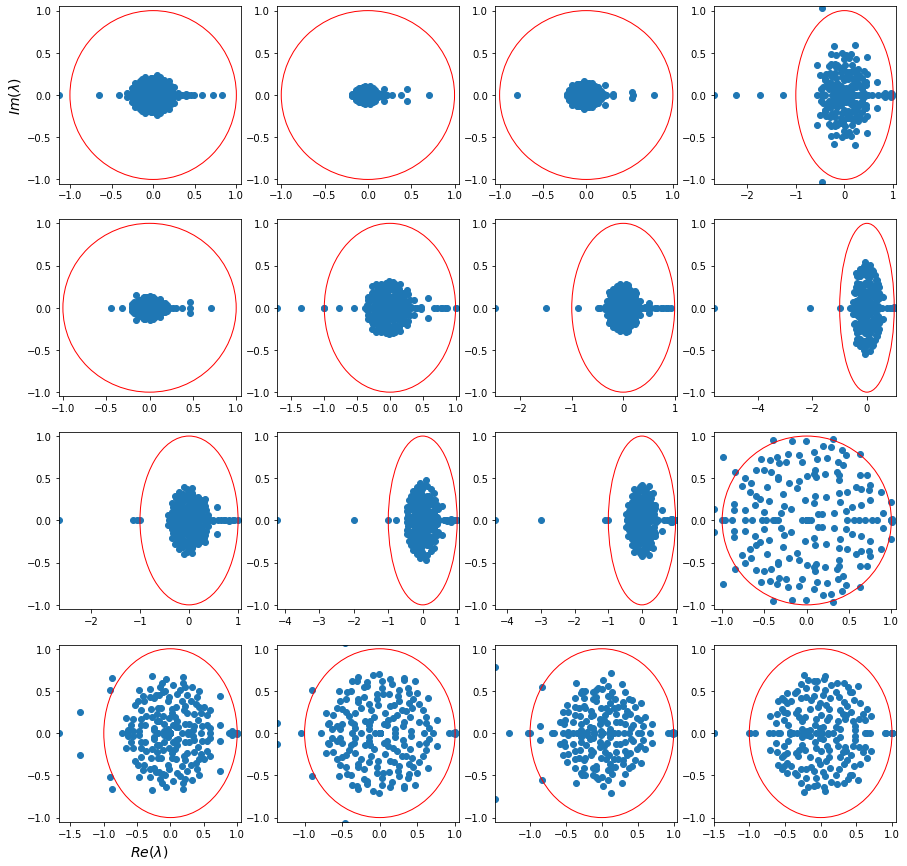

In [160]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))

for i in range(len(varmodels1)):
    
    a = ax[np.unravel_index(i, (4, 4))]
    eigvals = np.linalg.eigvals(np.squeeze(varmodels1[i].coef_))
    a.scatter(np.real(eigvals), np.imag(eigvals))
    circle = mpl.patches.Circle((0, 0), 1, color='red', fill=False)
    a.set_xlim([min(-1.05, np.min(np.real(eigvals))), 
                max(1.05, np.max(np.real(eigvals)))])
    a.set_ylim([-1.05, 1.05])
    
    a.add_patch(circle)

ax[-1, 0].set_xlabel(r'$Re(\lambda)$', fontsize=14)
ax[0, 0].set_ylabel(r'$Im(\lambda)$', fontsize=14)

fig.savefig('sabes_segmentation/ambient_fits.pdf', bbox_inches='tight', pad_inches=0)

In [154]:
len(varmodels2)

11

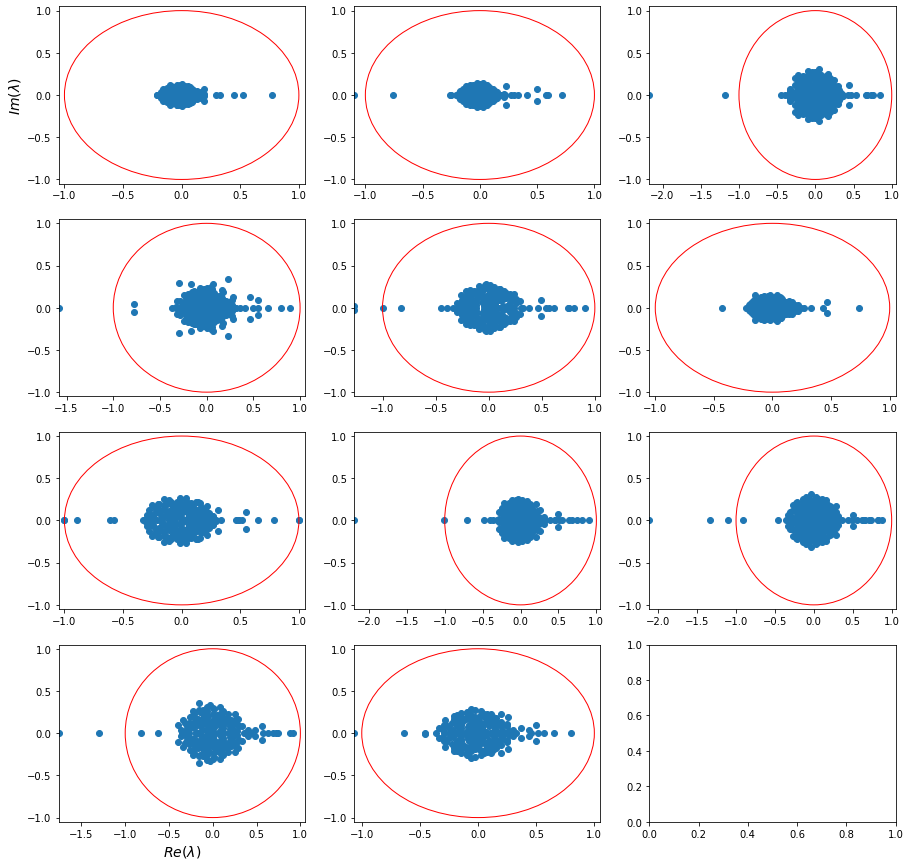

In [161]:
fig, ax = plt.subplots(4, 3, figsize=(15, 15))

for i in range(len(varmodels2)):
    
    a = ax[np.unravel_index(i, (4, 3))]
    eigvals = np.linalg.eigvals(np.squeeze(varmodels2[i].coef_))
    a.scatter(np.real(eigvals), np.imag(eigvals))
    circle = mpl.patches.Circle((0, 0), 1, color='red', fill=False)
    a.set_xlim([min(-1.05, np.min(np.real(eigvals))), 
                max(1.05, np.max(np.real(eigvals)))])
    a.set_ylim([-1.05, 1.05])
    
    a.add_patch(circle)

ax[-1, 0].set_xlabel(r'$Re(\lambda)$', fontsize=14)
ax[0, 0].set_ylabel(r'$Im(\lambda)$', fontsize=14)

fig.savefig('sabes_segmentation/embedded_fits.pdf', bbox_inches='tight', pad_inches=0)